# <center>Spaceship Titanic<center>

O objetivo deste trabalho é apresentar a minha solução para a competição Spaceship Titanic presente no Kaggle.

Mais informações sobre a competição em https://www.kaggle.com/competitions/spaceship-titanic/overview

In [1]:
# Algumas importações necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC , NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score , KFold , StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from IPython.display import Image
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from IPython.display import Image

In [2]:
# Lendo os arquivos de treino e de teste

train = pd.read_csv('train-SpaceshipTitanic.csv')
test = pd.read_csv('test-SpaceshipTitanic.csv')

In [3]:
# Tamanho do dataset de treino 

train.shape

(8693, 14)

In [4]:
# Tamanho do dataset de teste

test.shape

(4277, 13)

In [5]:
# Visualizando as 5 primeiras linhas do dataset de treino

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# Olhando os tipos de dados

train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
# Algumas estatísticas 

train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Lidando com Valores Ausentes

In [8]:
# Primeiramente vamos observar quais features possuem valores ausentes no dataset de treino

train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [9]:
# Fazendo o mesmo para o dataset de teste

test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Vamos adotar a seguinte estratégia: Para variáveis numéricas substituiremos os valores ausentes pela média da coluna e para variáveis categóricas substituiremos os valores ausentes pela categoria mais comum.

### HomePlanet

In [10]:
train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [11]:
# Substituindo os valores ausentes por Earth

train.loc[train['HomePlanet'].isnull() , 'HomePlanet'] = 'Earth'
test.loc[test['HomePlanet'].isnull() , 'HomePlanet'] = 'Earth'

### CryoSleep

In [12]:
train['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [13]:
# Substituindo os valores ausentes por False

train.loc[train['CryoSleep'].isnull() , 'CryoSleep'] = False
test.loc[test['CryoSleep'].isnull() , 'CryoSleep'] = False

### Cabin

In [14]:
train['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [15]:
# Substituindo os valores ausentes por X/Num/XPS

train.loc[train['Cabin'].isnull() , 'Cabin'] = 'X/Num/XPS'
test.loc[test['Cabin'].isnull() , 'Cabin'] = 'X/Num/XPS'

### Destination

In [16]:
train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [17]:
# Substituindo os valores ausentes por "TRAPPIST-1e"

train.loc[train['Destination'].isnull() , 'Destination'] = 'TRAPPIST-1e'
test.loc[test['Destination'].isnull() , 'Destination'] = 'TRAPPIST-1e'

### Age

In [18]:
train['Age']

0       39.0
1       24.0
2       58.0
3       33.0
4       16.0
        ... 
8688    41.0
8689    18.0
8690    26.0
8691    32.0
8692    44.0
Name: Age, Length: 8693, dtype: float64

In [19]:
# Substituindo os valores ausentes pela média da coluna Age

train.loc[train['Age'].isnull() , 'Age'] = train['Age'].mean()
test.loc[test['Age'].isnull() , 'Age'] = train['Age'].mean()

### VIP

In [20]:
train['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [21]:
# Substituindo os valores ausentes por False

train.loc[train['VIP'].isnull() , 'VIP'] = False
test.loc[test['VIP'].isnull() , 'VIP'] = False

### RoomService

In [22]:
train['RoomService']

0         0.0
1       109.0
2        43.0
3         0.0
4       303.0
        ...  
8688      0.0
8689      0.0
8690      0.0
8691      0.0
8692    126.0
Name: RoomService, Length: 8693, dtype: float64

In [23]:
# Substituindo os valores ausentes pela média da coluna RoomService

train.loc[train['RoomService'].isnull() , 'RoomService'] = train['RoomService'].mean()
test.loc[test['RoomService'].isnull() , 'RoomService'] = train['RoomService'].mean()

### FoodCourt

In [24]:
train['FoodCourt']

0          0.0
1          9.0
2       3576.0
3       1283.0
4         70.0
         ...  
8688    6819.0
8689       0.0
8690       0.0
8691    1049.0
8692    4688.0
Name: FoodCourt, Length: 8693, dtype: float64

In [25]:
# Substituindo os valores ausentes pela média da coluna FoodCourt

train.loc[train['FoodCourt'].isnull() , 'FoodCourt'] = train['FoodCourt'].mean()
test.loc[test['FoodCourt'].isnull() , 'FoodCourt'] = train['FoodCourt'].mean()

### ShoppingMall

In [26]:
train['ShoppingMall']

0          0.0
1         25.0
2          0.0
3        371.0
4        151.0
         ...  
8688       0.0
8689       0.0
8690    1872.0
8691       0.0
8692       0.0
Name: ShoppingMall, Length: 8693, dtype: float64

In [27]:
# Substituindo os valores ausentes pela média da coluna ShoppingMall

train.loc[train['ShoppingMall'].isnull() , 'ShoppingMall'] = train['ShoppingMall'].mean()
test.loc[test['ShoppingMall'].isnull() , 'ShoppingMall'] = train['ShoppingMall'].mean()

### Spa

In [28]:
train['Spa']

0          0.0
1        549.0
2       6715.0
3       3329.0
4        565.0
         ...  
8688    1643.0
8689       0.0
8690       1.0
8691     353.0
8692       0.0
Name: Spa, Length: 8693, dtype: float64

In [29]:
# Substituindo os valores ausentes pela média da coluna Spa

train.loc[train['Spa'].isnull() , 'Spa'] = train['Spa'].mean()
test.loc[test['Spa'].isnull() , 'Spa'] = train['Spa'].mean()

### VRDeck

In [30]:
train['VRDeck']

0          0.0
1         44.0
2         49.0
3        193.0
4          2.0
         ...  
8688      74.0
8689       0.0
8690       0.0
8691    3235.0
8692      12.0
Name: VRDeck, Length: 8693, dtype: float64

In [31]:
# Substituindo os valores ausentes pela média da coluna VRDeck

train.loc[train['VRDeck'].isnull() , 'VRDeck'] = train['VRDeck'].mean()
test.loc[test['VRDeck'].isnull() , 'VRDeck'] = train['VRDeck'].mean()

In [32]:
# Somente a coluna Name com valores ausentes. Sem problemas, pois não usaremos essa variável na modelagem.

train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [33]:
test.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name            94
dtype: int64

## Feature Engineering

### HomePlanet

In [34]:
train['HomePlanet'].value_counts()

Earth     4803
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [35]:
pd.get_dummies(train['HomePlanet'])

,Earth,Europa,Mars
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0
...,...,...,...
8688,0,1,0
8689,1,0,0
8690,1,0,0
8691,0,1,0


In [36]:
# Adicionando as variáveis Earth, Europe e Mars aos datasets de treino e teste

train = pd.concat([train , pd.get_dummies(train['HomePlanet'])] , axis = 1)
test = pd.concat([test , pd.get_dummies(test['HomePlanet'])] , axis = 1)

## CryoSleep

In [37]:
test['CryoSleep'].value_counts()

False    2733
True     1544
Name: CryoSleep, dtype: int64

In [38]:
# Substituindo False por 0 e True por 1

lista = []
for i in train['CryoSleep'] :
    if i == False :
        lista.append(0)
    else :
        lista.append(1)
train['CryoSleep'] = lista

lista = []
for i in test['CryoSleep'] :
    if i == False :
        lista.append(0)
    else :
        lista.append(1)
test['CryoSleep'] = lista

### Cabin

In [39]:
# Extraindo deck e side da variável Cabin e criando as variáveis Deck e Side no dataset de treino

deck = []
num = []
side = []
for i in train['Cabin'].str.split('/') :
    deck.append(i[0])
    num.append(i[1])
    side.append(i[2])

train['Deck'] = deck
train['Side'] = side

In [40]:
# Fazendo o mesmo para o dataset de teste

deck = []
num = []
side = []
for i in test['Cabin'].str.split('/') :
    deck.append(i[0])
    num.append(i[1])
    side.append(i[2])
    
test['Deck'] = deck
test['Side'] = side

In [41]:
pd.get_dummies(train['Deck'])

,A,B,C,D,E,F,G,T,X
0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0,0,0,0,0,0
8689,0,0,0,0,0,0,1,0,0
8690,0,0,0,0,0,0,1,0,0
8691,0,0,0,0,1,0,0,0,0


In [42]:
pd.get_dummies(train['Side'])

,P,S,XPS
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
8688,1,0,0
8689,0,1,0
8690,0,1,0
8691,0,1,0


In [43]:
# Criando as variáveis A, B, C, D, E, F, G, T, X, P, S e XPS nos datasets de treino e de teste

train = pd.concat([train , pd.get_dummies(train['Deck'])] , axis = 1)
train = pd.concat([train , pd.get_dummies(train['Side'])] , axis = 1)

test = pd.concat([test , pd.get_dummies(test['Deck'])] , axis = 1)
test = pd.concat([test , pd.get_dummies(test['Side'])] , axis = 1)

### Destination

In [44]:
train['Destination'].value_counts()

TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [45]:
# Adicionando as variáveis TRAPPIST-1e, 55 Cancri e PSO J318.5-22 aos datasets de treino e teste

train = pd.concat([train , pd.get_dummies(train['Destination'])] , axis = 1)
test = pd.concat([test , pd.get_dummies(test['Destination'])] , axis = 1)

### Age

In [46]:
SS = StandardScaler()

In [47]:
# Feature Scaling

train['Age_SS'] = SS.fit_transform(train[['Age']])
test['Age_SS'] = SS.fit_transform(test[['Age']])

### VIP

In [48]:
train['VIP'].value_counts()

False    8494
True      199
Name: VIP, dtype: int64

In [49]:
# Substituindo False por 0 e True por 1 no dataset de treino

lista = []
for i in train['VIP'] :
    if i == False :
        lista.append(0)
    else :
        lista.append(1)

train['VIP'] = lista

In [50]:
# Fazendo o mesmo no dataset de teste

lista = []
for i in test['VIP'] :
    if i == False :
        lista.append(0)
    else :
        lista.append(1)
        
test['VIP'] = lista

### RoomService

In [51]:
# Feature Scaling

train['RoomService_SS'] = SS.fit_transform(train[['RoomService']])
test['RoomService_SS'] = SS.fit_transform(test[['RoomService']])

In [52]:
# Criando a variável Gastou_em_RoomService? que recebe o valor 1 se alguém gastou com esse serviço e 0 caso contrário.

lista = []
for i in train['RoomService'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_RoomService?'] = lista

lista = []
for i in test['RoomService'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_RoomService?'] = lista

### FoodCourt

In [53]:
# Feature Scaling

train['FoodCourt_SS'] = SS.fit_transform(train[['FoodCourt']])
test['FoodCourt_SS'] = SS.fit_transform(test[['FoodCourt']])

In [54]:
# Criando a variável Gastou_em_FoodCourt? que recebe o valor 1 se alguém gastou com esse serviço e 0 caso contrário.

lista = []
for i in train['FoodCourt'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_FoodCourt?'] = lista

lista = []
for i in test['FoodCourt'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_FoodCourt?'] = lista

### ShoppingMall

In [55]:
# Feature Scaling

train['ShoppingMall_SS'] = SS.fit_transform(train[['ShoppingMall']])
test['ShoppingMall_SS'] = SS.fit_transform(test[['ShoppingMall']])

In [56]:
# Criando a variável Gastou_em_ShoppingMall? que recebe o valor 1 se alguém gastou com esse serviço e 0 caso contrário.

lista = []
for i in train['ShoppingMall'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_ShoppingMall?'] = lista

lista = []
for i in test['ShoppingMall'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_ShoppingMall?'] = lista

### Spa

In [57]:
# Feature Scaling

train['Spa_SS'] = SS.fit_transform(train[['Spa']])
test['Spa_SS'] = SS.fit_transform(test[['Spa']])

In [58]:
# Criando a variável Gastou_em_Spa? que recebe o valor 1 se alguém gastou com esse serviço e 0 caso contrário.

lista = []
for i in train['Spa'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_Spa?'] = lista

lista = []

for i in test['Spa'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_Spa?'] = lista

### VRDeck

In [59]:
# Feature Scaling

train['VRDeck_SS'] = SS.fit_transform(train[['VRDeck']])
test['VRDeck_SS'] = SS.fit_transform(test[['VRDeck']])

In [60]:
# Criando a variável Gastou_em_VRDeck? que recebe o valor 1 se alguém gastou com esse serviço e 0 caso contrário.

lista = []
for i in train['VRDeck'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_VRDeck?'] = lista

lista = []
for i in test['VRDeck'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_VRDeck?'] = lista

### Gastou_em_Quantos?

Criando a variável Gastou_em_Quantos? que indica o número de serviços em que uma pessoa gastou seu dinheiro. Os serviços considerados são RoomService, FoodCourt, ShoppingMall, Spa e VRDeck. Portanto essa variável pode assumir os valores 0, 1, 2, 3, 4 ou 5.

In [61]:
train['Gastou_em_Quantos?'] = train['Gastou_em_RoomService?'] + train['Gastou_em_FoodCourt?'] + train['Gastou_em_ShoppingMall?'] + train['Gastou_em_Spa?'] + train['Gastou_em_VRDeck?']

In [62]:
test['Gastou_em_Quantos?'] = test['Gastou_em_RoomService?'] + test['Gastou_em_FoodCourt?'] + test['Gastou_em_ShoppingMall?'] + test['Gastou_em_Spa?'] + test['Gastou_em_VRDeck?']

### Gastou_em_Algum?

Criando a variável Gastou_em_Algum? que recebe o valor 1 se uma pessoa gastou em pelo menos um serviço e caso contrário recebe o valor 0.

In [63]:
lista = []
for i in train['Gastou_em_Quantos?'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
train['Gastou_em_Algum?'] = lista

lista = []
for i in test['Gastou_em_Quantos?'] :
    if i == 0 :
        lista.append(0)
    else :
        lista.append(1)
test['Gastou_em_Algum?'] = lista

### Gasto_Total

Criando a variável Gasto_Total que indica a soma dos gastos em RoomService, FoodCourt, ShoppingMall, Spa e VRDeck.

In [64]:
train['Gasto_Total'] = train['RoomService_SS']+ train['FoodCourt_SS']+train['ShoppingMall_SS']+train['Spa_SS']+train['VRDeck_SS']

In [65]:
test['Gasto_Total'] = test['RoomService_SS']+test['FoodCourt_SS']+test['ShoppingMall_SS']+test['Spa_SS']+test['VRDeck_SS']

### Spa_SS+VRDeck_SS

In [66]:
train['Spa_SS+VRDeck_SS'] = train['Spa_SS'] + train['VRDeck_SS']
test['Spa_SS+VRDeck_SS'] = test['Spa_SS'] + test['VRDeck_SS']

### FoodCourt_SS+Spa_SS

In [67]:
train['FoodCourt_SS+Spa_SS'] = train['FoodCourt_SS'] + train['Spa_SS']
test['FoodCourt_SS+Spa_SS'] = test['FoodCourt_SS'] + test['Spa_SS']

## Modelagem

Após realizar testes com diversos conjuntos de variáveis concluí que o conjunto abaixo é o que parece fornecer os melhores resultados:

In [68]:
features =  ['Earth', 'Mars', 'A', 'B', 'C', 'D', 'E', 'F','T','X',
        'S', 'P', '55 Cancri e', 'PSO J318.5-22',
        'Age_SS' ,'Gastou_em_RoomService?', 'Gastou_em_FoodCourt?' , 'Gastou_em_ShoppingMall?' , 
           'Gastou_em_Spa?' , 'Gastou_em_VRDeck?', 'Gastou_em_Quantos?', 'Gastou_em_Algum?', 'CryoSleep', 'VIP' ,
             'RoomService_SS' , 'FoodCourt_SS' , 'ShoppingMall_SS' , 'Spa_SS' , 'VRDeck_SS' , 'Gasto_Total' , 'Spa_SS+VRDeck_SS',
             'FoodCourt_SS+Spa_SS' ]

In [69]:
# Modelos

modelos = [LogisticRegression(max_iter = 1000) , KNeighborsClassifier() , SVC(), LinearSVC(max_iter = 50000) ,
          DecisionTreeClassifier(), GaussianNB() , RandomForestClassifier() , AdaBoostClassifier() ,
          GradientBoostingClassifier(), XGBClassifier(use_label_encoder = False) ,
          CatBoostClassifier() , LGBMClassifier() ]

In [70]:
# Nomes dos modelos

nome_modelos = ['Regressão Logística' , 'KNN' , 'SVC' , 'Linear SVC' , 'Árvore de Decisão' , 'Naive Bayes' , 'Random Forest',
               'AdaBoost' , 'GradientBoosting' , 'XGB' , 'CatBoost' , 'LGBM']

In [71]:
train['Transported'] = train['Transported'].astype('int32')
X_train = train[features]
y_train = train['Transported']

In [72]:
# Guardando a acurácia de cada modelo quando fazemos uma validação cruzada com 3 dobras

scores_validação = []
for modelo in modelos :
    scores_validação.append(np.mean(cross_val_score(modelo , X_train, y_train, cv = 3 )))

[05:29:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.021815
0:	learn: 0.6809490	total: 194ms	remaining: 3m 13s
1:	learn: 0.6710181	total: 218ms	remaining: 1m 48s
2:	learn: 0.6611605	total: 239ms	remaining: 1m 19s
3:	learn: 0.6511993	total: 261ms	remaining: 1m 4s
4:	learn: 0

154:	learn: 0.3942668	total: 4.83s	remaining: 26.3s
155:	learn: 0.3941611	total: 4.86s	remaining: 26.3s
156:	learn: 0.3937001	total: 4.91s	remaining: 26.4s
157:	learn: 0.3934093	total: 4.94s	remaining: 26.3s
158:	learn: 0.3931551	total: 4.99s	remaining: 26.4s
159:	learn: 0.3928722	total: 5.02s	remaining: 26.4s
160:	learn: 0.3926532	total: 5.08s	remaining: 26.5s
161:	learn: 0.3923855	total: 5.12s	remaining: 26.5s
162:	learn: 0.3922250	total: 5.15s	remaining: 26.5s
163:	learn: 0.3918193	total: 5.19s	remaining: 26.5s
164:	learn: 0.3916888	total: 5.24s	remaining: 26.5s
165:	learn: 0.3914998	total: 5.29s	remaining: 26.6s
166:	learn: 0.3909886	total: 5.41s	remaining: 27s
167:	learn: 0.3906972	total: 5.58s	remaining: 27.6s
168:	learn: 0.3905322	total: 5.61s	remaining: 27.6s
169:	learn: 0.3903423	total: 5.66s	remaining: 27.6s
170:	learn: 0.3900633	total: 5.7s	remaining: 27.6s
171:	learn: 0.3899494	total: 5.74s	remaining: 27.6s
172:	learn: 0.3896663	total: 5.8s	remaining: 27.7s
173:	learn: 0.38

318:	learn: 0.3636506	total: 9.33s	remaining: 19.9s
319:	learn: 0.3635698	total: 9.39s	remaining: 19.9s
320:	learn: 0.3634208	total: 9.45s	remaining: 20s
321:	learn: 0.3632101	total: 9.49s	remaining: 20s
322:	learn: 0.3631041	total: 9.53s	remaining: 20s
323:	learn: 0.3629678	total: 9.55s	remaining: 19.9s
324:	learn: 0.3626956	total: 9.59s	remaining: 19.9s
325:	learn: 0.3625400	total: 9.62s	remaining: 19.9s
326:	learn: 0.3623814	total: 9.65s	remaining: 19.9s
327:	learn: 0.3622097	total: 9.68s	remaining: 19.8s
328:	learn: 0.3620456	total: 9.71s	remaining: 19.8s
329:	learn: 0.3618958	total: 9.77s	remaining: 19.8s
330:	learn: 0.3618030	total: 9.81s	remaining: 19.8s
331:	learn: 0.3616151	total: 9.84s	remaining: 19.8s
332:	learn: 0.3614456	total: 9.87s	remaining: 19.8s
333:	learn: 0.3613050	total: 9.9s	remaining: 19.7s
334:	learn: 0.3612094	total: 9.92s	remaining: 19.7s
335:	learn: 0.3609828	total: 9.94s	remaining: 19.7s
336:	learn: 0.3607476	total: 9.97s	remaining: 19.6s
337:	learn: 0.36056

477:	learn: 0.3411298	total: 13.6s	remaining: 14.8s
478:	learn: 0.3409918	total: 13.6s	remaining: 14.8s
479:	learn: 0.3408858	total: 13.6s	remaining: 14.8s
480:	learn: 0.3407443	total: 13.6s	remaining: 14.7s
481:	learn: 0.3406713	total: 13.7s	remaining: 14.7s
482:	learn: 0.3405200	total: 13.7s	remaining: 14.7s
483:	learn: 0.3404588	total: 13.7s	remaining: 14.6s
484:	learn: 0.3403039	total: 13.8s	remaining: 14.6s
485:	learn: 0.3402138	total: 13.8s	remaining: 14.6s
486:	learn: 0.3400954	total: 13.8s	remaining: 14.6s
487:	learn: 0.3399841	total: 13.8s	remaining: 14.5s
488:	learn: 0.3399024	total: 13.9s	remaining: 14.5s
489:	learn: 0.3396938	total: 13.9s	remaining: 14.5s
490:	learn: 0.3396171	total: 13.9s	remaining: 14.4s
491:	learn: 0.3394417	total: 13.9s	remaining: 14.4s
492:	learn: 0.3391563	total: 14s	remaining: 14.4s
493:	learn: 0.3390050	total: 14s	remaining: 14.3s
494:	learn: 0.3388922	total: 14s	remaining: 14.3s
495:	learn: 0.3387576	total: 14s	remaining: 14.3s
496:	learn: 0.338645

637:	learn: 0.3202527	total: 17.5s	remaining: 9.92s
638:	learn: 0.3201463	total: 17.5s	remaining: 9.89s
639:	learn: 0.3200239	total: 17.5s	remaining: 9.86s
640:	learn: 0.3199030	total: 17.6s	remaining: 9.84s
641:	learn: 0.3197662	total: 17.6s	remaining: 9.81s
642:	learn: 0.3196652	total: 17.6s	remaining: 9.78s
643:	learn: 0.3196035	total: 17.7s	remaining: 9.76s
644:	learn: 0.3194838	total: 17.7s	remaining: 9.73s
645:	learn: 0.3193725	total: 17.7s	remaining: 9.71s
646:	learn: 0.3193317	total: 17.7s	remaining: 9.68s
647:	learn: 0.3192524	total: 17.8s	remaining: 9.65s
648:	learn: 0.3191836	total: 17.8s	remaining: 9.62s
649:	learn: 0.3191037	total: 17.8s	remaining: 9.59s
650:	learn: 0.3189978	total: 17.8s	remaining: 9.56s
651:	learn: 0.3188358	total: 17.9s	remaining: 9.53s
652:	learn: 0.3187110	total: 17.9s	remaining: 9.5s
653:	learn: 0.3185867	total: 17.9s	remaining: 9.48s
654:	learn: 0.3184922	total: 17.9s	remaining: 9.45s
655:	learn: 0.3183965	total: 18s	remaining: 9.42s
656:	learn: 0.3

800:	learn: 0.3013859	total: 22s	remaining: 5.47s
801:	learn: 0.3013403	total: 22s	remaining: 5.44s
802:	learn: 0.3012290	total: 22.1s	remaining: 5.41s
803:	learn: 0.3011249	total: 22.1s	remaining: 5.38s
804:	learn: 0.3010464	total: 22.1s	remaining: 5.35s
805:	learn: 0.3009803	total: 22.1s	remaining: 5.33s
806:	learn: 0.3008598	total: 22.1s	remaining: 5.3s
807:	learn: 0.3006953	total: 22.2s	remaining: 5.27s
808:	learn: 0.3005330	total: 22.2s	remaining: 5.24s
809:	learn: 0.3004639	total: 22.2s	remaining: 5.21s
810:	learn: 0.3003284	total: 22.2s	remaining: 5.18s
811:	learn: 0.3001665	total: 22.3s	remaining: 5.16s
812:	learn: 0.3000700	total: 22.3s	remaining: 5.13s
813:	learn: 0.3000094	total: 22.3s	remaining: 5.1s
814:	learn: 0.2999509	total: 22.3s	remaining: 5.07s
815:	learn: 0.2998676	total: 22.4s	remaining: 5.04s
816:	learn: 0.2997477	total: 22.4s	remaining: 5.01s
817:	learn: 0.2996816	total: 22.4s	remaining: 4.99s
818:	learn: 0.2996169	total: 22.4s	remaining: 4.96s
819:	learn: 0.2994

965:	learn: 0.2859887	total: 26s	remaining: 916ms
966:	learn: 0.2858992	total: 26s	remaining: 889ms
967:	learn: 0.2858054	total: 26.1s	remaining: 862ms
968:	learn: 0.2856968	total: 26.1s	remaining: 835ms
969:	learn: 0.2855746	total: 26.1s	remaining: 808ms
970:	learn: 0.2855160	total: 26.1s	remaining: 781ms
971:	learn: 0.2854473	total: 26.2s	remaining: 754ms
972:	learn: 0.2853576	total: 26.2s	remaining: 727ms
973:	learn: 0.2853102	total: 26.2s	remaining: 700ms
974:	learn: 0.2852582	total: 26.2s	remaining: 673ms
975:	learn: 0.2851734	total: 26.3s	remaining: 646ms
976:	learn: 0.2850775	total: 26.3s	remaining: 619ms
977:	learn: 0.2849804	total: 26.3s	remaining: 592ms
978:	learn: 0.2849288	total: 26.3s	remaining: 565ms
979:	learn: 0.2848064	total: 26.4s	remaining: 538ms
980:	learn: 0.2847310	total: 26.4s	remaining: 511ms
981:	learn: 0.2846245	total: 26.4s	remaining: 484ms
982:	learn: 0.2845486	total: 26.4s	remaining: 457ms
983:	learn: 0.2844827	total: 26.5s	remaining: 430ms
984:	learn: 0.28

129:	learn: 0.4089435	total: 3.46s	remaining: 23.1s
130:	learn: 0.4086965	total: 3.49s	remaining: 23.1s
131:	learn: 0.4084854	total: 3.51s	remaining: 23.1s
132:	learn: 0.4082243	total: 3.54s	remaining: 23.1s
133:	learn: 0.4079534	total: 3.56s	remaining: 23s
134:	learn: 0.4077709	total: 3.58s	remaining: 23s
135:	learn: 0.4074077	total: 3.61s	remaining: 22.9s
136:	learn: 0.4068089	total: 3.63s	remaining: 22.9s
137:	learn: 0.4066671	total: 3.65s	remaining: 22.8s
138:	learn: 0.4064232	total: 3.68s	remaining: 22.8s
139:	learn: 0.4061049	total: 3.7s	remaining: 22.7s
140:	learn: 0.4058904	total: 3.72s	remaining: 22.7s
141:	learn: 0.4056131	total: 3.74s	remaining: 22.6s
142:	learn: 0.4053789	total: 3.76s	remaining: 22.6s
143:	learn: 0.4051450	total: 3.79s	remaining: 22.5s
144:	learn: 0.4049462	total: 3.81s	remaining: 22.5s
145:	learn: 0.4046697	total: 3.84s	remaining: 22.5s
146:	learn: 0.4044795	total: 3.86s	remaining: 22.4s
147:	learn: 0.4042569	total: 3.89s	remaining: 22.4s
148:	learn: 0.403

294:	learn: 0.3782330	total: 7.37s	remaining: 17.6s
295:	learn: 0.3780215	total: 7.39s	remaining: 17.6s
296:	learn: 0.3778919	total: 7.41s	remaining: 17.5s
297:	learn: 0.3777716	total: 7.43s	remaining: 17.5s
298:	learn: 0.3776691	total: 7.46s	remaining: 17.5s
299:	learn: 0.3773242	total: 7.48s	remaining: 17.4s
300:	learn: 0.3771982	total: 7.5s	remaining: 17.4s
301:	learn: 0.3770761	total: 7.52s	remaining: 17.4s
302:	learn: 0.3770126	total: 7.54s	remaining: 17.3s
303:	learn: 0.3769213	total: 7.56s	remaining: 17.3s
304:	learn: 0.3767384	total: 7.58s	remaining: 17.3s
305:	learn: 0.3766352	total: 7.61s	remaining: 17.3s
306:	learn: 0.3765624	total: 7.63s	remaining: 17.2s
307:	learn: 0.3764833	total: 7.65s	remaining: 17.2s
308:	learn: 0.3764308	total: 7.68s	remaining: 17.2s
309:	learn: 0.3762473	total: 7.7s	remaining: 17.1s
310:	learn: 0.3761162	total: 7.72s	remaining: 17.1s
311:	learn: 0.3760121	total: 7.74s	remaining: 17.1s
312:	learn: 0.3759328	total: 7.76s	remaining: 17s
313:	learn: 0.37

461:	learn: 0.3558912	total: 11.4s	remaining: 13.2s
462:	learn: 0.3558168	total: 11.4s	remaining: 13.2s
463:	learn: 0.3557613	total: 11.4s	remaining: 13.2s
464:	learn: 0.3556435	total: 11.5s	remaining: 13.2s
465:	learn: 0.3555001	total: 11.5s	remaining: 13.1s
466:	learn: 0.3554288	total: 11.5s	remaining: 13.1s
467:	learn: 0.3552921	total: 11.5s	remaining: 13.1s
468:	learn: 0.3551740	total: 11.5s	remaining: 13.1s
469:	learn: 0.3550506	total: 11.6s	remaining: 13s
470:	learn: 0.3549273	total: 11.6s	remaining: 13s
471:	learn: 0.3548159	total: 11.6s	remaining: 13s
472:	learn: 0.3547089	total: 11.6s	remaining: 13s
473:	learn: 0.3546545	total: 11.7s	remaining: 12.9s
474:	learn: 0.3545519	total: 11.7s	remaining: 12.9s
475:	learn: 0.3543328	total: 11.7s	remaining: 12.9s
476:	learn: 0.3542687	total: 11.7s	remaining: 12.9s
477:	learn: 0.3541300	total: 11.8s	remaining: 12.8s
478:	learn: 0.3539867	total: 11.8s	remaining: 12.8s
479:	learn: 0.3538665	total: 11.8s	remaining: 12.8s
480:	learn: 0.353742

621:	learn: 0.3369807	total: 15.5s	remaining: 9.4s
622:	learn: 0.3369123	total: 15.5s	remaining: 9.4s
623:	learn: 0.3368210	total: 15.6s	remaining: 9.39s
624:	learn: 0.3366903	total: 15.6s	remaining: 9.37s
625:	learn: 0.3366022	total: 15.6s	remaining: 9.35s
626:	learn: 0.3365292	total: 15.7s	remaining: 9.32s
627:	learn: 0.3364862	total: 15.7s	remaining: 9.31s
628:	learn: 0.3364168	total: 15.7s	remaining: 9.29s
629:	learn: 0.3363490	total: 15.8s	remaining: 9.26s
630:	learn: 0.3362793	total: 15.8s	remaining: 9.24s
631:	learn: 0.3362050	total: 15.8s	remaining: 9.22s
632:	learn: 0.3361520	total: 15.9s	remaining: 9.19s
633:	learn: 0.3361205	total: 15.9s	remaining: 9.16s
634:	learn: 0.3360529	total: 15.9s	remaining: 9.14s
635:	learn: 0.3359125	total: 15.9s	remaining: 9.12s
636:	learn: 0.3357740	total: 16s	remaining: 9.09s
637:	learn: 0.3357236	total: 16s	remaining: 9.06s
638:	learn: 0.3356571	total: 16s	remaining: 9.04s
639:	learn: 0.3354838	total: 16s	remaining: 9.02s
640:	learn: 0.3353656	

780:	learn: 0.3218546	total: 20.4s	remaining: 5.72s
781:	learn: 0.3218007	total: 20.4s	remaining: 5.69s
782:	learn: 0.3217605	total: 20.4s	remaining: 5.66s
783:	learn: 0.3217010	total: 20.5s	remaining: 5.64s
784:	learn: 0.3215921	total: 20.5s	remaining: 5.62s
785:	learn: 0.3214101	total: 20.5s	remaining: 5.59s
786:	learn: 0.3213051	total: 20.6s	remaining: 5.57s
787:	learn: 0.3211154	total: 20.6s	remaining: 5.55s
788:	learn: 0.3210000	total: 20.6s	remaining: 5.52s
789:	learn: 0.3209350	total: 20.7s	remaining: 5.5s
790:	learn: 0.3207742	total: 20.7s	remaining: 5.47s
791:	learn: 0.3206783	total: 20.7s	remaining: 5.44s
792:	learn: 0.3206027	total: 20.8s	remaining: 5.42s
793:	learn: 0.3205296	total: 20.8s	remaining: 5.39s
794:	learn: 0.3204181	total: 20.8s	remaining: 5.37s
795:	learn: 0.3203636	total: 20.8s	remaining: 5.34s
796:	learn: 0.3202933	total: 20.9s	remaining: 5.31s
797:	learn: 0.3201523	total: 20.9s	remaining: 5.29s
798:	learn: 0.3200771	total: 20.9s	remaining: 5.27s
799:	learn: 0

946:	learn: 0.3076438	total: 24.6s	remaining: 1.38s
947:	learn: 0.3075790	total: 24.7s	remaining: 1.35s
948:	learn: 0.3074855	total: 24.7s	remaining: 1.33s
949:	learn: 0.3074351	total: 24.7s	remaining: 1.3s
950:	learn: 0.3073257	total: 24.7s	remaining: 1.27s
951:	learn: 0.3072634	total: 24.7s	remaining: 1.25s
952:	learn: 0.3071442	total: 24.8s	remaining: 1.22s
953:	learn: 0.3070676	total: 24.8s	remaining: 1.2s
954:	learn: 0.3069987	total: 24.8s	remaining: 1.17s
955:	learn: 0.3068746	total: 24.8s	remaining: 1.14s
956:	learn: 0.3067838	total: 24.9s	remaining: 1.12s
957:	learn: 0.3067146	total: 24.9s	remaining: 1.09s
958:	learn: 0.3066075	total: 24.9s	remaining: 1.06s
959:	learn: 0.3065110	total: 24.9s	remaining: 1.04s
960:	learn: 0.3064703	total: 24.9s	remaining: 1.01s
961:	learn: 0.3064333	total: 25s	remaining: 986ms
962:	learn: 0.3063009	total: 25s	remaining: 960ms
963:	learn: 0.3061456	total: 25s	remaining: 934ms
964:	learn: 0.3060495	total: 25s	remaining: 908ms
965:	learn: 0.3059720	

111:	learn: 0.4265251	total: 2.69s	remaining: 21.3s
112:	learn: 0.4261422	total: 2.71s	remaining: 21.3s
113:	learn: 0.4257200	total: 2.73s	remaining: 21.2s
114:	learn: 0.4253556	total: 2.75s	remaining: 21.2s
115:	learn: 0.4249951	total: 2.77s	remaining: 21.1s
116:	learn: 0.4246364	total: 2.79s	remaining: 21.1s
117:	learn: 0.4237748	total: 2.82s	remaining: 21.1s
118:	learn: 0.4233483	total: 2.84s	remaining: 21.1s
119:	learn: 0.4229785	total: 2.87s	remaining: 21s
120:	learn: 0.4227030	total: 2.89s	remaining: 21s
121:	learn: 0.4225212	total: 2.92s	remaining: 21s
122:	learn: 0.4220977	total: 2.94s	remaining: 20.9s
123:	learn: 0.4216280	total: 2.96s	remaining: 20.9s
124:	learn: 0.4210994	total: 2.98s	remaining: 20.9s
125:	learn: 0.4205967	total: 3.01s	remaining: 20.9s
126:	learn: 0.4202598	total: 3.03s	remaining: 20.8s
127:	learn: 0.4198477	total: 3.06s	remaining: 20.8s
128:	learn: 0.4194275	total: 3.08s	remaining: 20.8s
129:	learn: 0.4189889	total: 3.11s	remaining: 20.8s
130:	learn: 0.4184

271:	learn: 0.3858045	total: 6.37s	remaining: 17s
272:	learn: 0.3856410	total: 6.39s	remaining: 17s
273:	learn: 0.3855091	total: 6.41s	remaining: 17s
274:	learn: 0.3853441	total: 6.43s	remaining: 17s
275:	learn: 0.3851863	total: 6.45s	remaining: 16.9s
276:	learn: 0.3848657	total: 6.48s	remaining: 16.9s
277:	learn: 0.3847570	total: 6.5s	remaining: 16.9s
278:	learn: 0.3846023	total: 6.52s	remaining: 16.9s
279:	learn: 0.3844471	total: 6.54s	remaining: 16.8s
280:	learn: 0.3842005	total: 6.57s	remaining: 16.8s
281:	learn: 0.3840999	total: 6.59s	remaining: 16.8s
282:	learn: 0.3839867	total: 6.62s	remaining: 16.8s
283:	learn: 0.3838053	total: 6.64s	remaining: 16.7s
284:	learn: 0.3837203	total: 6.67s	remaining: 16.7s
285:	learn: 0.3836253	total: 6.69s	remaining: 16.7s
286:	learn: 0.3834913	total: 6.71s	remaining: 16.7s
287:	learn: 0.3833711	total: 6.74s	remaining: 16.7s
288:	learn: 0.3832801	total: 6.76s	remaining: 16.6s
289:	learn: 0.3832031	total: 6.78s	remaining: 16.6s
290:	learn: 0.3830821

430:	learn: 0.3645434	total: 10.7s	remaining: 14.1s
431:	learn: 0.3643867	total: 10.7s	remaining: 14.1s
432:	learn: 0.3641693	total: 10.7s	remaining: 14.1s
433:	learn: 0.3640695	total: 10.8s	remaining: 14s
434:	learn: 0.3639592	total: 10.8s	remaining: 14s
435:	learn: 0.3638460	total: 10.8s	remaining: 14s
436:	learn: 0.3637431	total: 10.8s	remaining: 14s
437:	learn: 0.3634983	total: 10.9s	remaining: 13.9s
438:	learn: 0.3634160	total: 10.9s	remaining: 13.9s
439:	learn: 0.3633321	total: 10.9s	remaining: 13.9s
440:	learn: 0.3631435	total: 10.9s	remaining: 13.8s
441:	learn: 0.3630249	total: 10.9s	remaining: 13.8s
442:	learn: 0.3628310	total: 11s	remaining: 13.8s
443:	learn: 0.3626291	total: 11s	remaining: 13.8s
444:	learn: 0.3625120	total: 11s	remaining: 13.7s
445:	learn: 0.3624405	total: 11s	remaining: 13.7s
446:	learn: 0.3623064	total: 11.1s	remaining: 13.7s
447:	learn: 0.3622604	total: 11.1s	remaining: 13.6s
448:	learn: 0.3620813	total: 11.1s	remaining: 13.6s
449:	learn: 0.3619516	total:

593:	learn: 0.3456866	total: 14.7s	remaining: 10s
594:	learn: 0.3456416	total: 14.7s	remaining: 10s
595:	learn: 0.3454870	total: 14.7s	remaining: 9.98s
596:	learn: 0.3454158	total: 14.7s	remaining: 9.95s
597:	learn: 0.3451912	total: 14.8s	remaining: 9.92s
598:	learn: 0.3450611	total: 14.8s	remaining: 9.9s
599:	learn: 0.3449965	total: 14.8s	remaining: 9.87s
600:	learn: 0.3449755	total: 14.8s	remaining: 9.84s
601:	learn: 0.3447989	total: 14.9s	remaining: 9.82s
602:	learn: 0.3446932	total: 14.9s	remaining: 9.79s
603:	learn: 0.3446212	total: 14.9s	remaining: 9.77s
604:	learn: 0.3445733	total: 14.9s	remaining: 9.75s
605:	learn: 0.3444843	total: 15s	remaining: 9.72s
606:	learn: 0.3443657	total: 15s	remaining: 9.7s
607:	learn: 0.3442990	total: 15s	remaining: 9.68s
608:	learn: 0.3441341	total: 15s	remaining: 9.65s
609:	learn: 0.3439865	total: 15.1s	remaining: 9.67s
610:	learn: 0.3439341	total: 15.2s	remaining: 9.67s
611:	learn: 0.3437707	total: 15.2s	remaining: 9.66s
612:	learn: 0.3435954	tota

755:	learn: 0.3277347	total: 18.7s	remaining: 6.04s
756:	learn: 0.3276249	total: 18.7s	remaining: 6.02s
757:	learn: 0.3274827	total: 18.8s	remaining: 5.99s
758:	learn: 0.3273801	total: 18.8s	remaining: 5.96s
759:	learn: 0.3273247	total: 18.8s	remaining: 5.94s
760:	learn: 0.3272055	total: 18.8s	remaining: 5.91s
761:	learn: 0.3270312	total: 18.9s	remaining: 5.89s
762:	learn: 0.3269494	total: 18.9s	remaining: 5.86s
763:	learn: 0.3268170	total: 18.9s	remaining: 5.84s
764:	learn: 0.3267102	total: 18.9s	remaining: 5.82s
765:	learn: 0.3266395	total: 19s	remaining: 5.79s
766:	learn: 0.3264997	total: 19s	remaining: 5.77s
767:	learn: 0.3263259	total: 19s	remaining: 5.74s
768:	learn: 0.3262010	total: 19s	remaining: 5.72s
769:	learn: 0.3259908	total: 19.1s	remaining: 5.69s
770:	learn: 0.3258865	total: 19.1s	remaining: 5.67s
771:	learn: 0.3257400	total: 19.1s	remaining: 5.64s
772:	learn: 0.3255855	total: 19.1s	remaining: 5.62s
773:	learn: 0.3254032	total: 19.1s	remaining: 5.59s
774:	learn: 0.325270

915:	learn: 0.3124746	total: 22.6s	remaining: 2.07s
916:	learn: 0.3124276	total: 22.6s	remaining: 2.04s
917:	learn: 0.3123226	total: 22.6s	remaining: 2.02s
918:	learn: 0.3122208	total: 22.6s	remaining: 1.99s
919:	learn: 0.3121327	total: 22.7s	remaining: 1.97s
920:	learn: 0.3120290	total: 22.7s	remaining: 1.95s
921:	learn: 0.3119930	total: 22.7s	remaining: 1.92s
922:	learn: 0.3119585	total: 22.7s	remaining: 1.9s
923:	learn: 0.3118950	total: 22.8s	remaining: 1.87s
924:	learn: 0.3117874	total: 22.8s	remaining: 1.85s
925:	learn: 0.3116910	total: 22.8s	remaining: 1.82s
926:	learn: 0.3116280	total: 22.8s	remaining: 1.8s
927:	learn: 0.3115857	total: 22.8s	remaining: 1.77s
928:	learn: 0.3114436	total: 22.9s	remaining: 1.75s
929:	learn: 0.3113821	total: 22.9s	remaining: 1.72s
930:	learn: 0.3113498	total: 22.9s	remaining: 1.7s
931:	learn: 0.3112517	total: 22.9s	remaining: 1.67s
932:	learn: 0.3111511	total: 23s	remaining: 1.65s
933:	learn: 0.3110826	total: 23s	remaining: 1.62s
934:	learn: 0.31102

In [73]:
# Exibindo a acurácia que cada modelo obteve na validação cruzada

dicionário = {'Modelo' : nome_modelos , 'Acurácia Média na Validação Cruzada' : scores_validação}
df_validação = pd.DataFrame(dicionário)
df_validação

,Modelo,Acurácia Média na Validação Cruzada
0,Regressão Logística,0.791787
1,KNN,0.770046
2,SVC,0.795584
3,Linear SVC,0.792708
4,Árvore de Decisão,0.739215
5,Naive Bayes,0.727255
6,Random Forest,0.783735
7,AdaBoost,0.783275
8,GradientBoosting,0.795814
9,XGB,0.796504


Conforme visto a cima o modelo que obteve o melhor desempenho na validação cruzada foi o CatBoost portanto escolheremos esse modelo. Após um longo processo de otimização de hiperparâmetros encontrei como melhor modelo um CatBoost com os seguintes hiperparâmetros:



**learning_rate = 0,01**

**n_estimators = 1500**

**depth = 6**

## Primeira submissão ao Kaggle

In [74]:
model = CatBoostClassifier(learning_rate = 0.01 , n_estimators = 1500 , depth = 6)

In [75]:
model.fit(X_train , y_train)

0:	learn: 0.6877482	total: 28.3ms	remaining: 42.5s
1:	learn: 0.6828760	total: 59.3ms	remaining: 44.4s
2:	learn: 0.6780037	total: 87.4ms	remaining: 43.6s
3:	learn: 0.6730080	total: 114ms	remaining: 42.5s
4:	learn: 0.6673296	total: 141ms	remaining: 42s
5:	learn: 0.6627843	total: 168ms	remaining: 41.8s
6:	learn: 0.6584891	total: 195ms	remaining: 41.5s
7:	learn: 0.6538254	total: 221ms	remaining: 41.2s
8:	learn: 0.6501390	total: 250ms	remaining: 41.5s
9:	learn: 0.6457616	total: 278ms	remaining: 41.4s
10:	learn: 0.6423889	total: 306ms	remaining: 41.5s
11:	learn: 0.6386408	total: 335ms	remaining: 41.5s
12:	learn: 0.6348983	total: 365ms	remaining: 41.7s
13:	learn: 0.6311957	total: 393ms	remaining: 41.7s
14:	learn: 0.6266455	total: 423ms	remaining: 41.8s
15:	learn: 0.6224952	total: 451ms	remaining: 41.8s
16:	learn: 0.6191824	total: 480ms	remaining: 41.9s
17:	learn: 0.6157960	total: 507ms	remaining: 41.8s
18:	learn: 0.6125169	total: 535ms	remaining: 41.7s
19:	learn: 0.6093218	total: 562ms	remain

166:	learn: 0.4414473	total: 4.66s	remaining: 37.2s
167:	learn: 0.4411230	total: 4.69s	remaining: 37.2s
168:	learn: 0.4407191	total: 4.71s	remaining: 37.1s
169:	learn: 0.4403621	total: 4.74s	remaining: 37.1s
170:	learn: 0.4401076	total: 4.76s	remaining: 37s
171:	learn: 0.4398709	total: 4.79s	remaining: 37s
172:	learn: 0.4392112	total: 4.81s	remaining: 36.9s
173:	learn: 0.4389524	total: 4.84s	remaining: 36.9s
174:	learn: 0.4385406	total: 4.86s	remaining: 36.8s
175:	learn: 0.4382353	total: 4.89s	remaining: 36.8s
176:	learn: 0.4378854	total: 4.92s	remaining: 36.7s
177:	learn: 0.4374181	total: 4.94s	remaining: 36.7s
178:	learn: 0.4371041	total: 4.97s	remaining: 36.7s
179:	learn: 0.4368105	total: 4.99s	remaining: 36.6s
180:	learn: 0.4365933	total: 5.02s	remaining: 36.6s
181:	learn: 0.4363255	total: 5.05s	remaining: 36.5s
182:	learn: 0.4360205	total: 5.07s	remaining: 36.5s
183:	learn: 0.4357037	total: 5.1s	remaining: 36.5s
184:	learn: 0.4353875	total: 5.13s	remaining: 36.4s
185:	learn: 0.434

330:	learn: 0.4083083	total: 8.93s	remaining: 31.5s
331:	learn: 0.4081518	total: 8.95s	remaining: 31.5s
332:	learn: 0.4080409	total: 8.98s	remaining: 31.5s
333:	learn: 0.4079225	total: 9s	remaining: 31.4s
334:	learn: 0.4078119	total: 9.03s	remaining: 31.4s
335:	learn: 0.4076531	total: 9.05s	remaining: 31.4s
336:	learn: 0.4075621	total: 9.08s	remaining: 31.3s
337:	learn: 0.4074794	total: 9.1s	remaining: 31.3s
338:	learn: 0.4074066	total: 9.13s	remaining: 31.3s
339:	learn: 0.4073211	total: 9.15s	remaining: 31.2s
340:	learn: 0.4072534	total: 9.18s	remaining: 31.2s
341:	learn: 0.4070771	total: 9.2s	remaining: 31.2s
342:	learn: 0.4069780	total: 9.23s	remaining: 31.1s
343:	learn: 0.4068754	total: 9.25s	remaining: 31.1s
344:	learn: 0.4068147	total: 9.28s	remaining: 31.1s
345:	learn: 0.4065758	total: 9.3s	remaining: 31s
346:	learn: 0.4065264	total: 9.34s	remaining: 31s
347:	learn: 0.4064018	total: 9.37s	remaining: 31s
348:	learn: 0.4063304	total: 9.4s	remaining: 31s
349:	learn: 0.4062559	total

489:	learn: 0.3943341	total: 14.2s	remaining: 29.3s
490:	learn: 0.3942988	total: 14.3s	remaining: 29.3s
491:	learn: 0.3942361	total: 14.3s	remaining: 29.3s
492:	learn: 0.3941792	total: 14.3s	remaining: 29.2s
493:	learn: 0.3941309	total: 14.3s	remaining: 29.2s
494:	learn: 0.3940777	total: 14.4s	remaining: 29.2s
495:	learn: 0.3940345	total: 14.4s	remaining: 29.1s
496:	learn: 0.3939322	total: 14.4s	remaining: 29.1s
497:	learn: 0.3938703	total: 14.4s	remaining: 29.1s
498:	learn: 0.3938196	total: 14.5s	remaining: 29s
499:	learn: 0.3937415	total: 14.5s	remaining: 29s
500:	learn: 0.3936768	total: 14.5s	remaining: 29s
501:	learn: 0.3936297	total: 14.6s	remaining: 28.9s
502:	learn: 0.3935804	total: 14.6s	remaining: 28.9s
503:	learn: 0.3935137	total: 14.6s	remaining: 28.9s
504:	learn: 0.3934227	total: 14.6s	remaining: 28.8s
505:	learn: 0.3933501	total: 14.7s	remaining: 28.8s
506:	learn: 0.3932379	total: 14.7s	remaining: 28.8s
507:	learn: 0.3931984	total: 14.7s	remaining: 28.7s
508:	learn: 0.3931

651:	learn: 0.3845167	total: 19.4s	remaining: 25.2s
652:	learn: 0.3844664	total: 19.4s	remaining: 25.2s
653:	learn: 0.3844365	total: 19.5s	remaining: 25.2s
654:	learn: 0.3843924	total: 19.5s	remaining: 25.2s
655:	learn: 0.3843281	total: 19.5s	remaining: 25.1s
656:	learn: 0.3842970	total: 19.6s	remaining: 25.1s
657:	learn: 0.3842799	total: 19.6s	remaining: 25.1s
658:	learn: 0.3842385	total: 19.7s	remaining: 25.1s
659:	learn: 0.3841799	total: 19.7s	remaining: 25.1s
660:	learn: 0.3841459	total: 19.8s	remaining: 25.1s
661:	learn: 0.3840533	total: 19.8s	remaining: 25.1s
662:	learn: 0.3840155	total: 19.8s	remaining: 25s
663:	learn: 0.3839672	total: 19.9s	remaining: 25s
664:	learn: 0.3839351	total: 19.9s	remaining: 25s
665:	learn: 0.3838569	total: 19.9s	remaining: 25s
666:	learn: 0.3838120	total: 20s	remaining: 24.9s
667:	learn: 0.3837716	total: 20s	remaining: 24.9s
668:	learn: 0.3837179	total: 20s	remaining: 24.9s
669:	learn: 0.3836865	total: 20.1s	remaining: 24.9s
670:	learn: 0.3836492	tota

812:	learn: 0.3765551	total: 25.6s	remaining: 21.6s
813:	learn: 0.3764639	total: 25.6s	remaining: 21.6s
814:	learn: 0.3764193	total: 25.7s	remaining: 21.6s
815:	learn: 0.3763506	total: 25.7s	remaining: 21.5s
816:	learn: 0.3763180	total: 25.7s	remaining: 21.5s
817:	learn: 0.3762744	total: 25.8s	remaining: 21.5s
818:	learn: 0.3762412	total: 25.8s	remaining: 21.5s
819:	learn: 0.3761937	total: 25.8s	remaining: 21.4s
820:	learn: 0.3761707	total: 25.9s	remaining: 21.4s
821:	learn: 0.3760948	total: 25.9s	remaining: 21.4s
822:	learn: 0.3760370	total: 26s	remaining: 21.4s
823:	learn: 0.3760002	total: 26s	remaining: 21.3s
824:	learn: 0.3759773	total: 26s	remaining: 21.3s
825:	learn: 0.3759062	total: 26.1s	remaining: 21.3s
826:	learn: 0.3758629	total: 26.1s	remaining: 21.2s
827:	learn: 0.3758131	total: 26.1s	remaining: 21.2s
828:	learn: 0.3757525	total: 26.2s	remaining: 21.2s
829:	learn: 0.3757154	total: 26.2s	remaining: 21.2s
830:	learn: 0.3756774	total: 26.2s	remaining: 21.1s
831:	learn: 0.3756

974:	learn: 0.3683533	total: 31.8s	remaining: 17.1s
975:	learn: 0.3683208	total: 31.8s	remaining: 17.1s
976:	learn: 0.3682652	total: 31.9s	remaining: 17.1s
977:	learn: 0.3682268	total: 31.9s	remaining: 17s
978:	learn: 0.3681991	total: 31.9s	remaining: 17s
979:	learn: 0.3681750	total: 32s	remaining: 17s
980:	learn: 0.3681269	total: 32s	remaining: 16.9s
981:	learn: 0.3680864	total: 32.1s	remaining: 16.9s
982:	learn: 0.3680367	total: 32.1s	remaining: 16.9s
983:	learn: 0.3679879	total: 32.1s	remaining: 16.9s
984:	learn: 0.3679249	total: 32.2s	remaining: 16.8s
985:	learn: 0.3678819	total: 32.2s	remaining: 16.8s
986:	learn: 0.3678579	total: 32.3s	remaining: 16.8s
987:	learn: 0.3678292	total: 32.3s	remaining: 16.7s
988:	learn: 0.3677721	total: 32.3s	remaining: 16.7s
989:	learn: 0.3677251	total: 32.4s	remaining: 16.7s
990:	learn: 0.3676793	total: 32.4s	remaining: 16.6s
991:	learn: 0.3676383	total: 32.4s	remaining: 16.6s
992:	learn: 0.3675548	total: 32.5s	remaining: 16.6s
993:	learn: 0.3675320	

1131:	learn: 0.3603000	total: 37.7s	remaining: 12.2s
1132:	learn: 0.3602304	total: 37.7s	remaining: 12.2s
1133:	learn: 0.3601884	total: 37.7s	remaining: 12.2s
1134:	learn: 0.3601540	total: 37.8s	remaining: 12.1s
1135:	learn: 0.3601273	total: 37.8s	remaining: 12.1s
1136:	learn: 0.3600881	total: 37.8s	remaining: 12.1s
1137:	learn: 0.3600182	total: 37.9s	remaining: 12.1s
1138:	learn: 0.3599666	total: 37.9s	remaining: 12s
1139:	learn: 0.3599010	total: 38s	remaining: 12s
1140:	learn: 0.3598470	total: 38s	remaining: 12s
1141:	learn: 0.3598056	total: 38s	remaining: 11.9s
1142:	learn: 0.3597224	total: 38.1s	remaining: 11.9s
1143:	learn: 0.3596615	total: 38.1s	remaining: 11.9s
1144:	learn: 0.3596213	total: 38.1s	remaining: 11.8s
1145:	learn: 0.3595616	total: 38.2s	remaining: 11.8s
1146:	learn: 0.3595216	total: 38.2s	remaining: 11.8s
1147:	learn: 0.3594560	total: 38.2s	remaining: 11.7s
1148:	learn: 0.3593941	total: 38.3s	remaining: 11.7s
1149:	learn: 0.3593445	total: 38.3s	remaining: 11.7s
1150:

1288:	learn: 0.3525253	total: 44.6s	remaining: 7.3s
1289:	learn: 0.3525009	total: 44.6s	remaining: 7.26s
1290:	learn: 0.3524513	total: 44.7s	remaining: 7.23s
1291:	learn: 0.3523794	total: 44.7s	remaining: 7.2s
1292:	learn: 0.3523383	total: 44.7s	remaining: 7.16s
1293:	learn: 0.3523057	total: 44.8s	remaining: 7.13s
1294:	learn: 0.3522736	total: 44.8s	remaining: 7.09s
1295:	learn: 0.3522425	total: 44.8s	remaining: 7.05s
1296:	learn: 0.3522000	total: 44.9s	remaining: 7.02s
1297:	learn: 0.3521462	total: 44.9s	remaining: 6.99s
1298:	learn: 0.3520935	total: 44.9s	remaining: 6.95s
1299:	learn: 0.3520400	total: 45s	remaining: 6.92s
1300:	learn: 0.3519888	total: 45s	remaining: 6.89s
1301:	learn: 0.3519201	total: 45.1s	remaining: 6.85s
1302:	learn: 0.3518859	total: 45.1s	remaining: 6.82s
1303:	learn: 0.3518397	total: 45.2s	remaining: 6.79s
1304:	learn: 0.3518029	total: 45.2s	remaining: 6.75s
1305:	learn: 0.3517534	total: 45.2s	remaining: 6.72s
1306:	learn: 0.3517276	total: 45.3s	remaining: 6.69s

1446:	learn: 0.3455675	total: 50.2s	remaining: 1.84s
1447:	learn: 0.3455193	total: 50.2s	remaining: 1.8s
1448:	learn: 0.3454787	total: 50.3s	remaining: 1.77s
1449:	learn: 0.3454494	total: 50.3s	remaining: 1.74s
1450:	learn: 0.3453983	total: 50.4s	remaining: 1.7s
1451:	learn: 0.3453484	total: 50.4s	remaining: 1.67s
1452:	learn: 0.3452826	total: 50.5s	remaining: 1.63s
1453:	learn: 0.3452446	total: 50.6s	remaining: 1.6s
1454:	learn: 0.3451713	total: 50.6s	remaining: 1.56s
1455:	learn: 0.3451501	total: 50.6s	remaining: 1.53s
1456:	learn: 0.3451021	total: 50.7s	remaining: 1.5s
1457:	learn: 0.3450380	total: 50.7s	remaining: 1.46s
1458:	learn: 0.3449772	total: 50.8s	remaining: 1.43s
1459:	learn: 0.3449283	total: 50.9s	remaining: 1.39s
1460:	learn: 0.3448974	total: 51s	remaining: 1.36s
1461:	learn: 0.3448822	total: 51s	remaining: 1.33s
1462:	learn: 0.3448500	total: 51.1s	remaining: 1.29s
1463:	learn: 0.3448043	total: 51.2s	remaining: 1.26s
1464:	learn: 0.3447927	total: 51.3s	remaining: 1.22s
1

In [76]:
test['Transported'] = model.predict(test[features])

In [77]:
test['Transported'] = test['Transported'].astype('bool')

In [78]:
df = test[['PassengerId' , 'Transported']]

In [79]:
df.to_csv('submissão1.csv' , index = False)

Essa submissão nos forneceu um score de 0.80336 no Kaggle. Vamos tentar melhorar um pouco o nosso score usando Stacking.

## Stacking

In [80]:
estimators = [('catboost1', model) , ('catboost2' , model)]

final_estimator = LogisticRegression()

In [81]:
sc = StackingClassifier(estimators = estimators , final_estimator = final_estimator)

In [82]:
sc.fit(X_train , y_train)

0:	learn: 0.6877482	total: 48.4ms	remaining: 1m 12s
1:	learn: 0.6828760	total: 89ms	remaining: 1m 6s
2:	learn: 0.6780037	total: 134ms	remaining: 1m 7s
3:	learn: 0.6730080	total: 162ms	remaining: 1m
4:	learn: 0.6673296	total: 186ms	remaining: 55.7s
5:	learn: 0.6627843	total: 212ms	remaining: 52.7s
6:	learn: 0.6584891	total: 236ms	remaining: 50.4s
7:	learn: 0.6538254	total: 284ms	remaining: 52.9s
8:	learn: 0.6501390	total: 316ms	remaining: 52.4s
9:	learn: 0.6457616	total: 377ms	remaining: 56.2s
10:	learn: 0.6423889	total: 417ms	remaining: 56.5s
11:	learn: 0.6386408	total: 444ms	remaining: 55.1s
12:	learn: 0.6348983	total: 475ms	remaining: 54.3s
13:	learn: 0.6311957	total: 529ms	remaining: 56.2s
14:	learn: 0.6266455	total: 578ms	remaining: 57.2s
15:	learn: 0.6224952	total: 643ms	remaining: 59.7s
16:	learn: 0.6191824	total: 684ms	remaining: 59.6s
17:	learn: 0.6157960	total: 714ms	remaining: 58.8s
18:	learn: 0.6125169	total: 759ms	remaining: 59.1s
19:	learn: 0.6093218	total: 810ms	remaining

163:	learn: 0.4426366	total: 5.07s	remaining: 41.3s
164:	learn: 0.4420313	total: 5.1s	remaining: 41.3s
165:	learn: 0.4417452	total: 5.13s	remaining: 41.2s
166:	learn: 0.4414473	total: 5.15s	remaining: 41.1s
167:	learn: 0.4411230	total: 5.18s	remaining: 41s
168:	learn: 0.4407191	total: 5.2s	remaining: 41s
169:	learn: 0.4403621	total: 5.23s	remaining: 40.9s
170:	learn: 0.4401076	total: 5.25s	remaining: 40.8s
171:	learn: 0.4398709	total: 5.27s	remaining: 40.7s
172:	learn: 0.4392112	total: 5.3s	remaining: 40.7s
173:	learn: 0.4389524	total: 5.33s	remaining: 40.6s
174:	learn: 0.4385406	total: 5.36s	remaining: 40.6s
175:	learn: 0.4382353	total: 5.38s	remaining: 40.5s
176:	learn: 0.4378854	total: 5.41s	remaining: 40.4s
177:	learn: 0.4374181	total: 5.43s	remaining: 40.4s
178:	learn: 0.4371041	total: 5.46s	remaining: 40.3s
179:	learn: 0.4368105	total: 5.48s	remaining: 40.2s
180:	learn: 0.4365933	total: 5.51s	remaining: 40.2s
181:	learn: 0.4363255	total: 5.54s	remaining: 40.1s
182:	learn: 0.43602

322:	learn: 0.4094313	total: 9.6s	remaining: 35s
323:	learn: 0.4092907	total: 9.64s	remaining: 35s
324:	learn: 0.4092094	total: 9.68s	remaining: 35s
325:	learn: 0.4091074	total: 9.71s	remaining: 35s
326:	learn: 0.4089268	total: 9.75s	remaining: 35s
327:	learn: 0.4088077	total: 9.78s	remaining: 34.9s
328:	learn: 0.4086381	total: 9.81s	remaining: 34.9s
329:	learn: 0.4084806	total: 9.85s	remaining: 34.9s
330:	learn: 0.4083083	total: 9.87s	remaining: 34.9s
331:	learn: 0.4081518	total: 9.9s	remaining: 34.8s
332:	learn: 0.4080409	total: 9.93s	remaining: 34.8s
333:	learn: 0.4079225	total: 9.95s	remaining: 34.8s
334:	learn: 0.4078119	total: 9.98s	remaining: 34.7s
335:	learn: 0.4076531	total: 10s	remaining: 34.7s
336:	learn: 0.4075621	total: 10s	remaining: 34.7s
337:	learn: 0.4074794	total: 10.1s	remaining: 34.7s
338:	learn: 0.4074066	total: 10.1s	remaining: 34.6s
339:	learn: 0.4073211	total: 10.1s	remaining: 34.6s
340:	learn: 0.4072534	total: 10.2s	remaining: 34.6s
341:	learn: 0.4070771	total:

481:	learn: 0.3948773	total: 14.5s	remaining: 30.7s
482:	learn: 0.3948198	total: 14.6s	remaining: 30.7s
483:	learn: 0.3947345	total: 14.6s	remaining: 30.7s
484:	learn: 0.3946641	total: 14.6s	remaining: 30.6s
485:	learn: 0.3945954	total: 14.7s	remaining: 30.6s
486:	learn: 0.3945390	total: 14.7s	remaining: 30.6s
487:	learn: 0.3944575	total: 14.7s	remaining: 30.6s
488:	learn: 0.3944182	total: 14.8s	remaining: 30.5s
489:	learn: 0.3943341	total: 14.8s	remaining: 30.5s
490:	learn: 0.3942988	total: 14.8s	remaining: 30.5s
491:	learn: 0.3942361	total: 14.9s	remaining: 30.4s
492:	learn: 0.3941792	total: 14.9s	remaining: 30.4s
493:	learn: 0.3941309	total: 14.9s	remaining: 30.4s
494:	learn: 0.3940777	total: 14.9s	remaining: 30.3s
495:	learn: 0.3940345	total: 15s	remaining: 30.3s
496:	learn: 0.3939322	total: 15s	remaining: 30.3s
497:	learn: 0.3938703	total: 15s	remaining: 30.2s
498:	learn: 0.3938196	total: 15.1s	remaining: 30.2s
499:	learn: 0.3937415	total: 15.1s	remaining: 30.2s
500:	learn: 0.3936

641:	learn: 0.3850267	total: 19.5s	remaining: 26s
642:	learn: 0.3849798	total: 19.5s	remaining: 26s
643:	learn: 0.3849346	total: 19.5s	remaining: 26s
644:	learn: 0.3848909	total: 19.6s	remaining: 25.9s
645:	learn: 0.3848588	total: 19.6s	remaining: 25.9s
646:	learn: 0.3847548	total: 19.6s	remaining: 25.9s
647:	learn: 0.3846930	total: 19.6s	remaining: 25.8s
648:	learn: 0.3846519	total: 19.7s	remaining: 25.8s
649:	learn: 0.3846170	total: 19.7s	remaining: 25.8s
650:	learn: 0.3845621	total: 19.7s	remaining: 25.7s
651:	learn: 0.3845167	total: 19.8s	remaining: 25.7s
652:	learn: 0.3844664	total: 19.8s	remaining: 25.7s
653:	learn: 0.3844365	total: 19.8s	remaining: 25.6s
654:	learn: 0.3843924	total: 19.8s	remaining: 25.6s
655:	learn: 0.3843281	total: 19.9s	remaining: 25.6s
656:	learn: 0.3842970	total: 19.9s	remaining: 25.5s
657:	learn: 0.3842799	total: 19.9s	remaining: 25.5s
658:	learn: 0.3842385	total: 20s	remaining: 25.5s
659:	learn: 0.3841799	total: 20s	remaining: 25.4s
660:	learn: 0.3841459	

802:	learn: 0.3769949	total: 24.3s	remaining: 21.1s
803:	learn: 0.3769257	total: 24.3s	remaining: 21.1s
804:	learn: 0.3768770	total: 24.4s	remaining: 21s
805:	learn: 0.3768362	total: 24.4s	remaining: 21s
806:	learn: 0.3767966	total: 24.5s	remaining: 21s
807:	learn: 0.3767358	total: 24.5s	remaining: 21s
808:	learn: 0.3766999	total: 24.5s	remaining: 21s
809:	learn: 0.3766643	total: 24.6s	remaining: 20.9s
810:	learn: 0.3766284	total: 24.6s	remaining: 20.9s
811:	learn: 0.3766040	total: 24.6s	remaining: 20.9s
812:	learn: 0.3765551	total: 24.7s	remaining: 20.9s
813:	learn: 0.3764639	total: 24.7s	remaining: 20.8s
814:	learn: 0.3764193	total: 24.8s	remaining: 20.8s
815:	learn: 0.3763506	total: 24.8s	remaining: 20.8s
816:	learn: 0.3763180	total: 24.8s	remaining: 20.8s
817:	learn: 0.3762744	total: 24.9s	remaining: 20.7s
818:	learn: 0.3762412	total: 24.9s	remaining: 20.7s
819:	learn: 0.3761937	total: 25s	remaining: 20.7s
820:	learn: 0.3761707	total: 25s	remaining: 20.7s
821:	learn: 0.3760948	tota

962:	learn: 0.3689495	total: 29.1s	remaining: 16.2s
963:	learn: 0.3689135	total: 29.1s	remaining: 16.2s
964:	learn: 0.3688337	total: 29.2s	remaining: 16.2s
965:	learn: 0.3688000	total: 29.2s	remaining: 16.1s
966:	learn: 0.3687510	total: 29.2s	remaining: 16.1s
967:	learn: 0.3687193	total: 29.3s	remaining: 16.1s
968:	learn: 0.3686717	total: 29.3s	remaining: 16s
969:	learn: 0.3686234	total: 29.3s	remaining: 16s
970:	learn: 0.3685518	total: 29.3s	remaining: 16s
971:	learn: 0.3685100	total: 29.4s	remaining: 16s
972:	learn: 0.3684504	total: 29.4s	remaining: 15.9s
973:	learn: 0.3684094	total: 29.4s	remaining: 15.9s
974:	learn: 0.3683533	total: 29.5s	remaining: 15.9s
975:	learn: 0.3683208	total: 29.5s	remaining: 15.8s
976:	learn: 0.3682652	total: 29.5s	remaining: 15.8s
977:	learn: 0.3682268	total: 29.6s	remaining: 15.8s
978:	learn: 0.3681991	total: 29.6s	remaining: 15.7s
979:	learn: 0.3681750	total: 29.6s	remaining: 15.7s
980:	learn: 0.3681269	total: 29.6s	remaining: 15.7s
981:	learn: 0.368086

1120:	learn: 0.3608340	total: 34s	remaining: 11.5s
1121:	learn: 0.3607664	total: 34s	remaining: 11.5s
1122:	learn: 0.3606903	total: 34s	remaining: 11.4s
1123:	learn: 0.3606641	total: 34s	remaining: 11.4s
1124:	learn: 0.3606225	total: 34.1s	remaining: 11.4s
1125:	learn: 0.3605900	total: 34.1s	remaining: 11.3s
1126:	learn: 0.3605251	total: 34.1s	remaining: 11.3s
1127:	learn: 0.3604891	total: 34.2s	remaining: 11.3s
1128:	learn: 0.3604603	total: 34.2s	remaining: 11.2s
1129:	learn: 0.3604014	total: 34.2s	remaining: 11.2s
1130:	learn: 0.3603629	total: 34.2s	remaining: 11.2s
1131:	learn: 0.3603000	total: 34.3s	remaining: 11.1s
1132:	learn: 0.3602304	total: 34.3s	remaining: 11.1s
1133:	learn: 0.3601884	total: 34.3s	remaining: 11.1s
1134:	learn: 0.3601540	total: 34.4s	remaining: 11s
1135:	learn: 0.3601273	total: 34.4s	remaining: 11s
1136:	learn: 0.3600881	total: 34.4s	remaining: 11s
1137:	learn: 0.3600182	total: 34.4s	remaining: 11s
1138:	learn: 0.3599666	total: 34.5s	remaining: 10.9s
1139:	lea

1277:	learn: 0.3531483	total: 38.3s	remaining: 6.66s
1278:	learn: 0.3530589	total: 38.3s	remaining: 6.63s
1279:	learn: 0.3529929	total: 38.4s	remaining: 6.59s
1280:	learn: 0.3529307	total: 38.4s	remaining: 6.57s
1281:	learn: 0.3528689	total: 38.4s	remaining: 6.53s
1282:	learn: 0.3528201	total: 38.5s	remaining: 6.5s
1283:	learn: 0.3527871	total: 38.5s	remaining: 6.47s
1284:	learn: 0.3527328	total: 38.5s	remaining: 6.44s
1285:	learn: 0.3526911	total: 38.5s	remaining: 6.41s
1286:	learn: 0.3526088	total: 38.6s	remaining: 6.38s
1287:	learn: 0.3525721	total: 38.6s	remaining: 6.35s
1288:	learn: 0.3525253	total: 38.6s	remaining: 6.32s
1289:	learn: 0.3525009	total: 38.6s	remaining: 6.29s
1290:	learn: 0.3524513	total: 38.7s	remaining: 6.26s
1291:	learn: 0.3523794	total: 38.7s	remaining: 6.23s
1292:	learn: 0.3523383	total: 38.8s	remaining: 6.21s
1293:	learn: 0.3523057	total: 38.8s	remaining: 6.18s
1294:	learn: 0.3522736	total: 38.9s	remaining: 6.15s
1295:	learn: 0.3522425	total: 38.9s	remaining: 

1434:	learn: 0.3460887	total: 42.8s	remaining: 1.94s
1435:	learn: 0.3460324	total: 42.9s	remaining: 1.91s
1436:	learn: 0.3459970	total: 42.9s	remaining: 1.88s
1437:	learn: 0.3459603	total: 42.9s	remaining: 1.85s
1438:	learn: 0.3459321	total: 42.9s	remaining: 1.82s
1439:	learn: 0.3458911	total: 43s	remaining: 1.79s
1440:	learn: 0.3458347	total: 43s	remaining: 1.76s
1441:	learn: 0.3457843	total: 43s	remaining: 1.73s
1442:	learn: 0.3457296	total: 43.1s	remaining: 1.7s
1443:	learn: 0.3456780	total: 43.1s	remaining: 1.67s
1444:	learn: 0.3456170	total: 43.1s	remaining: 1.64s
1445:	learn: 0.3455950	total: 43.1s	remaining: 1.61s
1446:	learn: 0.3455675	total: 43.2s	remaining: 1.58s
1447:	learn: 0.3455193	total: 43.2s	remaining: 1.55s
1448:	learn: 0.3454787	total: 43.2s	remaining: 1.52s
1449:	learn: 0.3454494	total: 43.3s	remaining: 1.49s
1450:	learn: 0.3453983	total: 43.3s	remaining: 1.46s
1451:	learn: 0.3453484	total: 43.3s	remaining: 1.43s
1452:	learn: 0.3452826	total: 43.3s	remaining: 1.4s
1

96:	learn: 0.4809449	total: 3.04s	remaining: 43.9s
97:	learn: 0.4803562	total: 3.06s	remaining: 43.8s
98:	learn: 0.4796871	total: 3.09s	remaining: 43.7s
99:	learn: 0.4788945	total: 3.12s	remaining: 43.6s
100:	learn: 0.4780475	total: 3.14s	remaining: 43.5s
101:	learn: 0.4770054	total: 3.17s	remaining: 43.4s
102:	learn: 0.4761508	total: 3.19s	remaining: 43.3s
103:	learn: 0.4753708	total: 3.22s	remaining: 43.2s
104:	learn: 0.4743730	total: 3.25s	remaining: 43.2s
105:	learn: 0.4733419	total: 3.27s	remaining: 43.1s
106:	learn: 0.4722551	total: 3.3s	remaining: 43s
107:	learn: 0.4712181	total: 3.33s	remaining: 43s
108:	learn: 0.4705701	total: 3.36s	remaining: 42.9s
109:	learn: 0.4698280	total: 3.39s	remaining: 42.8s
110:	learn: 0.4690889	total: 3.41s	remaining: 42.7s
111:	learn: 0.4682291	total: 3.44s	remaining: 42.6s
112:	learn: 0.4673156	total: 3.47s	remaining: 42.6s
113:	learn: 0.4668087	total: 3.5s	remaining: 42.6s
114:	learn: 0.4661935	total: 3.53s	remaining: 42.6s
115:	learn: 0.4655865	

262:	learn: 0.4182294	total: 8.12s	remaining: 38.2s
263:	learn: 0.4180706	total: 8.15s	remaining: 38.2s
264:	learn: 0.4179416	total: 8.17s	remaining: 38.1s
265:	learn: 0.4176564	total: 8.2s	remaining: 38s
266:	learn: 0.4175713	total: 8.23s	remaining: 38s
267:	learn: 0.4173760	total: 8.25s	remaining: 37.9s
268:	learn: 0.4172545	total: 8.28s	remaining: 37.9s
269:	learn: 0.4171231	total: 8.3s	remaining: 37.8s
270:	learn: 0.4169286	total: 8.33s	remaining: 37.8s
271:	learn: 0.4166947	total: 8.36s	remaining: 37.7s
272:	learn: 0.4164661	total: 8.38s	remaining: 37.7s
273:	learn: 0.4163275	total: 8.41s	remaining: 37.6s
274:	learn: 0.4161552	total: 8.43s	remaining: 37.6s
275:	learn: 0.4159928	total: 8.46s	remaining: 37.5s
276:	learn: 0.4156852	total: 8.49s	remaining: 37.5s
277:	learn: 0.4155666	total: 8.52s	remaining: 37.4s
278:	learn: 0.4154418	total: 8.55s	remaining: 37.4s
279:	learn: 0.4153102	total: 8.58s	remaining: 37.4s
280:	learn: 0.4151660	total: 8.6s	remaining: 37.3s
281:	learn: 0.41494

428:	learn: 0.3987372	total: 12.6s	remaining: 31.5s
429:	learn: 0.3986632	total: 12.6s	remaining: 31.4s
430:	learn: 0.3985882	total: 12.7s	remaining: 31.4s
431:	learn: 0.3984822	total: 12.7s	remaining: 31.4s
432:	learn: 0.3983472	total: 12.7s	remaining: 31.4s
433:	learn: 0.3982886	total: 12.8s	remaining: 31.3s
434:	learn: 0.3982119	total: 12.8s	remaining: 31.3s
435:	learn: 0.3981282	total: 12.8s	remaining: 31.3s
436:	learn: 0.3980794	total: 12.8s	remaining: 31.3s
437:	learn: 0.3979857	total: 12.9s	remaining: 31.2s
438:	learn: 0.3978409	total: 12.9s	remaining: 31.2s
439:	learn: 0.3977586	total: 12.9s	remaining: 31.2s
440:	learn: 0.3977107	total: 13s	remaining: 31.2s
441:	learn: 0.3976586	total: 13s	remaining: 31.1s
442:	learn: 0.3976114	total: 13s	remaining: 31.1s
443:	learn: 0.3974964	total: 13.1s	remaining: 31s
444:	learn: 0.3974201	total: 13.1s	remaining: 31s
445:	learn: 0.3973581	total: 13.1s	remaining: 31s
446:	learn: 0.3972880	total: 13.1s	remaining: 31s
447:	learn: 0.3971520	tota

589:	learn: 0.3880925	total: 17.8s	remaining: 27.4s
590:	learn: 0.3880291	total: 17.8s	remaining: 27.4s
591:	learn: 0.3879619	total: 17.8s	remaining: 27.3s
592:	learn: 0.3879169	total: 17.8s	remaining: 27.3s
593:	learn: 0.3878284	total: 17.9s	remaining: 27.3s
594:	learn: 0.3877731	total: 17.9s	remaining: 27.2s
595:	learn: 0.3877264	total: 17.9s	remaining: 27.2s
596:	learn: 0.3877057	total: 17.9s	remaining: 27.1s
597:	learn: 0.3876704	total: 18s	remaining: 27.1s
598:	learn: 0.3875916	total: 18s	remaining: 27.1s
599:	learn: 0.3875042	total: 18s	remaining: 27s
600:	learn: 0.3874304	total: 18.1s	remaining: 27s
601:	learn: 0.3873740	total: 18.1s	remaining: 27s
602:	learn: 0.3873216	total: 18.1s	remaining: 26.9s
603:	learn: 0.3872525	total: 18.1s	remaining: 26.9s
604:	learn: 0.3872019	total: 18.2s	remaining: 26.9s
605:	learn: 0.3871762	total: 18.2s	remaining: 26.9s
606:	learn: 0.3870993	total: 18.2s	remaining: 26.8s
607:	learn: 0.3870160	total: 18.3s	remaining: 26.8s
608:	learn: 0.3869754	to

748:	learn: 0.3794736	total: 22.7s	remaining: 22.8s
749:	learn: 0.3794512	total: 22.7s	remaining: 22.7s
750:	learn: 0.3794095	total: 22.7s	remaining: 22.7s
751:	learn: 0.3793657	total: 22.8s	remaining: 22.7s
752:	learn: 0.3793357	total: 22.8s	remaining: 22.7s
753:	learn: 0.3792915	total: 22.9s	remaining: 22.6s
754:	learn: 0.3792369	total: 22.9s	remaining: 22.6s
755:	learn: 0.3792198	total: 23s	remaining: 22.6s
756:	learn: 0.3791431	total: 23s	remaining: 22.6s
757:	learn: 0.3790785	total: 23s	remaining: 22.5s
758:	learn: 0.3790526	total: 23s	remaining: 22.5s
759:	learn: 0.3790032	total: 23.1s	remaining: 22.5s
760:	learn: 0.3789203	total: 23.1s	remaining: 22.4s
761:	learn: 0.3788806	total: 23.1s	remaining: 22.4s
762:	learn: 0.3788335	total: 23.2s	remaining: 22.4s
763:	learn: 0.3788020	total: 23.2s	remaining: 22.3s
764:	learn: 0.3787599	total: 23.2s	remaining: 22.3s
765:	learn: 0.3787201	total: 23.2s	remaining: 22.3s
766:	learn: 0.3786839	total: 23.3s	remaining: 22.2s
767:	learn: 0.378643

912:	learn: 0.3713944	total: 27.3s	remaining: 17.5s
913:	learn: 0.3713200	total: 27.3s	remaining: 17.5s
914:	learn: 0.3712529	total: 27.3s	remaining: 17.5s
915:	learn: 0.3712232	total: 27.3s	remaining: 17.4s
916:	learn: 0.3711455	total: 27.4s	remaining: 17.4s
917:	learn: 0.3711102	total: 27.4s	remaining: 17.4s
918:	learn: 0.3710436	total: 27.4s	remaining: 17.3s
919:	learn: 0.3709898	total: 27.4s	remaining: 17.3s
920:	learn: 0.3709517	total: 27.5s	remaining: 17.3s
921:	learn: 0.3709256	total: 27.5s	remaining: 17.2s
922:	learn: 0.3708773	total: 27.5s	remaining: 17.2s
923:	learn: 0.3708211	total: 27.6s	remaining: 17.2s
924:	learn: 0.3707868	total: 27.6s	remaining: 17.1s
925:	learn: 0.3706970	total: 27.6s	remaining: 17.1s
926:	learn: 0.3706544	total: 27.6s	remaining: 17.1s
927:	learn: 0.3706269	total: 27.7s	remaining: 17s
928:	learn: 0.3705882	total: 27.7s	remaining: 17s
929:	learn: 0.3705196	total: 27.7s	remaining: 17s
930:	learn: 0.3704681	total: 27.7s	remaining: 17s
931:	learn: 0.370430

1072:	learn: 0.3634333	total: 32s	remaining: 12.7s
1073:	learn: 0.3633815	total: 32s	remaining: 12.7s
1074:	learn: 0.3633204	total: 32.1s	remaining: 12.7s
1075:	learn: 0.3632818	total: 32.1s	remaining: 12.6s
1076:	learn: 0.3632247	total: 32.1s	remaining: 12.6s
1077:	learn: 0.3631814	total: 32.2s	remaining: 12.6s
1078:	learn: 0.3631435	total: 32.2s	remaining: 12.6s
1079:	learn: 0.3631143	total: 32.2s	remaining: 12.5s
1080:	learn: 0.3630720	total: 32.2s	remaining: 12.5s
1081:	learn: 0.3630189	total: 32.3s	remaining: 12.5s
1082:	learn: 0.3629780	total: 32.3s	remaining: 12.4s
1083:	learn: 0.3629084	total: 32.3s	remaining: 12.4s
1084:	learn: 0.3628729	total: 32.4s	remaining: 12.4s
1085:	learn: 0.3628206	total: 32.4s	remaining: 12.3s
1086:	learn: 0.3627656	total: 32.4s	remaining: 12.3s
1087:	learn: 0.3627054	total: 32.5s	remaining: 12.3s
1088:	learn: 0.3626449	total: 32.5s	remaining: 12.3s
1089:	learn: 0.3625755	total: 32.5s	remaining: 12.2s
1090:	learn: 0.3625199	total: 32.5s	remaining: 12.

1229:	learn: 0.3554558	total: 36.8s	remaining: 8.07s
1230:	learn: 0.3553853	total: 36.8s	remaining: 8.04s
1231:	learn: 0.3553262	total: 36.8s	remaining: 8.01s
1232:	learn: 0.3552886	total: 36.9s	remaining: 7.98s
1233:	learn: 0.3552751	total: 36.9s	remaining: 7.95s
1234:	learn: 0.3552291	total: 36.9s	remaining: 7.92s
1235:	learn: 0.3551888	total: 36.9s	remaining: 7.89s
1236:	learn: 0.3551283	total: 37s	remaining: 7.86s
1237:	learn: 0.3551067	total: 37s	remaining: 7.83s
1238:	learn: 0.3550384	total: 37s	remaining: 7.8s
1239:	learn: 0.3550071	total: 37s	remaining: 7.77s
1240:	learn: 0.3549283	total: 37.1s	remaining: 7.74s
1241:	learn: 0.3548620	total: 37.1s	remaining: 7.71s
1242:	learn: 0.3548032	total: 37.1s	remaining: 7.68s
1243:	learn: 0.3547514	total: 37.2s	remaining: 7.65s
1244:	learn: 0.3546796	total: 37.2s	remaining: 7.62s
1245:	learn: 0.3546526	total: 37.2s	remaining: 7.59s
1246:	learn: 0.3545763	total: 37.2s	remaining: 7.55s
1247:	learn: 0.3545444	total: 37.3s	remaining: 7.53s
12

1388:	learn: 0.3481169	total: 41.2s	remaining: 3.29s
1389:	learn: 0.3480923	total: 41.2s	remaining: 3.26s
1390:	learn: 0.3480564	total: 41.2s	remaining: 3.23s
1391:	learn: 0.3480313	total: 41.3s	remaining: 3.2s
1392:	learn: 0.3479764	total: 41.3s	remaining: 3.17s
1393:	learn: 0.3479035	total: 41.3s	remaining: 3.14s
1394:	learn: 0.3478693	total: 41.3s	remaining: 3.11s
1395:	learn: 0.3478268	total: 41.4s	remaining: 3.08s
1396:	learn: 0.3477705	total: 41.4s	remaining: 3.05s
1397:	learn: 0.3477503	total: 41.4s	remaining: 3.02s
1398:	learn: 0.3477150	total: 41.5s	remaining: 2.99s
1399:	learn: 0.3476507	total: 41.5s	remaining: 2.96s
1400:	learn: 0.3476220	total: 41.5s	remaining: 2.93s
1401:	learn: 0.3475697	total: 41.5s	remaining: 2.9s
1402:	learn: 0.3475555	total: 41.6s	remaining: 2.87s
1403:	learn: 0.3475056	total: 41.6s	remaining: 2.84s
1404:	learn: 0.3474571	total: 41.6s	remaining: 2.81s
1405:	learn: 0.3474005	total: 41.6s	remaining: 2.78s
1406:	learn: 0.3473199	total: 41.7s	remaining: 2

49:	learn: 0.5350779	total: 1.62s	remaining: 46.9s
50:	learn: 0.5333911	total: 1.65s	remaining: 46.8s
51:	learn: 0.5319206	total: 1.68s	remaining: 46.7s
52:	learn: 0.5301391	total: 1.72s	remaining: 46.9s
53:	learn: 0.5283515	total: 1.75s	remaining: 46.8s
54:	learn: 0.5268457	total: 1.77s	remaining: 46.5s
55:	learn: 0.5250104	total: 1.79s	remaining: 46.2s
56:	learn: 0.5234736	total: 1.81s	remaining: 46s
57:	learn: 0.5213069	total: 1.84s	remaining: 45.8s
58:	learn: 0.5199239	total: 1.86s	remaining: 45.5s
59:	learn: 0.5187619	total: 1.89s	remaining: 45.5s
60:	learn: 0.5175591	total: 1.94s	remaining: 45.7s
61:	learn: 0.5162391	total: 1.97s	remaining: 45.7s
62:	learn: 0.5149682	total: 2.01s	remaining: 45.9s
63:	learn: 0.5137842	total: 2.04s	remaining: 45.8s
64:	learn: 0.5125051	total: 2.08s	remaining: 46s
65:	learn: 0.5110446	total: 2.12s	remaining: 46s
66:	learn: 0.5097165	total: 2.15s	remaining: 46s
67:	learn: 0.5086462	total: 2.19s	remaining: 46.1s
68:	learn: 0.5074359	total: 2.22s	remai

210:	learn: 0.4226497	total: 6.11s	remaining: 37.3s
211:	learn: 0.4223270	total: 6.13s	remaining: 37.3s
212:	learn: 0.4220718	total: 6.16s	remaining: 37.2s
213:	learn: 0.4217304	total: 6.18s	remaining: 37.2s
214:	learn: 0.4215204	total: 6.21s	remaining: 37.1s
215:	learn: 0.4212377	total: 6.23s	remaining: 37s
216:	learn: 0.4209596	total: 6.26s	remaining: 37s
217:	learn: 0.4205195	total: 6.28s	remaining: 36.9s
218:	learn: 0.4203379	total: 6.31s	remaining: 36.9s
219:	learn: 0.4201917	total: 6.34s	remaining: 36.9s
220:	learn: 0.4200811	total: 6.36s	remaining: 36.8s
221:	learn: 0.4199125	total: 6.38s	remaining: 36.7s
222:	learn: 0.4197993	total: 6.41s	remaining: 36.7s
223:	learn: 0.4196779	total: 6.43s	remaining: 36.6s
224:	learn: 0.4194838	total: 6.45s	remaining: 36.6s
225:	learn: 0.4193310	total: 6.48s	remaining: 36.5s
226:	learn: 0.4189848	total: 6.5s	remaining: 36.5s
227:	learn: 0.4188328	total: 6.52s	remaining: 36.4s
228:	learn: 0.4186599	total: 6.55s	remaining: 36.4s
229:	learn: 0.418

369:	learn: 0.3966486	total: 10.4s	remaining: 31.7s
370:	learn: 0.3965682	total: 10.4s	remaining: 31.6s
371:	learn: 0.3964904	total: 10.4s	remaining: 31.6s
372:	learn: 0.3963851	total: 10.4s	remaining: 31.5s
373:	learn: 0.3962273	total: 10.5s	remaining: 31.5s
374:	learn: 0.3960139	total: 10.5s	remaining: 31.5s
375:	learn: 0.3959755	total: 10.5s	remaining: 31.4s
376:	learn: 0.3958865	total: 10.5s	remaining: 31.4s
377:	learn: 0.3958252	total: 10.6s	remaining: 31.3s
378:	learn: 0.3957532	total: 10.6s	remaining: 31.3s
379:	learn: 0.3956600	total: 10.6s	remaining: 31.3s
380:	learn: 0.3956058	total: 10.6s	remaining: 31.3s
381:	learn: 0.3955020	total: 10.7s	remaining: 31.3s
382:	learn: 0.3954144	total: 10.7s	remaining: 31.2s
383:	learn: 0.3953374	total: 10.7s	remaining: 31.2s
384:	learn: 0.3952438	total: 10.8s	remaining: 31.2s
385:	learn: 0.3950150	total: 10.8s	remaining: 31.1s
386:	learn: 0.3949147	total: 10.8s	remaining: 31.1s
387:	learn: 0.3947519	total: 10.8s	remaining: 31.1s
388:	learn: 

530:	learn: 0.3831197	total: 14.4s	remaining: 26.3s
531:	learn: 0.3830435	total: 14.5s	remaining: 26.3s
532:	learn: 0.3829946	total: 14.5s	remaining: 26.3s
533:	learn: 0.3829033	total: 14.5s	remaining: 26.2s
534:	learn: 0.3827852	total: 14.5s	remaining: 26.2s
535:	learn: 0.3826902	total: 14.6s	remaining: 26.2s
536:	learn: 0.3826165	total: 14.6s	remaining: 26.1s
537:	learn: 0.3825146	total: 14.6s	remaining: 26.1s
538:	learn: 0.3824592	total: 14.6s	remaining: 26.1s
539:	learn: 0.3823973	total: 14.6s	remaining: 26s
540:	learn: 0.3823067	total: 14.7s	remaining: 26s
541:	learn: 0.3822479	total: 14.7s	remaining: 26s
542:	learn: 0.3822067	total: 14.7s	remaining: 25.9s
543:	learn: 0.3820684	total: 14.7s	remaining: 25.9s
544:	learn: 0.3820197	total: 14.8s	remaining: 25.9s
545:	learn: 0.3819512	total: 14.8s	remaining: 25.8s
546:	learn: 0.3818764	total: 14.8s	remaining: 25.8s
547:	learn: 0.3818136	total: 14.8s	remaining: 25.8s
548:	learn: 0.3817241	total: 14.9s	remaining: 25.7s
549:	learn: 0.3816

693:	learn: 0.3721367	total: 19.3s	remaining: 22.4s
694:	learn: 0.3720962	total: 19.3s	remaining: 22.4s
695:	learn: 0.3720613	total: 19.3s	remaining: 22.3s
696:	learn: 0.3720151	total: 19.4s	remaining: 22.3s
697:	learn: 0.3719545	total: 19.4s	remaining: 22.3s
698:	learn: 0.3719063	total: 19.4s	remaining: 22.2s
699:	learn: 0.3718373	total: 19.4s	remaining: 22.2s
700:	learn: 0.3718199	total: 19.5s	remaining: 22.2s
701:	learn: 0.3717893	total: 19.5s	remaining: 22.2s
702:	learn: 0.3717287	total: 19.5s	remaining: 22.1s
703:	learn: 0.3716745	total: 19.6s	remaining: 22.1s
704:	learn: 0.3716108	total: 19.6s	remaining: 22.1s
705:	learn: 0.3715745	total: 19.6s	remaining: 22.1s
706:	learn: 0.3715315	total: 19.6s	remaining: 22s
707:	learn: 0.3714716	total: 19.7s	remaining: 22s
708:	learn: 0.3714324	total: 19.7s	remaining: 22s
709:	learn: 0.3713972	total: 19.7s	remaining: 21.9s
710:	learn: 0.3713144	total: 19.7s	remaining: 21.9s
711:	learn: 0.3712664	total: 19.8s	remaining: 21.9s
712:	learn: 0.3712

852:	learn: 0.3632573	total: 23.6s	remaining: 17.9s
853:	learn: 0.3631676	total: 23.6s	remaining: 17.9s
854:	learn: 0.3631154	total: 23.7s	remaining: 17.8s
855:	learn: 0.3630373	total: 23.7s	remaining: 17.8s
856:	learn: 0.3630093	total: 23.7s	remaining: 17.8s
857:	learn: 0.3629566	total: 23.7s	remaining: 17.8s
858:	learn: 0.3629069	total: 23.8s	remaining: 17.7s
859:	learn: 0.3628702	total: 23.8s	remaining: 17.7s
860:	learn: 0.3628255	total: 23.8s	remaining: 17.7s
861:	learn: 0.3627541	total: 23.9s	remaining: 17.7s
862:	learn: 0.3626762	total: 23.9s	remaining: 17.6s
863:	learn: 0.3626080	total: 23.9s	remaining: 17.6s
864:	learn: 0.3625377	total: 23.9s	remaining: 17.6s
865:	learn: 0.3624589	total: 24s	remaining: 17.5s
866:	learn: 0.3623924	total: 24s	remaining: 17.5s
867:	learn: 0.3623291	total: 24s	remaining: 17.5s
868:	learn: 0.3622948	total: 24.1s	remaining: 17.5s
869:	learn: 0.3622064	total: 24.1s	remaining: 17.4s
870:	learn: 0.3621350	total: 24.1s	remaining: 17.4s
871:	learn: 0.3620

1014:	learn: 0.3539537	total: 28.1s	remaining: 13.4s
1015:	learn: 0.3539229	total: 28.1s	remaining: 13.4s
1016:	learn: 0.3538789	total: 28.1s	remaining: 13.4s
1017:	learn: 0.3538115	total: 28.1s	remaining: 13.3s
1018:	learn: 0.3537543	total: 28.2s	remaining: 13.3s
1019:	learn: 0.3536900	total: 28.2s	remaining: 13.3s
1020:	learn: 0.3536610	total: 28.2s	remaining: 13.2s
1021:	learn: 0.3535613	total: 28.3s	remaining: 13.2s
1022:	learn: 0.3535234	total: 28.3s	remaining: 13.2s
1023:	learn: 0.3534805	total: 28.3s	remaining: 13.2s
1024:	learn: 0.3534254	total: 28.3s	remaining: 13.1s
1025:	learn: 0.3533779	total: 28.4s	remaining: 13.1s
1026:	learn: 0.3533280	total: 28.4s	remaining: 13.1s
1027:	learn: 0.3532837	total: 28.4s	remaining: 13s
1028:	learn: 0.3532512	total: 28.4s	remaining: 13s
1029:	learn: 0.3531762	total: 28.5s	remaining: 13s
1030:	learn: 0.3531546	total: 28.5s	remaining: 13s
1031:	learn: 0.3530894	total: 28.5s	remaining: 12.9s
1032:	learn: 0.3530569	total: 28.5s	remaining: 12.9s
1

1175:	learn: 0.3452054	total: 32.2s	remaining: 8.87s
1176:	learn: 0.3451673	total: 32.2s	remaining: 8.84s
1177:	learn: 0.3451029	total: 32.3s	remaining: 8.82s
1178:	learn: 0.3450330	total: 32.3s	remaining: 8.79s
1179:	learn: 0.3449697	total: 32.3s	remaining: 8.76s
1180:	learn: 0.3449065	total: 32.3s	remaining: 8.73s
1181:	learn: 0.3448379	total: 32.4s	remaining: 8.7s
1182:	learn: 0.3448002	total: 32.4s	remaining: 8.68s
1183:	learn: 0.3447196	total: 32.4s	remaining: 8.65s
1184:	learn: 0.3446844	total: 32.4s	remaining: 8.62s
1185:	learn: 0.3445993	total: 32.5s	remaining: 8.6s
1186:	learn: 0.3445398	total: 32.5s	remaining: 8.57s
1187:	learn: 0.3445025	total: 32.5s	remaining: 8.54s
1188:	learn: 0.3444409	total: 32.6s	remaining: 8.52s
1189:	learn: 0.3444170	total: 32.6s	remaining: 8.49s
1190:	learn: 0.3443691	total: 32.6s	remaining: 8.46s
1191:	learn: 0.3443182	total: 32.7s	remaining: 8.44s
1192:	learn: 0.3442812	total: 32.7s	remaining: 8.41s
1193:	learn: 0.3442422	total: 32.7s	remaining: 8

1332:	learn: 0.3369951	total: 36.5s	remaining: 4.57s
1333:	learn: 0.3369542	total: 36.5s	remaining: 4.54s
1334:	learn: 0.3368805	total: 36.5s	remaining: 4.52s
1335:	learn: 0.3368321	total: 36.6s	remaining: 4.49s
1336:	learn: 0.3367857	total: 36.6s	remaining: 4.46s
1337:	learn: 0.3367418	total: 36.6s	remaining: 4.43s
1338:	learn: 0.3366893	total: 36.6s	remaining: 4.41s
1339:	learn: 0.3366519	total: 36.7s	remaining: 4.38s
1340:	learn: 0.3366082	total: 36.7s	remaining: 4.35s
1341:	learn: 0.3365720	total: 36.7s	remaining: 4.32s
1342:	learn: 0.3365417	total: 36.8s	remaining: 4.3s
1343:	learn: 0.3365199	total: 36.8s	remaining: 4.27s
1344:	learn: 0.3364530	total: 36.8s	remaining: 4.24s
1345:	learn: 0.3363873	total: 36.9s	remaining: 4.22s
1346:	learn: 0.3363209	total: 36.9s	remaining: 4.19s
1347:	learn: 0.3362693	total: 36.9s	remaining: 4.16s
1348:	learn: 0.3362356	total: 36.9s	remaining: 4.13s
1349:	learn: 0.3361877	total: 37.1s	remaining: 4.12s
1350:	learn: 0.3361404	total: 37.1s	remaining: 

1494:	learn: 0.3289199	total: 41.6s	remaining: 139ms
1495:	learn: 0.3288749	total: 41.6s	remaining: 111ms
1496:	learn: 0.3288185	total: 41.7s	remaining: 83.5ms
1497:	learn: 0.3287827	total: 41.7s	remaining: 55.7ms
1498:	learn: 0.3287561	total: 41.7s	remaining: 27.8ms
1499:	learn: 0.3287051	total: 41.7s	remaining: 0us
0:	learn: 0.6876995	total: 32.5ms	remaining: 48.8s
1:	learn: 0.6828629	total: 55ms	remaining: 41.2s
2:	learn: 0.6777819	total: 80.8ms	remaining: 40.3s
3:	learn: 0.6732086	total: 109ms	remaining: 40.6s
4:	learn: 0.6686171	total: 145ms	remaining: 43.4s
5:	learn: 0.6646618	total: 196ms	remaining: 48.9s
6:	learn: 0.6601538	total: 236ms	remaining: 50.3s
7:	learn: 0.6553540	total: 276ms	remaining: 51.5s
8:	learn: 0.6519470	total: 315ms	remaining: 52.2s
9:	learn: 0.6475735	total: 340ms	remaining: 50.7s
10:	learn: 0.6443057	total: 362ms	remaining: 49.1s
11:	learn: 0.6406253	total: 387ms	remaining: 48s
12:	learn: 0.6368558	total: 410ms	remaining: 46.9s
13:	learn: 0.6331194	total: 4

163:	learn: 0.4427827	total: 4.3s	remaining: 35s
164:	learn: 0.4421537	total: 4.32s	remaining: 35s
165:	learn: 0.4417921	total: 4.35s	remaining: 35s
166:	learn: 0.4415333	total: 4.37s	remaining: 34.9s
167:	learn: 0.4411716	total: 4.4s	remaining: 34.9s
168:	learn: 0.4409131	total: 4.42s	remaining: 34.8s
169:	learn: 0.4404964	total: 4.44s	remaining: 34.8s
170:	learn: 0.4398479	total: 4.46s	remaining: 34.7s
171:	learn: 0.4394291	total: 4.49s	remaining: 34.7s
172:	learn: 0.4389310	total: 4.51s	remaining: 34.6s
173:	learn: 0.4385712	total: 4.54s	remaining: 34.6s
174:	learn: 0.4382406	total: 4.57s	remaining: 34.6s
175:	learn: 0.4379021	total: 4.59s	remaining: 34.5s
176:	learn: 0.4376202	total: 4.61s	remaining: 34.5s
177:	learn: 0.4373124	total: 4.64s	remaining: 34.4s
178:	learn: 0.4369632	total: 4.66s	remaining: 34.4s
179:	learn: 0.4366422	total: 4.68s	remaining: 34.3s
180:	learn: 0.4362534	total: 4.7s	remaining: 34.3s
181:	learn: 0.4359354	total: 4.73s	remaining: 34.3s
182:	learn: 0.4356448

329:	learn: 0.4058500	total: 8.32s	remaining: 29.5s
330:	learn: 0.4056728	total: 8.34s	remaining: 29.5s
331:	learn: 0.4055437	total: 8.37s	remaining: 29.4s
332:	learn: 0.4054125	total: 8.39s	remaining: 29.4s
333:	learn: 0.4052938	total: 8.41s	remaining: 29.4s
334:	learn: 0.4051733	total: 8.44s	remaining: 29.3s
335:	learn: 0.4049840	total: 8.46s	remaining: 29.3s
336:	learn: 0.4047738	total: 8.48s	remaining: 29.3s
337:	learn: 0.4046720	total: 8.5s	remaining: 29.2s
338:	learn: 0.4045626	total: 8.53s	remaining: 29.2s
339:	learn: 0.4043406	total: 8.55s	remaining: 29.2s
340:	learn: 0.4042092	total: 8.58s	remaining: 29.2s
341:	learn: 0.4040140	total: 8.6s	remaining: 29.1s
342:	learn: 0.4039125	total: 8.62s	remaining: 29.1s
343:	learn: 0.4038265	total: 8.65s	remaining: 29.1s
344:	learn: 0.4036704	total: 8.67s	remaining: 29s
345:	learn: 0.4034880	total: 8.69s	remaining: 29s
346:	learn: 0.4034420	total: 8.71s	remaining: 28.9s
347:	learn: 0.4033205	total: 8.74s	remaining: 28.9s
348:	learn: 0.4032

495:	learn: 0.3890247	total: 12.4s	remaining: 25.1s
496:	learn: 0.3889755	total: 12.4s	remaining: 25s
497:	learn: 0.3889230	total: 12.4s	remaining: 25s
498:	learn: 0.3888610	total: 12.5s	remaining: 25s
499:	learn: 0.3888063	total: 12.5s	remaining: 25s
500:	learn: 0.3887352	total: 12.5s	remaining: 25s
501:	learn: 0.3886706	total: 12.5s	remaining: 24.9s
502:	learn: 0.3885970	total: 12.6s	remaining: 24.9s
503:	learn: 0.3884992	total: 12.6s	remaining: 24.9s
504:	learn: 0.3884370	total: 12.6s	remaining: 24.9s
505:	learn: 0.3883746	total: 12.6s	remaining: 24.8s
506:	learn: 0.3883159	total: 12.7s	remaining: 24.8s
507:	learn: 0.3882693	total: 12.7s	remaining: 24.8s
508:	learn: 0.3881628	total: 12.7s	remaining: 24.7s
509:	learn: 0.3880834	total: 12.7s	remaining: 24.7s
510:	learn: 0.3880035	total: 12.8s	remaining: 24.7s
511:	learn: 0.3879627	total: 12.8s	remaining: 24.7s
512:	learn: 0.3878834	total: 12.8s	remaining: 24.7s
513:	learn: 0.3878166	total: 12.8s	remaining: 24.6s
514:	learn: 0.3877502	

657:	learn: 0.3779570	total: 16.7s	remaining: 21.4s
658:	learn: 0.3779101	total: 16.7s	remaining: 21.4s
659:	learn: 0.3777879	total: 16.8s	remaining: 21.3s
660:	learn: 0.3777409	total: 16.8s	remaining: 21.3s
661:	learn: 0.3777051	total: 16.8s	remaining: 21.3s
662:	learn: 0.3776281	total: 16.8s	remaining: 21.3s
663:	learn: 0.3775845	total: 16.9s	remaining: 21.2s
664:	learn: 0.3775455	total: 16.9s	remaining: 21.2s
665:	learn: 0.3775190	total: 16.9s	remaining: 21.2s
666:	learn: 0.3774381	total: 16.9s	remaining: 21.1s
667:	learn: 0.3773869	total: 17s	remaining: 21.1s
668:	learn: 0.3773079	total: 17s	remaining: 21.1s
669:	learn: 0.3772533	total: 17s	remaining: 21.1s
670:	learn: 0.3772079	total: 17s	remaining: 21s
671:	learn: 0.3771701	total: 17s	remaining: 21s
672:	learn: 0.3771176	total: 17.1s	remaining: 21s
673:	learn: 0.3770814	total: 17.1s	remaining: 21s
674:	learn: 0.3769752	total: 17.1s	remaining: 20.9s
675:	learn: 0.3769259	total: 17.1s	remaining: 20.9s
676:	learn: 0.3768723	total: 1

819:	learn: 0.3687711	total: 21s	remaining: 17.4s
820:	learn: 0.3686952	total: 21s	remaining: 17.4s
821:	learn: 0.3686325	total: 21.1s	remaining: 17.4s
822:	learn: 0.3684945	total: 21.1s	remaining: 17.4s
823:	learn: 0.3684493	total: 21.1s	remaining: 17.3s
824:	learn: 0.3684159	total: 21.2s	remaining: 17.3s
825:	learn: 0.3683823	total: 21.2s	remaining: 17.3s
826:	learn: 0.3683572	total: 21.2s	remaining: 17.3s
827:	learn: 0.3682485	total: 21.3s	remaining: 17.3s
828:	learn: 0.3681851	total: 21.3s	remaining: 17.2s
829:	learn: 0.3681346	total: 21.3s	remaining: 17.2s
830:	learn: 0.3680672	total: 21.3s	remaining: 17.2s
831:	learn: 0.3680131	total: 21.4s	remaining: 17.1s
832:	learn: 0.3679555	total: 21.4s	remaining: 17.1s
833:	learn: 0.3678900	total: 21.4s	remaining: 17.1s
834:	learn: 0.3678373	total: 21.4s	remaining: 17.1s
835:	learn: 0.3677385	total: 21.5s	remaining: 17s
836:	learn: 0.3676553	total: 21.5s	remaining: 17s
837:	learn: 0.3675899	total: 21.5s	remaining: 17s
838:	learn: 0.3675486	

981:	learn: 0.3596445	total: 25s	remaining: 13.2s
982:	learn: 0.3595925	total: 25s	remaining: 13.2s
983:	learn: 0.3595424	total: 25.1s	remaining: 13.1s
984:	learn: 0.3595077	total: 25.1s	remaining: 13.1s
985:	learn: 0.3594558	total: 25.1s	remaining: 13.1s
986:	learn: 0.3593830	total: 25.1s	remaining: 13.1s
987:	learn: 0.3593069	total: 25.1s	remaining: 13s
988:	learn: 0.3592306	total: 25.2s	remaining: 13s
989:	learn: 0.3591591	total: 25.2s	remaining: 13s
990:	learn: 0.3591013	total: 25.2s	remaining: 13s
991:	learn: 0.3590474	total: 25.2s	remaining: 12.9s
992:	learn: 0.3589917	total: 25.3s	remaining: 12.9s
993:	learn: 0.3589322	total: 25.3s	remaining: 12.9s
994:	learn: 0.3588571	total: 25.3s	remaining: 12.8s
995:	learn: 0.3587654	total: 25.3s	remaining: 12.8s
996:	learn: 0.3586942	total: 25.4s	remaining: 12.8s
997:	learn: 0.3586177	total: 25.4s	remaining: 12.8s
998:	learn: 0.3585605	total: 25.4s	remaining: 12.7s
999:	learn: 0.3585214	total: 25.4s	remaining: 12.7s
1000:	learn: 0.3584783	t

1142:	learn: 0.3511190	total: 28.8s	remaining: 9.01s
1143:	learn: 0.3510567	total: 28.9s	remaining: 8.98s
1144:	learn: 0.3510300	total: 28.9s	remaining: 8.96s
1145:	learn: 0.3509685	total: 28.9s	remaining: 8.93s
1146:	learn: 0.3509385	total: 28.9s	remaining: 8.91s
1147:	learn: 0.3509004	total: 29s	remaining: 8.88s
1148:	learn: 0.3508541	total: 29s	remaining: 8.85s
1149:	learn: 0.3508081	total: 29s	remaining: 8.83s
1150:	learn: 0.3507532	total: 29s	remaining: 8.8s
1151:	learn: 0.3506867	total: 29.1s	remaining: 8.78s
1152:	learn: 0.3505943	total: 29.1s	remaining: 8.75s
1153:	learn: 0.3505710	total: 29.1s	remaining: 8.73s
1154:	learn: 0.3505167	total: 29.1s	remaining: 8.7s
1155:	learn: 0.3504853	total: 29.2s	remaining: 8.68s
1156:	learn: 0.3504389	total: 29.2s	remaining: 8.65s
1157:	learn: 0.3503734	total: 29.2s	remaining: 8.62s
1158:	learn: 0.3503224	total: 29.2s	remaining: 8.6s
1159:	learn: 0.3502442	total: 29.2s	remaining: 8.57s
1160:	learn: 0.3501754	total: 29.3s	remaining: 8.55s
1161

1303:	learn: 0.3427991	total: 32.7s	remaining: 4.91s
1304:	learn: 0.3427604	total: 32.7s	remaining: 4.89s
1305:	learn: 0.3426898	total: 32.7s	remaining: 4.86s
1306:	learn: 0.3426456	total: 32.8s	remaining: 4.84s
1307:	learn: 0.3425883	total: 32.8s	remaining: 4.81s
1308:	learn: 0.3425520	total: 32.8s	remaining: 4.79s
1309:	learn: 0.3425038	total: 32.8s	remaining: 4.76s
1310:	learn: 0.3424453	total: 32.8s	remaining: 4.73s
1311:	learn: 0.3423508	total: 32.9s	remaining: 4.71s
1312:	learn: 0.3423054	total: 32.9s	remaining: 4.68s
1313:	learn: 0.3422665	total: 32.9s	remaining: 4.66s
1314:	learn: 0.3422303	total: 32.9s	remaining: 4.63s
1315:	learn: 0.3421814	total: 33s	remaining: 4.61s
1316:	learn: 0.3421442	total: 33s	remaining: 4.58s
1317:	learn: 0.3420888	total: 33s	remaining: 4.56s
1318:	learn: 0.3420590	total: 33s	remaining: 4.53s
1319:	learn: 0.3420129	total: 33.1s	remaining: 4.51s
1320:	learn: 0.3419474	total: 33.1s	remaining: 4.48s
1321:	learn: 0.3418958	total: 33.1s	remaining: 4.46s
1

1465:	learn: 0.3353345	total: 36.5s	remaining: 847ms
1466:	learn: 0.3353022	total: 36.5s	remaining: 822ms
1467:	learn: 0.3352845	total: 36.6s	remaining: 797ms
1468:	learn: 0.3352126	total: 36.6s	remaining: 772ms
1469:	learn: 0.3351554	total: 36.6s	remaining: 747ms
1470:	learn: 0.3351301	total: 36.6s	remaining: 722ms
1471:	learn: 0.3350759	total: 36.7s	remaining: 697ms
1472:	learn: 0.3350525	total: 36.7s	remaining: 672ms
1473:	learn: 0.3350270	total: 36.7s	remaining: 647ms
1474:	learn: 0.3349789	total: 36.7s	remaining: 623ms
1475:	learn: 0.3349234	total: 36.8s	remaining: 598ms
1476:	learn: 0.3349025	total: 36.8s	remaining: 573ms
1477:	learn: 0.3348516	total: 36.8s	remaining: 548ms
1478:	learn: 0.3348410	total: 36.8s	remaining: 523ms
1479:	learn: 0.3348025	total: 36.8s	remaining: 498ms
1480:	learn: 0.3347307	total: 36.9s	remaining: 473ms
1481:	learn: 0.3346782	total: 36.9s	remaining: 448ms
1482:	learn: 0.3346218	total: 36.9s	remaining: 423ms
1483:	learn: 0.3345543	total: 36.9s	remaining:

129:	learn: 0.4557223	total: 3.26s	remaining: 34.3s
130:	learn: 0.4552501	total: 3.28s	remaining: 34.3s
131:	learn: 0.4548938	total: 3.31s	remaining: 34.3s
132:	learn: 0.4544770	total: 3.34s	remaining: 34.3s
133:	learn: 0.4540539	total: 3.36s	remaining: 34.3s
134:	learn: 0.4537373	total: 3.38s	remaining: 34.2s
135:	learn: 0.4531773	total: 3.4s	remaining: 34.2s
136:	learn: 0.4523640	total: 3.43s	remaining: 34.1s
137:	learn: 0.4517208	total: 3.45s	remaining: 34.1s
138:	learn: 0.4513108	total: 3.48s	remaining: 34.1s
139:	learn: 0.4509267	total: 3.51s	remaining: 34.1s
140:	learn: 0.4505573	total: 3.53s	remaining: 34s
141:	learn: 0.4499182	total: 3.56s	remaining: 34s
142:	learn: 0.4493727	total: 3.58s	remaining: 34s
143:	learn: 0.4489237	total: 3.6s	remaining: 33.9s
144:	learn: 0.4485688	total: 3.62s	remaining: 33.9s
145:	learn: 0.4481622	total: 3.65s	remaining: 33.8s
146:	learn: 0.4478201	total: 3.67s	remaining: 33.8s
147:	learn: 0.4473740	total: 3.7s	remaining: 33.8s
148:	learn: 0.4468648

289:	learn: 0.4135295	total: 7.09s	remaining: 29.6s
290:	learn: 0.4133973	total: 7.11s	remaining: 29.5s
291:	learn: 0.4132842	total: 7.14s	remaining: 29.5s
292:	learn: 0.4132059	total: 7.16s	remaining: 29.5s
293:	learn: 0.4130681	total: 7.18s	remaining: 29.5s
294:	learn: 0.4130015	total: 7.21s	remaining: 29.4s
295:	learn: 0.4128785	total: 7.23s	remaining: 29.4s
296:	learn: 0.4127611	total: 7.26s	remaining: 29.4s
297:	learn: 0.4125447	total: 7.28s	remaining: 29.4s
298:	learn: 0.4124273	total: 7.31s	remaining: 29.3s
299:	learn: 0.4123148	total: 7.33s	remaining: 29.3s
300:	learn: 0.4122062	total: 7.36s	remaining: 29.3s
301:	learn: 0.4121117	total: 7.38s	remaining: 29.3s
302:	learn: 0.4119729	total: 7.4s	remaining: 29.2s
303:	learn: 0.4118648	total: 7.42s	remaining: 29.2s
304:	learn: 0.4116735	total: 7.45s	remaining: 29.2s
305:	learn: 0.4114466	total: 7.47s	remaining: 29.1s
306:	learn: 0.4113060	total: 7.49s	remaining: 29.1s
307:	learn: 0.4111257	total: 7.52s	remaining: 29.1s
308:	learn: 0

450:	learn: 0.3957614	total: 10.9s	remaining: 25.4s
451:	learn: 0.3956948	total: 10.9s	remaining: 25.4s
452:	learn: 0.3955815	total: 11s	remaining: 25.4s
453:	learn: 0.3955158	total: 11s	remaining: 25.3s
454:	learn: 0.3954641	total: 11s	remaining: 25.3s
455:	learn: 0.3953950	total: 11s	remaining: 25.3s
456:	learn: 0.3952750	total: 11.1s	remaining: 25.3s
457:	learn: 0.3952246	total: 11.1s	remaining: 25.2s
458:	learn: 0.3951597	total: 11.1s	remaining: 25.2s
459:	learn: 0.3950616	total: 11.1s	remaining: 25.2s
460:	learn: 0.3949910	total: 11.2s	remaining: 25.2s
461:	learn: 0.3949585	total: 11.2s	remaining: 25.1s
462:	learn: 0.3949129	total: 11.2s	remaining: 25.1s
463:	learn: 0.3947768	total: 11.2s	remaining: 25.1s
464:	learn: 0.3947206	total: 11.3s	remaining: 25.1s
465:	learn: 0.3946526	total: 11.3s	remaining: 25s
466:	learn: 0.3945657	total: 11.3s	remaining: 25s
467:	learn: 0.3944172	total: 11.3s	remaining: 25s
468:	learn: 0.3942674	total: 11.3s	remaining: 24.9s
469:	learn: 0.3941664	tota

611:	learn: 0.3840124	total: 14.7s	remaining: 21.4s
612:	learn: 0.3839286	total: 14.8s	remaining: 21.4s
613:	learn: 0.3838514	total: 14.8s	remaining: 21.3s
614:	learn: 0.3837958	total: 14.8s	remaining: 21.3s
615:	learn: 0.3837466	total: 14.8s	remaining: 21.3s
616:	learn: 0.3836530	total: 14.9s	remaining: 21.3s
617:	learn: 0.3836031	total: 14.9s	remaining: 21.2s
618:	learn: 0.3835690	total: 14.9s	remaining: 21.2s
619:	learn: 0.3835321	total: 14.9s	remaining: 21.2s
620:	learn: 0.3834884	total: 14.9s	remaining: 21.2s
621:	learn: 0.3833976	total: 15s	remaining: 21.1s
622:	learn: 0.3833482	total: 15s	remaining: 21.1s
623:	learn: 0.3832525	total: 15s	remaining: 21.1s
624:	learn: 0.3831888	total: 15s	remaining: 21.1s
625:	learn: 0.3831281	total: 15.1s	remaining: 21s
626:	learn: 0.3830290	total: 15.1s	remaining: 21s
627:	learn: 0.3829417	total: 15.1s	remaining: 21s
628:	learn: 0.3829088	total: 15.1s	remaining: 20.9s
629:	learn: 0.3828649	total: 15.2s	remaining: 20.9s
630:	learn: 0.3827967	tota

774:	learn: 0.3744160	total: 18.6s	remaining: 17.4s
775:	learn: 0.3743361	total: 18.6s	remaining: 17.4s
776:	learn: 0.3743054	total: 18.6s	remaining: 17.4s
777:	learn: 0.3742561	total: 18.7s	remaining: 17.3s
778:	learn: 0.3742135	total: 18.7s	remaining: 17.3s
779:	learn: 0.3741803	total: 18.7s	remaining: 17.3s
780:	learn: 0.3741408	total: 18.7s	remaining: 17.3s
781:	learn: 0.3741110	total: 18.8s	remaining: 17.2s
782:	learn: 0.3740448	total: 18.8s	remaining: 17.2s
783:	learn: 0.3739772	total: 18.8s	remaining: 17.2s
784:	learn: 0.3738728	total: 18.8s	remaining: 17.2s
785:	learn: 0.3737792	total: 18.9s	remaining: 17.1s
786:	learn: 0.3737337	total: 18.9s	remaining: 17.1s
787:	learn: 0.3737093	total: 18.9s	remaining: 17.1s
788:	learn: 0.3736558	total: 18.9s	remaining: 17.1s
789:	learn: 0.3736422	total: 19s	remaining: 17s
790:	learn: 0.3736129	total: 19s	remaining: 17s
791:	learn: 0.3735338	total: 19s	remaining: 17s
792:	learn: 0.3734892	total: 19s	remaining: 17s
793:	learn: 0.3734596	total:

934:	learn: 0.3659283	total: 22.4s	remaining: 13.5s
935:	learn: 0.3658702	total: 22.4s	remaining: 13.5s
936:	learn: 0.3657885	total: 22.5s	remaining: 13.5s
937:	learn: 0.3657210	total: 22.5s	remaining: 13.5s
938:	learn: 0.3656759	total: 22.5s	remaining: 13.4s
939:	learn: 0.3656066	total: 22.5s	remaining: 13.4s
940:	learn: 0.3655610	total: 22.6s	remaining: 13.4s
941:	learn: 0.3655105	total: 22.6s	remaining: 13.4s
942:	learn: 0.3654553	total: 22.6s	remaining: 13.3s
943:	learn: 0.3654195	total: 22.6s	remaining: 13.3s
944:	learn: 0.3653640	total: 22.7s	remaining: 13.3s
945:	learn: 0.3653347	total: 22.7s	remaining: 13.3s
946:	learn: 0.3652797	total: 22.7s	remaining: 13.3s
947:	learn: 0.3652567	total: 22.7s	remaining: 13.2s
948:	learn: 0.3652030	total: 22.7s	remaining: 13.2s
949:	learn: 0.3651127	total: 22.8s	remaining: 13.2s
950:	learn: 0.3650543	total: 22.8s	remaining: 13.2s
951:	learn: 0.3650066	total: 22.8s	remaining: 13.1s
952:	learn: 0.3649860	total: 22.8s	remaining: 13.1s
953:	learn: 

1093:	learn: 0.3578199	total: 26.3s	remaining: 9.76s
1094:	learn: 0.3577411	total: 26.3s	remaining: 9.73s
1095:	learn: 0.3576832	total: 26.3s	remaining: 9.71s
1096:	learn: 0.3576110	total: 26.4s	remaining: 9.69s
1097:	learn: 0.3575670	total: 26.4s	remaining: 9.66s
1098:	learn: 0.3575235	total: 26.4s	remaining: 9.64s
1099:	learn: 0.3574695	total: 26.4s	remaining: 9.62s
1100:	learn: 0.3573993	total: 26.5s	remaining: 9.59s
1101:	learn: 0.3573576	total: 26.5s	remaining: 9.57s
1102:	learn: 0.3572783	total: 26.5s	remaining: 9.54s
1103:	learn: 0.3572340	total: 26.5s	remaining: 9.52s
1104:	learn: 0.3571829	total: 26.6s	remaining: 9.5s
1105:	learn: 0.3571551	total: 26.6s	remaining: 9.47s
1106:	learn: 0.3571280	total: 26.6s	remaining: 9.45s
1107:	learn: 0.3570603	total: 26.6s	remaining: 9.42s
1108:	learn: 0.3570130	total: 26.7s	remaining: 9.4s
1109:	learn: 0.3569769	total: 26.7s	remaining: 9.37s
1110:	learn: 0.3569400	total: 26.7s	remaining: 9.35s
1111:	learn: 0.3568889	total: 26.7s	remaining: 9

1249:	learn: 0.3499274	total: 30.8s	remaining: 6.17s
1250:	learn: 0.3498761	total: 30.9s	remaining: 6.14s
1251:	learn: 0.3497983	total: 30.9s	remaining: 6.12s
1252:	learn: 0.3497625	total: 30.9s	remaining: 6.1s
1253:	learn: 0.3497269	total: 31s	remaining: 6.09s
1254:	learn: 0.3496937	total: 31.1s	remaining: 6.06s
1255:	learn: 0.3496262	total: 31.1s	remaining: 6.04s
1256:	learn: 0.3495631	total: 31.1s	remaining: 6.02s
1257:	learn: 0.3495239	total: 31.2s	remaining: 5.99s
1258:	learn: 0.3494805	total: 31.2s	remaining: 5.97s
1259:	learn: 0.3494506	total: 31.2s	remaining: 5.94s
1260:	learn: 0.3494033	total: 31.2s	remaining: 5.92s
1261:	learn: 0.3493693	total: 31.3s	remaining: 5.89s
1262:	learn: 0.3493129	total: 31.3s	remaining: 5.87s
1263:	learn: 0.3492343	total: 31.3s	remaining: 5.85s
1264:	learn: 0.3491720	total: 31.4s	remaining: 5.83s
1265:	learn: 0.3490950	total: 31.4s	remaining: 5.8s
1266:	learn: 0.3490357	total: 31.4s	remaining: 5.78s
1267:	learn: 0.3489655	total: 31.5s	remaining: 5.7

1407:	learn: 0.3421711	total: 35s	remaining: 2.29s
1408:	learn: 0.3421167	total: 35s	remaining: 2.26s
1409:	learn: 0.3420688	total: 35s	remaining: 2.23s
1410:	learn: 0.3419974	total: 35.1s	remaining: 2.21s
1411:	learn: 0.3419320	total: 35.1s	remaining: 2.19s
1412:	learn: 0.3418810	total: 35.1s	remaining: 2.16s
1413:	learn: 0.3418504	total: 35.1s	remaining: 2.14s
1414:	learn: 0.3417886	total: 35.2s	remaining: 2.11s
1415:	learn: 0.3417604	total: 35.2s	remaining: 2.09s
1416:	learn: 0.3417028	total: 35.2s	remaining: 2.06s
1417:	learn: 0.3416750	total: 35.2s	remaining: 2.04s
1418:	learn: 0.3416538	total: 35.3s	remaining: 2.01s
1419:	learn: 0.3416060	total: 35.3s	remaining: 1.99s
1420:	learn: 0.3415671	total: 35.3s	remaining: 1.96s
1421:	learn: 0.3415329	total: 35.3s	remaining: 1.94s
1422:	learn: 0.3414787	total: 35.3s	remaining: 1.91s
1423:	learn: 0.3414129	total: 35.4s	remaining: 1.89s
1424:	learn: 0.3413678	total: 35.4s	remaining: 1.86s
1425:	learn: 0.3413421	total: 35.4s	remaining: 1.84s

71:	learn: 0.5041661	total: 1.74s	remaining: 34.5s
72:	learn: 0.5028110	total: 1.76s	remaining: 34.5s
73:	learn: 0.5020113	total: 1.79s	remaining: 34.5s
74:	learn: 0.5009008	total: 1.81s	remaining: 34.5s
75:	learn: 0.4999541	total: 1.84s	remaining: 34.4s
76:	learn: 0.4986259	total: 1.86s	remaining: 34.4s
77:	learn: 0.4978099	total: 1.88s	remaining: 34.3s
78:	learn: 0.4966914	total: 1.91s	remaining: 34.3s
79:	learn: 0.4959821	total: 1.93s	remaining: 34.2s
80:	learn: 0.4949463	total: 1.95s	remaining: 34.2s
81:	learn: 0.4941605	total: 1.98s	remaining: 34.2s
82:	learn: 0.4931983	total: 2.01s	remaining: 34.3s
83:	learn: 0.4921506	total: 2.04s	remaining: 34.3s
84:	learn: 0.4912414	total: 2.06s	remaining: 34.3s
85:	learn: 0.4906510	total: 2.08s	remaining: 34.3s
86:	learn: 0.4899960	total: 2.11s	remaining: 34.2s
87:	learn: 0.4890531	total: 2.13s	remaining: 34.2s
88:	learn: 0.4883840	total: 2.15s	remaining: 34.1s
89:	learn: 0.4871403	total: 2.18s	remaining: 34.2s
90:	learn: 0.4860476	total: 2.2

233:	learn: 0.4263105	total: 5.62s	remaining: 30.4s
234:	learn: 0.4261715	total: 5.65s	remaining: 30.4s
235:	learn: 0.4260594	total: 5.67s	remaining: 30.4s
236:	learn: 0.4259024	total: 5.7s	remaining: 30.4s
237:	learn: 0.4256999	total: 5.72s	remaining: 30.4s
238:	learn: 0.4254342	total: 5.75s	remaining: 30.3s
239:	learn: 0.4250401	total: 5.77s	remaining: 30.3s
240:	learn: 0.4247939	total: 5.79s	remaining: 30.3s
241:	learn: 0.4245887	total: 5.81s	remaining: 30.2s
242:	learn: 0.4244609	total: 5.84s	remaining: 30.2s
243:	learn: 0.4242350	total: 5.87s	remaining: 30.2s
244:	learn: 0.4239689	total: 5.89s	remaining: 30.2s
245:	learn: 0.4238626	total: 5.91s	remaining: 30.2s
246:	learn: 0.4235641	total: 5.94s	remaining: 30.1s
247:	learn: 0.4234619	total: 5.96s	remaining: 30.1s
248:	learn: 0.4233209	total: 5.99s	remaining: 30.1s
249:	learn: 0.4231916	total: 6.02s	remaining: 30.1s
250:	learn: 0.4230841	total: 6.05s	remaining: 30.1s
251:	learn: 0.4229482	total: 6.09s	remaining: 30.2s
252:	learn: 0

396:	learn: 0.4027631	total: 9.93s	remaining: 27.6s
397:	learn: 0.4026135	total: 9.96s	remaining: 27.6s
398:	learn: 0.4025353	total: 9.98s	remaining: 27.6s
399:	learn: 0.4024430	total: 10s	remaining: 27.5s
400:	learn: 0.4023624	total: 10s	remaining: 27.5s
401:	learn: 0.4021758	total: 10.1s	remaining: 27.5s
402:	learn: 0.4021123	total: 10.1s	remaining: 27.5s
403:	learn: 0.4020323	total: 10.1s	remaining: 27.4s
404:	learn: 0.4019581	total: 10.1s	remaining: 27.4s
405:	learn: 0.4018167	total: 10.2s	remaining: 27.4s
406:	learn: 0.4017354	total: 10.2s	remaining: 27.4s
407:	learn: 0.4016597	total: 10.2s	remaining: 27.3s
408:	learn: 0.4015843	total: 10.2s	remaining: 27.3s
409:	learn: 0.4015025	total: 10.3s	remaining: 27.3s
410:	learn: 0.4014412	total: 10.3s	remaining: 27.3s
411:	learn: 0.4013632	total: 10.3s	remaining: 27.2s
412:	learn: 0.4012887	total: 10.3s	remaining: 27.2s
413:	learn: 0.4012243	total: 10.4s	remaining: 27.2s
414:	learn: 0.4011176	total: 10.4s	remaining: 27.2s
415:	learn: 0.40

563:	learn: 0.3899165	total: 14.2s	remaining: 23.5s
564:	learn: 0.3898519	total: 14.2s	remaining: 23.5s
565:	learn: 0.3897440	total: 14.2s	remaining: 23.5s
566:	learn: 0.3896957	total: 14.3s	remaining: 23.4s
567:	learn: 0.3895567	total: 14.3s	remaining: 23.4s
568:	learn: 0.3894380	total: 14.3s	remaining: 23.4s
569:	learn: 0.3893648	total: 14.3s	remaining: 23.4s
570:	learn: 0.3892691	total: 14.3s	remaining: 23.3s
571:	learn: 0.3892348	total: 14.4s	remaining: 23.3s
572:	learn: 0.3891707	total: 14.4s	remaining: 23.3s
573:	learn: 0.3890979	total: 14.4s	remaining: 23.3s
574:	learn: 0.3889688	total: 14.4s	remaining: 23.2s
575:	learn: 0.3888610	total: 14.5s	remaining: 23.2s
576:	learn: 0.3887875	total: 14.5s	remaining: 23.2s
577:	learn: 0.3887564	total: 14.5s	remaining: 23.1s
578:	learn: 0.3887217	total: 14.5s	remaining: 23.1s
579:	learn: 0.3886676	total: 14.6s	remaining: 23.1s
580:	learn: 0.3886322	total: 14.6s	remaining: 23.1s
581:	learn: 0.3885158	total: 14.6s	remaining: 23s
582:	learn: 0.

724:	learn: 0.3793549	total: 18s	remaining: 19.3s
725:	learn: 0.3792888	total: 18.1s	remaining: 19.2s
726:	learn: 0.3792268	total: 18.1s	remaining: 19.2s
727:	learn: 0.3791863	total: 18.1s	remaining: 19.2s
728:	learn: 0.3791041	total: 18.1s	remaining: 19.2s
729:	learn: 0.3790285	total: 18.1s	remaining: 19.1s
730:	learn: 0.3789781	total: 18.2s	remaining: 19.1s
731:	learn: 0.3788694	total: 18.2s	remaining: 19.1s
732:	learn: 0.3788321	total: 18.2s	remaining: 19.1s
733:	learn: 0.3787525	total: 18.2s	remaining: 19s
734:	learn: 0.3786429	total: 18.3s	remaining: 19s
735:	learn: 0.3786047	total: 18.3s	remaining: 19s
736:	learn: 0.3785396	total: 18.3s	remaining: 19s
737:	learn: 0.3784611	total: 18.3s	remaining: 18.9s
738:	learn: 0.3784289	total: 18.4s	remaining: 18.9s
739:	learn: 0.3783641	total: 18.4s	remaining: 18.9s
740:	learn: 0.3783256	total: 18.4s	remaining: 18.9s
741:	learn: 0.3782437	total: 18.4s	remaining: 18.8s
742:	learn: 0.3781980	total: 18.5s	remaining: 18.8s
743:	learn: 0.3781219	

886:	learn: 0.3705285	total: 21.9s	remaining: 15.1s
887:	learn: 0.3704589	total: 21.9s	remaining: 15.1s
888:	learn: 0.3703972	total: 21.9s	remaining: 15.1s
889:	learn: 0.3703274	total: 22s	remaining: 15.1s
890:	learn: 0.3702615	total: 22s	remaining: 15s
891:	learn: 0.3702047	total: 22s	remaining: 15s
892:	learn: 0.3701564	total: 22s	remaining: 15s
893:	learn: 0.3701231	total: 22.1s	remaining: 14.9s
894:	learn: 0.3700005	total: 22.1s	remaining: 14.9s
895:	learn: 0.3698942	total: 22.1s	remaining: 14.9s
896:	learn: 0.3698320	total: 22.1s	remaining: 14.9s
897:	learn: 0.3697893	total: 22.2s	remaining: 14.8s
898:	learn: 0.3697468	total: 22.2s	remaining: 14.8s
899:	learn: 0.3697063	total: 22.2s	remaining: 14.8s
900:	learn: 0.3696727	total: 22.2s	remaining: 14.8s
901:	learn: 0.3696076	total: 22.2s	remaining: 14.7s
902:	learn: 0.3695527	total: 22.3s	remaining: 14.7s
903:	learn: 0.3694754	total: 22.3s	remaining: 14.7s
904:	learn: 0.3694360	total: 22.3s	remaining: 14.7s
905:	learn: 0.3693596	tota

1046:	learn: 0.3619987	total: 25.7s	remaining: 11.1s
1047:	learn: 0.3619594	total: 25.7s	remaining: 11.1s
1048:	learn: 0.3618766	total: 25.8s	remaining: 11.1s
1049:	learn: 0.3618324	total: 25.8s	remaining: 11.1s
1050:	learn: 0.3617813	total: 25.8s	remaining: 11s
1051:	learn: 0.3617185	total: 25.8s	remaining: 11s
1052:	learn: 0.3616949	total: 25.9s	remaining: 11s
1053:	learn: 0.3616385	total: 25.9s	remaining: 10.9s
1054:	learn: 0.3616022	total: 25.9s	remaining: 10.9s
1055:	learn: 0.3615443	total: 25.9s	remaining: 10.9s
1056:	learn: 0.3614994	total: 25.9s	remaining: 10.9s
1057:	learn: 0.3614587	total: 26s	remaining: 10.9s
1058:	learn: 0.3614295	total: 26s	remaining: 10.8s
1059:	learn: 0.3613704	total: 26s	remaining: 10.8s
1060:	learn: 0.3613380	total: 26s	remaining: 10.8s
1061:	learn: 0.3612653	total: 26.1s	remaining: 10.8s
1062:	learn: 0.3612227	total: 26.1s	remaining: 10.7s
1063:	learn: 0.3611769	total: 26.1s	remaining: 10.7s
1064:	learn: 0.3611227	total: 26.1s	remaining: 10.7s
1065:	l

1208:	learn: 0.3540219	total: 29.8s	remaining: 7.17s
1209:	learn: 0.3540099	total: 29.8s	remaining: 7.14s
1210:	learn: 0.3539639	total: 29.8s	remaining: 7.12s
1211:	learn: 0.3538983	total: 29.8s	remaining: 7.09s
1212:	learn: 0.3538453	total: 29.9s	remaining: 7.07s
1213:	learn: 0.3537866	total: 29.9s	remaining: 7.04s
1214:	learn: 0.3537350	total: 29.9s	remaining: 7.02s
1215:	learn: 0.3536661	total: 29.9s	remaining: 6.99s
1216:	learn: 0.3536114	total: 30s	remaining: 6.96s
1217:	learn: 0.3535502	total: 30s	remaining: 6.94s
1218:	learn: 0.3534822	total: 30s	remaining: 6.92s
1219:	learn: 0.3534208	total: 30s	remaining: 6.89s
1220:	learn: 0.3533884	total: 30.1s	remaining: 6.87s
1221:	learn: 0.3533412	total: 30.1s	remaining: 6.84s
1222:	learn: 0.3532902	total: 30.1s	remaining: 6.82s
1223:	learn: 0.3532311	total: 30.1s	remaining: 6.79s
1224:	learn: 0.3531617	total: 30.1s	remaining: 6.77s
1225:	learn: 0.3531257	total: 30.2s	remaining: 6.74s
1226:	learn: 0.3530567	total: 30.2s	remaining: 6.72s
1

1369:	learn: 0.3459474	total: 33.6s	remaining: 3.19s
1370:	learn: 0.3458908	total: 33.7s	remaining: 3.17s
1371:	learn: 0.3458054	total: 33.7s	remaining: 3.14s
1372:	learn: 0.3457741	total: 33.7s	remaining: 3.12s
1373:	learn: 0.3457255	total: 33.7s	remaining: 3.09s
1374:	learn: 0.3456700	total: 33.7s	remaining: 3.07s
1375:	learn: 0.3455851	total: 33.8s	remaining: 3.04s
1376:	learn: 0.3455295	total: 33.8s	remaining: 3.02s
1377:	learn: 0.3454370	total: 33.8s	remaining: 2.99s
1378:	learn: 0.3453755	total: 33.8s	remaining: 2.97s
1379:	learn: 0.3453021	total: 33.9s	remaining: 2.94s
1380:	learn: 0.3452474	total: 33.9s	remaining: 2.92s
1381:	learn: 0.3451508	total: 33.9s	remaining: 2.9s
1382:	learn: 0.3451332	total: 33.9s	remaining: 2.87s
1383:	learn: 0.3450687	total: 34s	remaining: 2.85s
1384:	learn: 0.3450245	total: 34s	remaining: 2.82s
1385:	learn: 0.3449645	total: 34s	remaining: 2.8s
1386:	learn: 0.3449262	total: 34s	remaining: 2.77s
1387:	learn: 0.3448784	total: 34.1s	remaining: 2.75s
138

32:	learn: 0.5759752	total: 931ms	remaining: 41.4s
33:	learn: 0.5735395	total: 956ms	remaining: 41.2s
34:	learn: 0.5715057	total: 981ms	remaining: 41.1s
35:	learn: 0.5685900	total: 1.01s	remaining: 41s
36:	learn: 0.5665859	total: 1.03s	remaining: 40.8s
37:	learn: 0.5646470	total: 1.05s	remaining: 40.6s
38:	learn: 0.5626633	total: 1.08s	remaining: 40.3s
39:	learn: 0.5599845	total: 1.1s	remaining: 40.1s
40:	learn: 0.5578028	total: 1.12s	remaining: 39.9s
41:	learn: 0.5557513	total: 1.15s	remaining: 39.9s
42:	learn: 0.5542144	total: 1.18s	remaining: 39.8s
43:	learn: 0.5523486	total: 1.2s	remaining: 39.8s
44:	learn: 0.5504466	total: 1.23s	remaining: 39.6s
45:	learn: 0.5483596	total: 1.25s	remaining: 39.5s
46:	learn: 0.5465115	total: 1.27s	remaining: 39.3s
47:	learn: 0.5446248	total: 1.29s	remaining: 39.1s
48:	learn: 0.5431167	total: 1.32s	remaining: 39s
49:	learn: 0.5414705	total: 1.34s	remaining: 38.8s
50:	learn: 0.5399960	total: 1.36s	remaining: 38.8s
51:	learn: 0.5380911	total: 1.39s	rem

192:	learn: 0.4354343	total: 4.79s	remaining: 32.5s
193:	learn: 0.4350927	total: 4.82s	remaining: 32.4s
194:	learn: 0.4347818	total: 4.84s	remaining: 32.4s
195:	learn: 0.4345590	total: 4.87s	remaining: 32.4s
196:	learn: 0.4342953	total: 4.89s	remaining: 32.4s
197:	learn: 0.4341367	total: 4.91s	remaining: 32.3s
198:	learn: 0.4337687	total: 4.94s	remaining: 32.3s
199:	learn: 0.4335874	total: 4.96s	remaining: 32.2s
200:	learn: 0.4333321	total: 4.98s	remaining: 32.2s
201:	learn: 0.4331496	total: 5.01s	remaining: 32.2s
202:	learn: 0.4329473	total: 5.03s	remaining: 32.1s
203:	learn: 0.4327643	total: 5.06s	remaining: 32.1s
204:	learn: 0.4324748	total: 5.08s	remaining: 32.1s
205:	learn: 0.4323250	total: 5.1s	remaining: 32.1s
206:	learn: 0.4320666	total: 5.13s	remaining: 32s
207:	learn: 0.4315811	total: 5.15s	remaining: 32s
208:	learn: 0.4311983	total: 5.17s	remaining: 31.9s
209:	learn: 0.4309899	total: 5.19s	remaining: 31.9s
210:	learn: 0.4308255	total: 5.22s	remaining: 31.9s
211:	learn: 0.430

354:	learn: 0.4060048	total: 8.65s	remaining: 27.9s
355:	learn: 0.4059498	total: 8.68s	remaining: 27.9s
356:	learn: 0.4058545	total: 8.7s	remaining: 27.9s
357:	learn: 0.4057150	total: 8.73s	remaining: 27.8s
358:	learn: 0.4056298	total: 8.75s	remaining: 27.8s
359:	learn: 0.4056016	total: 8.76s	remaining: 27.7s
360:	learn: 0.4054798	total: 8.78s	remaining: 27.7s
361:	learn: 0.4053331	total: 8.81s	remaining: 27.7s
362:	learn: 0.4052379	total: 8.83s	remaining: 27.7s
363:	learn: 0.4051598	total: 8.86s	remaining: 27.6s
364:	learn: 0.4050693	total: 8.88s	remaining: 27.6s
365:	learn: 0.4049996	total: 8.91s	remaining: 27.6s
366:	learn: 0.4049207	total: 8.93s	remaining: 27.6s
367:	learn: 0.4047924	total: 8.95s	remaining: 27.5s
368:	learn: 0.4046369	total: 8.97s	remaining: 27.5s
369:	learn: 0.4045443	total: 9s	remaining: 27.5s
370:	learn: 0.4044836	total: 9.02s	remaining: 27.4s
371:	learn: 0.4043952	total: 9.04s	remaining: 27.4s
372:	learn: 0.4042356	total: 9.07s	remaining: 27.4s
373:	learn: 0.40

516:	learn: 0.3915173	total: 12.5s	remaining: 23.8s
517:	learn: 0.3914496	total: 12.5s	remaining: 23.8s
518:	learn: 0.3913985	total: 12.6s	remaining: 23.7s
519:	learn: 0.3913503	total: 12.6s	remaining: 23.7s
520:	learn: 0.3912839	total: 12.6s	remaining: 23.7s
521:	learn: 0.3912082	total: 12.6s	remaining: 23.7s
522:	learn: 0.3911257	total: 12.6s	remaining: 23.6s
523:	learn: 0.3910553	total: 12.7s	remaining: 23.6s
524:	learn: 0.3910045	total: 12.7s	remaining: 23.6s
525:	learn: 0.3909379	total: 12.7s	remaining: 23.6s
526:	learn: 0.3908437	total: 12.7s	remaining: 23.5s
527:	learn: 0.3907427	total: 12.8s	remaining: 23.5s
528:	learn: 0.3906657	total: 12.8s	remaining: 23.5s
529:	learn: 0.3906216	total: 12.8s	remaining: 23.5s
530:	learn: 0.3905267	total: 12.8s	remaining: 23.4s
531:	learn: 0.3904866	total: 12.9s	remaining: 23.4s
532:	learn: 0.3904303	total: 12.9s	remaining: 23.4s
533:	learn: 0.3903538	total: 12.9s	remaining: 23.3s
534:	learn: 0.3902556	total: 12.9s	remaining: 23.3s
535:	learn: 

683:	learn: 0.3806931	total: 16.6s	remaining: 19.8s
684:	learn: 0.3806227	total: 16.6s	remaining: 19.7s
685:	learn: 0.3805755	total: 16.6s	remaining: 19.7s
686:	learn: 0.3805312	total: 16.6s	remaining: 19.7s
687:	learn: 0.3804564	total: 16.7s	remaining: 19.7s
688:	learn: 0.3804182	total: 16.7s	remaining: 19.6s
689:	learn: 0.3803221	total: 16.7s	remaining: 19.6s
690:	learn: 0.3802221	total: 16.7s	remaining: 19.6s
691:	learn: 0.3801713	total: 16.8s	remaining: 19.6s
692:	learn: 0.3800598	total: 16.8s	remaining: 19.6s
693:	learn: 0.3800197	total: 16.8s	remaining: 19.5s
694:	learn: 0.3799687	total: 16.8s	remaining: 19.5s
695:	learn: 0.3799122	total: 16.9s	remaining: 19.5s
696:	learn: 0.3798690	total: 16.9s	remaining: 19.5s
697:	learn: 0.3798472	total: 16.9s	remaining: 19.4s
698:	learn: 0.3797859	total: 16.9s	remaining: 19.4s
699:	learn: 0.3797326	total: 17s	remaining: 19.4s
700:	learn: 0.3796898	total: 17s	remaining: 19.4s
701:	learn: 0.3796372	total: 17s	remaining: 19.3s
702:	learn: 0.3795

842:	learn: 0.3713952	total: 20.4s	remaining: 15.9s
843:	learn: 0.3713171	total: 20.4s	remaining: 15.8s
844:	learn: 0.3712711	total: 20.4s	remaining: 15.8s
845:	learn: 0.3712173	total: 20.4s	remaining: 15.8s
846:	learn: 0.3711861	total: 20.5s	remaining: 15.8s
847:	learn: 0.3711550	total: 20.5s	remaining: 15.7s
848:	learn: 0.3711172	total: 20.5s	remaining: 15.7s
849:	learn: 0.3710607	total: 20.5s	remaining: 15.7s
850:	learn: 0.3710353	total: 20.5s	remaining: 15.7s
851:	learn: 0.3709739	total: 20.6s	remaining: 15.6s
852:	learn: 0.3708840	total: 20.6s	remaining: 15.6s
853:	learn: 0.3707841	total: 20.6s	remaining: 15.6s
854:	learn: 0.3707389	total: 20.6s	remaining: 15.6s
855:	learn: 0.3707129	total: 20.7s	remaining: 15.6s
856:	learn: 0.3706739	total: 20.7s	remaining: 15.5s
857:	learn: 0.3706070	total: 20.7s	remaining: 15.5s
858:	learn: 0.3705546	total: 20.7s	remaining: 15.5s
859:	learn: 0.3704876	total: 20.8s	remaining: 15.4s
860:	learn: 0.3704530	total: 20.8s	remaining: 15.4s
861:	learn: 

1006:	learn: 0.3618205	total: 24.5s	remaining: 12s
1007:	learn: 0.3617679	total: 24.5s	remaining: 12s
1008:	learn: 0.3616963	total: 24.5s	remaining: 11.9s
1009:	learn: 0.3615885	total: 24.6s	remaining: 11.9s
1010:	learn: 0.3615345	total: 24.6s	remaining: 11.9s
1011:	learn: 0.3614715	total: 24.6s	remaining: 11.9s
1012:	learn: 0.3614194	total: 24.6s	remaining: 11.8s
1013:	learn: 0.3613855	total: 24.6s	remaining: 11.8s
1014:	learn: 0.3613149	total: 24.7s	remaining: 11.8s
1015:	learn: 0.3612555	total: 24.7s	remaining: 11.8s
1016:	learn: 0.3612261	total: 24.7s	remaining: 11.7s
1017:	learn: 0.3611624	total: 24.7s	remaining: 11.7s
1018:	learn: 0.3611209	total: 24.8s	remaining: 11.7s
1019:	learn: 0.3610618	total: 24.8s	remaining: 11.7s
1020:	learn: 0.3609779	total: 24.8s	remaining: 11.6s
1021:	learn: 0.3609058	total: 24.8s	remaining: 11.6s
1022:	learn: 0.3608271	total: 24.9s	remaining: 11.6s
1023:	learn: 0.3607856	total: 24.9s	remaining: 11.6s
1024:	learn: 0.3607314	total: 24.9s	remaining: 11.

1167:	learn: 0.3527803	total: 28.4s	remaining: 8.06s
1168:	learn: 0.3527099	total: 28.4s	remaining: 8.04s
1169:	learn: 0.3526500	total: 28.4s	remaining: 8.02s
1170:	learn: 0.3525732	total: 28.5s	remaining: 7.99s
1171:	learn: 0.3525268	total: 28.5s	remaining: 7.97s
1172:	learn: 0.3524873	total: 28.5s	remaining: 7.95s
1173:	learn: 0.3524484	total: 28.5s	remaining: 7.92s
1174:	learn: 0.3523989	total: 28.5s	remaining: 7.9s
1175:	learn: 0.3523230	total: 28.6s	remaining: 7.87s
1176:	learn: 0.3522860	total: 28.6s	remaining: 7.85s
1177:	learn: 0.3522197	total: 28.6s	remaining: 7.82s
1178:	learn: 0.3521703	total: 28.6s	remaining: 7.8s
1179:	learn: 0.3521316	total: 28.7s	remaining: 7.77s
1180:	learn: 0.3520720	total: 28.7s	remaining: 7.75s
1181:	learn: 0.3519647	total: 28.7s	remaining: 7.72s
1182:	learn: 0.3519060	total: 28.7s	remaining: 7.7s
1183:	learn: 0.3518368	total: 28.8s	remaining: 7.67s
1184:	learn: 0.3517965	total: 28.8s	remaining: 7.65s
1185:	learn: 0.3517646	total: 28.8s	remaining: 7.

1326:	learn: 0.3444924	total: 32.1s	remaining: 4.19s
1327:	learn: 0.3444465	total: 32.2s	remaining: 4.17s
1328:	learn: 0.3444131	total: 32.2s	remaining: 4.14s
1329:	learn: 0.3443231	total: 32.2s	remaining: 4.12s
1330:	learn: 0.3442934	total: 32.2s	remaining: 4.09s
1331:	learn: 0.3442222	total: 32.3s	remaining: 4.07s
1332:	learn: 0.3441521	total: 32.3s	remaining: 4.04s
1333:	learn: 0.3441232	total: 32.3s	remaining: 4.02s
1334:	learn: 0.3441012	total: 32.3s	remaining: 4s
1335:	learn: 0.3440537	total: 32.4s	remaining: 3.97s
1336:	learn: 0.3439677	total: 32.4s	remaining: 3.95s
1337:	learn: 0.3439238	total: 32.4s	remaining: 3.92s
1338:	learn: 0.3439018	total: 32.4s	remaining: 3.9s
1339:	learn: 0.3438663	total: 32.5s	remaining: 3.87s
1340:	learn: 0.3438370	total: 32.5s	remaining: 3.85s
1341:	learn: 0.3438086	total: 32.5s	remaining: 3.83s
1342:	learn: 0.3437323	total: 32.5s	remaining: 3.8s
1343:	learn: 0.3436995	total: 32.5s	remaining: 3.78s
1344:	learn: 0.3436582	total: 32.6s	remaining: 3.75

1483:	learn: 0.3369869	total: 35.9s	remaining: 387ms
1484:	learn: 0.3369463	total: 36s	remaining: 363ms
1485:	learn: 0.3369159	total: 36s	remaining: 339ms
1486:	learn: 0.3368880	total: 36s	remaining: 315ms
1487:	learn: 0.3368297	total: 36s	remaining: 291ms
1488:	learn: 0.3367639	total: 36.1s	remaining: 267ms
1489:	learn: 0.3367282	total: 36.1s	remaining: 242ms
1490:	learn: 0.3366985	total: 36.1s	remaining: 218ms
1491:	learn: 0.3366245	total: 36.2s	remaining: 194ms
1492:	learn: 0.3365844	total: 36.2s	remaining: 170ms
1493:	learn: 0.3365448	total: 36.2s	remaining: 145ms
1494:	learn: 0.3364830	total: 36.2s	remaining: 121ms
1495:	learn: 0.3364597	total: 36.2s	remaining: 96.9ms
1496:	learn: 0.3364080	total: 36.3s	remaining: 72.7ms
1497:	learn: 0.3363646	total: 36.3s	remaining: 48.5ms
1498:	learn: 0.3363322	total: 36.3s	remaining: 24.2ms
1499:	learn: 0.3362916	total: 36.3s	remaining: 0us
0:	learn: 0.6877943	total: 28ms	remaining: 42s
1:	learn: 0.6830696	total: 52.1ms	remaining: 39s
2:	learn:

144:	learn: 0.4464861	total: 3.47s	remaining: 32.4s
145:	learn: 0.4460659	total: 3.49s	remaining: 32.4s
146:	learn: 0.4455840	total: 3.52s	remaining: 32.4s
147:	learn: 0.4451544	total: 3.54s	remaining: 32.4s
148:	learn: 0.4445454	total: 3.56s	remaining: 32.3s
149:	learn: 0.4440376	total: 3.59s	remaining: 32.3s
150:	learn: 0.4434424	total: 3.61s	remaining: 32.2s
151:	learn: 0.4431247	total: 3.63s	remaining: 32.2s
152:	learn: 0.4428096	total: 3.65s	remaining: 32.2s
153:	learn: 0.4424407	total: 3.68s	remaining: 32.2s
154:	learn: 0.4419804	total: 3.71s	remaining: 32.1s
155:	learn: 0.4415284	total: 3.73s	remaining: 32.1s
156:	learn: 0.4411230	total: 3.75s	remaining: 32.1s
157:	learn: 0.4407943	total: 3.78s	remaining: 32.1s
158:	learn: 0.4402820	total: 3.8s	remaining: 32.1s
159:	learn: 0.4400173	total: 3.82s	remaining: 32s
160:	learn: 0.4394951	total: 3.84s	remaining: 32s
161:	learn: 0.4391662	total: 3.87s	remaining: 31.9s
162:	learn: 0.4388197	total: 3.89s	remaining: 31.9s
163:	learn: 0.438

305:	learn: 0.4045351	total: 7.3s	remaining: 28.5s
306:	learn: 0.4044537	total: 7.33s	remaining: 28.5s
307:	learn: 0.4043072	total: 7.35s	remaining: 28.5s
308:	learn: 0.4040817	total: 7.38s	remaining: 28.4s
309:	learn: 0.4039045	total: 7.4s	remaining: 28.4s
310:	learn: 0.4037589	total: 7.42s	remaining: 28.4s
311:	learn: 0.4036318	total: 7.45s	remaining: 28.4s
312:	learn: 0.4035198	total: 7.47s	remaining: 28.3s
313:	learn: 0.4034461	total: 7.49s	remaining: 28.3s
314:	learn: 0.4033613	total: 7.52s	remaining: 28.3s
315:	learn: 0.4032111	total: 7.54s	remaining: 28.3s
316:	learn: 0.4029963	total: 7.57s	remaining: 28.2s
317:	learn: 0.4028265	total: 7.59s	remaining: 28.2s
318:	learn: 0.4027284	total: 7.61s	remaining: 28.2s
319:	learn: 0.4024422	total: 7.64s	remaining: 28.2s
320:	learn: 0.4023624	total: 7.66s	remaining: 28.1s
321:	learn: 0.4021924	total: 7.68s	remaining: 28.1s
322:	learn: 0.4020704	total: 7.7s	remaining: 28.1s
323:	learn: 0.4019224	total: 7.73s	remaining: 28s
324:	learn: 0.401

466:	learn: 0.3879180	total: 11.1s	remaining: 24.6s
467:	learn: 0.3878184	total: 11.2s	remaining: 24.6s
468:	learn: 0.3876825	total: 11.2s	remaining: 24.6s
469:	learn: 0.3876392	total: 11.2s	remaining: 24.6s
470:	learn: 0.3875212	total: 11.2s	remaining: 24.6s
471:	learn: 0.3874405	total: 11.3s	remaining: 24.5s
472:	learn: 0.3873794	total: 11.3s	remaining: 24.5s
473:	learn: 0.3872749	total: 11.3s	remaining: 24.5s
474:	learn: 0.3871595	total: 11.3s	remaining: 24.4s
475:	learn: 0.3870972	total: 11.4s	remaining: 24.4s
476:	learn: 0.3870155	total: 11.4s	remaining: 24.4s
477:	learn: 0.3869643	total: 11.4s	remaining: 24.4s
478:	learn: 0.3869014	total: 11.4s	remaining: 24.4s
479:	learn: 0.3868360	total: 11.4s	remaining: 24.3s
480:	learn: 0.3867688	total: 11.5s	remaining: 24.3s
481:	learn: 0.3866950	total: 11.5s	remaining: 24.3s
482:	learn: 0.3866086	total: 11.5s	remaining: 24.3s
483:	learn: 0.3865024	total: 11.5s	remaining: 24.2s
484:	learn: 0.3864281	total: 11.6s	remaining: 24.2s
485:	learn: 

628:	learn: 0.3760697	total: 15s	remaining: 20.8s
629:	learn: 0.3760096	total: 15s	remaining: 20.7s
630:	learn: 0.3759213	total: 15s	remaining: 20.7s
631:	learn: 0.3758831	total: 15.1s	remaining: 20.7s
632:	learn: 0.3758445	total: 15.1s	remaining: 20.7s
633:	learn: 0.3757863	total: 15.1s	remaining: 20.6s
634:	learn: 0.3757566	total: 15.1s	remaining: 20.6s
635:	learn: 0.3757183	total: 15.2s	remaining: 20.6s
636:	learn: 0.3756278	total: 15.2s	remaining: 20.6s
637:	learn: 0.3755431	total: 15.2s	remaining: 20.6s
638:	learn: 0.3754584	total: 15.2s	remaining: 20.5s
639:	learn: 0.3753808	total: 15.3s	remaining: 20.5s
640:	learn: 0.3752646	total: 15.3s	remaining: 20.5s
641:	learn: 0.3751967	total: 15.3s	remaining: 20.5s
642:	learn: 0.3751544	total: 15.3s	remaining: 20.4s
643:	learn: 0.3750901	total: 15.4s	remaining: 20.4s
644:	learn: 0.3750379	total: 15.4s	remaining: 20.4s
645:	learn: 0.3749466	total: 15.4s	remaining: 20.4s
646:	learn: 0.3748800	total: 15.4s	remaining: 20.3s
647:	learn: 0.3748

789:	learn: 0.3666520	total: 18.8s	remaining: 16.9s
790:	learn: 0.3666273	total: 18.9s	remaining: 16.9s
791:	learn: 0.3665385	total: 18.9s	remaining: 16.9s
792:	learn: 0.3664939	total: 18.9s	remaining: 16.9s
793:	learn: 0.3664521	total: 18.9s	remaining: 16.8s
794:	learn: 0.3664128	total: 19s	remaining: 16.8s
795:	learn: 0.3663092	total: 19s	remaining: 16.8s
796:	learn: 0.3662638	total: 19s	remaining: 16.8s
797:	learn: 0.3661608	total: 19s	remaining: 16.7s
798:	learn: 0.3661106	total: 19.1s	remaining: 16.7s
799:	learn: 0.3660630	total: 19.1s	remaining: 16.7s
800:	learn: 0.3660047	total: 19.1s	remaining: 16.7s
801:	learn: 0.3659359	total: 19.1s	remaining: 16.7s
802:	learn: 0.3659168	total: 19.2s	remaining: 16.6s
803:	learn: 0.3658392	total: 19.2s	remaining: 16.6s
804:	learn: 0.3657775	total: 19.2s	remaining: 16.6s
805:	learn: 0.3656696	total: 19.2s	remaining: 16.6s
806:	learn: 0.3656296	total: 19.3s	remaining: 16.5s
807:	learn: 0.3655878	total: 19.3s	remaining: 16.5s
808:	learn: 0.365543

951:	learn: 0.3577740	total: 22.7s	remaining: 13.1s
952:	learn: 0.3577140	total: 22.7s	remaining: 13.1s
953:	learn: 0.3576837	total: 22.8s	remaining: 13s
954:	learn: 0.3576367	total: 22.8s	remaining: 13s
955:	learn: 0.3575496	total: 22.8s	remaining: 13s
956:	learn: 0.3574996	total: 22.8s	remaining: 13s
957:	learn: 0.3574448	total: 22.9s	remaining: 12.9s
958:	learn: 0.3573833	total: 22.9s	remaining: 12.9s
959:	learn: 0.3573576	total: 22.9s	remaining: 12.9s
960:	learn: 0.3572888	total: 22.9s	remaining: 12.9s
961:	learn: 0.3572538	total: 23s	remaining: 12.8s
962:	learn: 0.3571688	total: 23s	remaining: 12.8s
963:	learn: 0.3570836	total: 23s	remaining: 12.8s
964:	learn: 0.3570434	total: 23s	remaining: 12.8s
965:	learn: 0.3569392	total: 23.1s	remaining: 12.7s
966:	learn: 0.3568891	total: 23.1s	remaining: 12.7s
967:	learn: 0.3568548	total: 23.1s	remaining: 12.7s
968:	learn: 0.3568236	total: 23.1s	remaining: 12.7s
969:	learn: 0.3567642	total: 23.1s	remaining: 12.6s
970:	learn: 0.3566807	total:

1110:	learn: 0.3489037	total: 26.6s	remaining: 9.3s
1111:	learn: 0.3488484	total: 26.6s	remaining: 9.28s
1112:	learn: 0.3488056	total: 26.6s	remaining: 9.25s
1113:	learn: 0.3487511	total: 26.6s	remaining: 9.23s
1114:	learn: 0.3486994	total: 26.7s	remaining: 9.21s
1115:	learn: 0.3486598	total: 26.7s	remaining: 9.18s
1116:	learn: 0.3485670	total: 26.7s	remaining: 9.16s
1117:	learn: 0.3485217	total: 26.7s	remaining: 9.13s
1118:	learn: 0.3484970	total: 26.8s	remaining: 9.11s
1119:	learn: 0.3484172	total: 26.8s	remaining: 9.09s
1120:	learn: 0.3483637	total: 26.8s	remaining: 9.06s
1121:	learn: 0.3483026	total: 26.8s	remaining: 9.04s
1122:	learn: 0.3482528	total: 26.9s	remaining: 9.01s
1123:	learn: 0.3482066	total: 26.9s	remaining: 8.99s
1124:	learn: 0.3481499	total: 26.9s	remaining: 8.97s
1125:	learn: 0.3481122	total: 26.9s	remaining: 8.94s
1126:	learn: 0.3480744	total: 26.9s	remaining: 8.92s
1127:	learn: 0.3479757	total: 27s	remaining: 8.89s
1128:	learn: 0.3479146	total: 27s	remaining: 8.87

1271:	learn: 0.3401378	total: 30.4s	remaining: 5.45s
1272:	learn: 0.3400730	total: 30.4s	remaining: 5.43s
1273:	learn: 0.3400527	total: 30.5s	remaining: 5.41s
1274:	learn: 0.3400125	total: 30.5s	remaining: 5.38s
1275:	learn: 0.3399125	total: 30.5s	remaining: 5.36s
1276:	learn: 0.3398873	total: 30.5s	remaining: 5.33s
1277:	learn: 0.3398449	total: 30.6s	remaining: 5.31s
1278:	learn: 0.3397989	total: 30.6s	remaining: 5.29s
1279:	learn: 0.3397421	total: 30.6s	remaining: 5.26s
1280:	learn: 0.3397064	total: 30.6s	remaining: 5.24s
1281:	learn: 0.3396657	total: 30.7s	remaining: 5.21s
1282:	learn: 0.3396277	total: 30.7s	remaining: 5.19s
1283:	learn: 0.3395790	total: 30.7s	remaining: 5.17s
1284:	learn: 0.3395276	total: 30.7s	remaining: 5.14s
1285:	learn: 0.3394762	total: 30.8s	remaining: 5.12s
1286:	learn: 0.3394061	total: 30.8s	remaining: 5.09s
1287:	learn: 0.3393509	total: 30.8s	remaining: 5.07s
1288:	learn: 0.3393048	total: 30.8s	remaining: 5.05s
1289:	learn: 0.3392578	total: 30.9s	remaining:

1435:	learn: 0.3318834	total: 35.3s	remaining: 1.57s
1436:	learn: 0.3318301	total: 35.3s	remaining: 1.55s
1437:	learn: 0.3318032	total: 35.4s	remaining: 1.52s
1438:	learn: 0.3317405	total: 35.4s	remaining: 1.5s
1439:	learn: 0.3316860	total: 35.4s	remaining: 1.48s
1440:	learn: 0.3316297	total: 35.4s	remaining: 1.45s
1441:	learn: 0.3315912	total: 35.5s	remaining: 1.43s
1442:	learn: 0.3315577	total: 35.5s	remaining: 1.4s
1443:	learn: 0.3314967	total: 35.5s	remaining: 1.38s
1444:	learn: 0.3314563	total: 35.5s	remaining: 1.35s
1445:	learn: 0.3313993	total: 35.6s	remaining: 1.33s
1446:	learn: 0.3313591	total: 35.6s	remaining: 1.3s
1447:	learn: 0.3313302	total: 35.6s	remaining: 1.28s
1448:	learn: 0.3312896	total: 35.6s	remaining: 1.25s
1449:	learn: 0.3312044	total: 35.7s	remaining: 1.23s
1450:	learn: 0.3311485	total: 35.7s	remaining: 1.2s
1451:	learn: 0.3310955	total: 35.7s	remaining: 1.18s
1452:	learn: 0.3310373	total: 35.7s	remaining: 1.16s
1453:	learn: 0.3309742	total: 35.7s	remaining: 1.1

96:	learn: 0.4812879	total: 2.37s	remaining: 34.3s
97:	learn: 0.4806635	total: 2.4s	remaining: 34.3s
98:	learn: 0.4799480	total: 2.42s	remaining: 34.3s
99:	learn: 0.4791777	total: 2.45s	remaining: 34.3s
100:	learn: 0.4784893	total: 2.47s	remaining: 34.2s
101:	learn: 0.4773139	total: 2.49s	remaining: 34.2s
102:	learn: 0.4766048	total: 2.52s	remaining: 34.1s
103:	learn: 0.4757835	total: 2.54s	remaining: 34.1s
104:	learn: 0.4750791	total: 2.56s	remaining: 34s
105:	learn: 0.4746209	total: 2.59s	remaining: 34s
106:	learn: 0.4734035	total: 2.61s	remaining: 34s
107:	learn: 0.4722882	total: 2.64s	remaining: 34s
108:	learn: 0.4714837	total: 2.66s	remaining: 34s
109:	learn: 0.4708948	total: 2.68s	remaining: 33.9s
110:	learn: 0.4700239	total: 2.71s	remaining: 33.9s
111:	learn: 0.4693237	total: 2.73s	remaining: 33.8s
112:	learn: 0.4683090	total: 2.75s	remaining: 33.8s
113:	learn: 0.4677745	total: 2.77s	remaining: 33.7s
114:	learn: 0.4671630	total: 2.8s	remaining: 33.7s
115:	learn: 0.4665352	total:

256:	learn: 0.4174453	total: 7.54s	remaining: 36.5s
257:	learn: 0.4171225	total: 7.57s	remaining: 36.4s
258:	learn: 0.4168622	total: 7.59s	remaining: 36.4s
259:	learn: 0.4166940	total: 7.62s	remaining: 36.3s
260:	learn: 0.4163203	total: 7.64s	remaining: 36.3s
261:	learn: 0.4161184	total: 7.67s	remaining: 36.2s
262:	learn: 0.4159925	total: 7.69s	remaining: 36.2s
263:	learn: 0.4158110	total: 7.71s	remaining: 36.1s
264:	learn: 0.4156755	total: 7.73s	remaining: 36s
265:	learn: 0.4153940	total: 7.76s	remaining: 36s
266:	learn: 0.4153070	total: 7.79s	remaining: 36s
267:	learn: 0.4150587	total: 7.81s	remaining: 35.9s
268:	learn: 0.4149089	total: 7.84s	remaining: 35.9s
269:	learn: 0.4147933	total: 7.86s	remaining: 35.8s
270:	learn: 0.4146135	total: 7.88s	remaining: 35.7s
271:	learn: 0.4143292	total: 7.9s	remaining: 35.7s
272:	learn: 0.4141804	total: 7.92s	remaining: 35.6s
273:	learn: 0.4140146	total: 7.95s	remaining: 35.6s
274:	learn: 0.4137493	total: 7.98s	remaining: 35.5s
275:	learn: 0.41358

423:	learn: 0.3948817	total: 11.6s	remaining: 29.3s
424:	learn: 0.3948083	total: 11.6s	remaining: 29.3s
425:	learn: 0.3947283	total: 11.6s	remaining: 29.3s
426:	learn: 0.3946535	total: 11.7s	remaining: 29.4s
427:	learn: 0.3945579	total: 11.8s	remaining: 29.5s
428:	learn: 0.3944503	total: 11.8s	remaining: 29.5s
429:	learn: 0.3943672	total: 11.9s	remaining: 29.6s
430:	learn: 0.3942208	total: 11.9s	remaining: 29.6s
431:	learn: 0.3940963	total: 12s	remaining: 29.6s
432:	learn: 0.3940337	total: 12s	remaining: 29.5s
433:	learn: 0.3939340	total: 12s	remaining: 29.5s
434:	learn: 0.3938428	total: 12s	remaining: 29.5s
435:	learn: 0.3937565	total: 12.1s	remaining: 29.5s
436:	learn: 0.3936909	total: 12.1s	remaining: 29.4s
437:	learn: 0.3935914	total: 12.1s	remaining: 29.4s
438:	learn: 0.3934695	total: 12.1s	remaining: 29.3s
439:	learn: 0.3933814	total: 12.2s	remaining: 29.3s
440:	learn: 0.3932289	total: 12.2s	remaining: 29.2s
441:	learn: 0.3931676	total: 12.2s	remaining: 29.2s
442:	learn: 0.393121

584:	learn: 0.3825804	total: 15.6s	remaining: 24.4s
585:	learn: 0.3825475	total: 15.6s	remaining: 24.4s
586:	learn: 0.3823871	total: 15.7s	remaining: 24.4s
587:	learn: 0.3822886	total: 15.7s	remaining: 24.3s
588:	learn: 0.3822214	total: 15.7s	remaining: 24.3s
589:	learn: 0.3821567	total: 15.7s	remaining: 24.3s
590:	learn: 0.3820736	total: 15.8s	remaining: 24.2s
591:	learn: 0.3820267	total: 15.8s	remaining: 24.2s
592:	learn: 0.3819544	total: 15.8s	remaining: 24.2s
593:	learn: 0.3818882	total: 15.8s	remaining: 24.1s
594:	learn: 0.3818202	total: 15.9s	remaining: 24.1s
595:	learn: 0.3817317	total: 15.9s	remaining: 24.1s
596:	learn: 0.3816879	total: 15.9s	remaining: 24.1s
597:	learn: 0.3816178	total: 15.9s	remaining: 24s
598:	learn: 0.3815479	total: 16s	remaining: 24s
599:	learn: 0.3815021	total: 16s	remaining: 24s
600:	learn: 0.3813957	total: 16s	remaining: 23.9s
601:	learn: 0.3813038	total: 16s	remaining: 23.9s
602:	learn: 0.3812466	total: 16s	remaining: 23.9s
603:	learn: 0.3811834	total:

745:	learn: 0.3728120	total: 19.5s	remaining: 19.7s
746:	learn: 0.3727418	total: 19.5s	remaining: 19.7s
747:	learn: 0.3726701	total: 19.5s	remaining: 19.6s
748:	learn: 0.3725830	total: 19.5s	remaining: 19.6s
749:	learn: 0.3725473	total: 19.6s	remaining: 19.6s
750:	learn: 0.3724726	total: 19.6s	remaining: 19.5s
751:	learn: 0.3723921	total: 19.6s	remaining: 19.5s
752:	learn: 0.3723488	total: 19.6s	remaining: 19.5s
753:	learn: 0.3722954	total: 19.7s	remaining: 19.5s
754:	learn: 0.3722513	total: 19.7s	remaining: 19.4s
755:	learn: 0.3722179	total: 19.7s	remaining: 19.4s
756:	learn: 0.3721383	total: 19.7s	remaining: 19.4s
757:	learn: 0.3720978	total: 19.8s	remaining: 19.4s
758:	learn: 0.3720725	total: 19.8s	remaining: 19.3s
759:	learn: 0.3720067	total: 19.8s	remaining: 19.3s
760:	learn: 0.3719507	total: 19.8s	remaining: 19.3s
761:	learn: 0.3718482	total: 19.9s	remaining: 19.3s
762:	learn: 0.3717581	total: 19.9s	remaining: 19.2s
763:	learn: 0.3716823	total: 19.9s	remaining: 19.2s
764:	learn: 

904:	learn: 0.3640344	total: 23.3s	remaining: 15.3s
905:	learn: 0.3639916	total: 23.3s	remaining: 15.3s
906:	learn: 0.3639072	total: 23.3s	remaining: 15.3s
907:	learn: 0.3638670	total: 23.4s	remaining: 15.2s
908:	learn: 0.3638368	total: 23.4s	remaining: 15.2s
909:	learn: 0.3637978	total: 23.4s	remaining: 15.2s
910:	learn: 0.3637550	total: 23.4s	remaining: 15.2s
911:	learn: 0.3636742	total: 23.5s	remaining: 15.1s
912:	learn: 0.3636264	total: 23.5s	remaining: 15.1s
913:	learn: 0.3635859	total: 23.5s	remaining: 15.1s
914:	learn: 0.3635555	total: 23.5s	remaining: 15s
915:	learn: 0.3634664	total: 23.6s	remaining: 15s
916:	learn: 0.3633942	total: 23.6s	remaining: 15s
917:	learn: 0.3633525	total: 23.6s	remaining: 15s
918:	learn: 0.3632977	total: 23.6s	remaining: 14.9s
919:	learn: 0.3632415	total: 23.6s	remaining: 14.9s
920:	learn: 0.3631615	total: 23.7s	remaining: 14.9s
921:	learn: 0.3631325	total: 23.7s	remaining: 14.9s
922:	learn: 0.3630942	total: 23.7s	remaining: 14.8s
923:	learn: 0.363021

1065:	learn: 0.3550158	total: 27.1s	remaining: 11s
1066:	learn: 0.3549689	total: 27.2s	remaining: 11s
1067:	learn: 0.3548947	total: 27.2s	remaining: 11s
1068:	learn: 0.3548288	total: 27.2s	remaining: 11s
1069:	learn: 0.3547874	total: 27.2s	remaining: 10.9s
1070:	learn: 0.3547465	total: 27.3s	remaining: 10.9s
1071:	learn: 0.3547187	total: 27.3s	remaining: 10.9s
1072:	learn: 0.3546530	total: 27.3s	remaining: 10.9s
1073:	learn: 0.3546185	total: 27.3s	remaining: 10.8s
1074:	learn: 0.3545936	total: 27.4s	remaining: 10.8s
1075:	learn: 0.3545287	total: 27.4s	remaining: 10.8s
1076:	learn: 0.3544887	total: 27.4s	remaining: 10.8s
1077:	learn: 0.3544003	total: 27.4s	remaining: 10.7s
1078:	learn: 0.3543614	total: 27.5s	remaining: 10.7s
1079:	learn: 0.3542870	total: 27.5s	remaining: 10.7s
1080:	learn: 0.3542527	total: 27.5s	remaining: 10.7s
1081:	learn: 0.3541762	total: 27.5s	remaining: 10.6s
1082:	learn: 0.3541436	total: 27.5s	remaining: 10.6s
1083:	learn: 0.3541083	total: 27.6s	remaining: 10.6s
1

1226:	learn: 0.3466472	total: 31s	remaining: 6.9s
1227:	learn: 0.3465713	total: 31s	remaining: 6.87s
1228:	learn: 0.3465171	total: 31.1s	remaining: 6.85s
1229:	learn: 0.3464717	total: 31.1s	remaining: 6.82s
1230:	learn: 0.3464242	total: 31.1s	remaining: 6.8s
1231:	learn: 0.3463671	total: 31.1s	remaining: 6.77s
1232:	learn: 0.3462930	total: 31.2s	remaining: 6.75s
1233:	learn: 0.3462368	total: 31.2s	remaining: 6.72s
1234:	learn: 0.3461967	total: 31.2s	remaining: 6.7s
1235:	learn: 0.3461175	total: 31.2s	remaining: 6.67s
1236:	learn: 0.3460765	total: 31.3s	remaining: 6.65s
1237:	learn: 0.3460268	total: 31.3s	remaining: 6.62s
1238:	learn: 0.3459766	total: 31.3s	remaining: 6.59s
1239:	learn: 0.3459274	total: 31.3s	remaining: 6.57s
1240:	learn: 0.3458957	total: 31.4s	remaining: 6.54s
1241:	learn: 0.3458536	total: 31.4s	remaining: 6.52s
1242:	learn: 0.3457919	total: 31.4s	remaining: 6.49s
1243:	learn: 0.3457430	total: 31.4s	remaining: 6.47s
1244:	learn: 0.3457327	total: 31.4s	remaining: 6.44s


1384:	learn: 0.3390390	total: 35s	remaining: 2.9s
1385:	learn: 0.3389697	total: 35s	remaining: 2.88s
1386:	learn: 0.3389116	total: 35s	remaining: 2.85s
1387:	learn: 0.3388786	total: 35.1s	remaining: 2.83s
1388:	learn: 0.3388554	total: 35.1s	remaining: 2.8s
1389:	learn: 0.3388182	total: 35.1s	remaining: 2.78s
1390:	learn: 0.3388007	total: 35.1s	remaining: 2.75s
1391:	learn: 0.3387708	total: 35.2s	remaining: 2.73s
1392:	learn: 0.3387164	total: 35.2s	remaining: 2.7s
1393:	learn: 0.3386678	total: 35.2s	remaining: 2.68s
1394:	learn: 0.3386339	total: 35.2s	remaining: 2.65s
1395:	learn: 0.3385591	total: 35.3s	remaining: 2.63s
1396:	learn: 0.3385048	total: 35.3s	remaining: 2.6s
1397:	learn: 0.3384807	total: 35.3s	remaining: 2.58s
1398:	learn: 0.3384357	total: 35.3s	remaining: 2.55s
1399:	learn: 0.3383851	total: 35.4s	remaining: 2.52s
1400:	learn: 0.3383512	total: 35.4s	remaining: 2.5s
1401:	learn: 0.3382908	total: 35.4s	remaining: 2.47s
1402:	learn: 0.3382233	total: 35.4s	remaining: 2.45s
1403

44:	learn: 0.5437157	total: 1.1s	remaining: 35.7s
45:	learn: 0.5415581	total: 1.13s	remaining: 35.7s
46:	learn: 0.5398233	total: 1.16s	remaining: 35.7s
47:	learn: 0.5380075	total: 1.18s	remaining: 35.7s
48:	learn: 0.5364419	total: 1.2s	remaining: 35.6s
49:	learn: 0.5341534	total: 1.23s	remaining: 35.6s
50:	learn: 0.5318196	total: 1.25s	remaining: 35.5s
51:	learn: 0.5304273	total: 1.27s	remaining: 35.4s
52:	learn: 0.5282643	total: 1.29s	remaining: 35.3s
53:	learn: 0.5265885	total: 1.32s	remaining: 35.4s
54:	learn: 0.5251679	total: 1.34s	remaining: 35.4s
55:	learn: 0.5233947	total: 1.37s	remaining: 35.4s
56:	learn: 0.5219728	total: 1.4s	remaining: 35.4s
57:	learn: 0.5197537	total: 1.42s	remaining: 35.3s
58:	learn: 0.5183557	total: 1.44s	remaining: 35.2s
59:	learn: 0.5171846	total: 1.46s	remaining: 35.1s
60:	learn: 0.5156833	total: 1.49s	remaining: 35s
61:	learn: 0.5141597	total: 1.51s	remaining: 35s
62:	learn: 0.5128256	total: 1.53s	remaining: 35s
63:	learn: 0.5117122	total: 1.56s	remain

211:	learn: 0.4279506	total: 5.45s	remaining: 33.1s
212:	learn: 0.4276472	total: 5.47s	remaining: 33s
213:	learn: 0.4274931	total: 5.5s	remaining: 33s
214:	learn: 0.4272906	total: 5.52s	remaining: 33s
215:	learn: 0.4270753	total: 5.54s	remaining: 33s
216:	learn: 0.4268860	total: 5.57s	remaining: 32.9s
217:	learn: 0.4266947	total: 5.59s	remaining: 32.9s
218:	learn: 0.4265077	total: 5.61s	remaining: 32.8s
219:	learn: 0.4263578	total: 5.63s	remaining: 32.8s
220:	learn: 0.4262389	total: 5.66s	remaining: 32.8s
221:	learn: 0.4260700	total: 5.68s	remaining: 32.7s
222:	learn: 0.4258016	total: 5.71s	remaining: 32.7s
223:	learn: 0.4256540	total: 5.74s	remaining: 32.7s
224:	learn: 0.4254534	total: 5.76s	remaining: 32.6s
225:	learn: 0.4252912	total: 5.78s	remaining: 32.6s
226:	learn: 0.4250955	total: 5.8s	remaining: 32.5s
227:	learn: 0.4248915	total: 5.82s	remaining: 32.5s
228:	learn: 0.4245750	total: 5.85s	remaining: 32.4s
229:	learn: 0.4243562	total: 5.87s	remaining: 32.4s
230:	learn: 0.4240852	

372:	learn: 0.4033271	total: 9.31s	remaining: 28.1s
373:	learn: 0.4032261	total: 9.34s	remaining: 28.1s
374:	learn: 0.4031644	total: 9.36s	remaining: 28.1s
375:	learn: 0.4030883	total: 9.39s	remaining: 28.1s
376:	learn: 0.4030326	total: 9.41s	remaining: 28s
377:	learn: 0.4029237	total: 9.44s	remaining: 28s
378:	learn: 0.4028166	total: 9.46s	remaining: 28s
379:	learn: 0.4027452	total: 9.48s	remaining: 27.9s
380:	learn: 0.4026062	total: 9.5s	remaining: 27.9s
381:	learn: 0.4024784	total: 9.53s	remaining: 27.9s
382:	learn: 0.4024098	total: 9.56s	remaining: 27.9s
383:	learn: 0.4023232	total: 9.58s	remaining: 27.9s
384:	learn: 0.4021532	total: 9.61s	remaining: 27.8s
385:	learn: 0.4018727	total: 9.63s	remaining: 27.8s
386:	learn: 0.4017660	total: 9.65s	remaining: 27.8s
387:	learn: 0.4017031	total: 9.67s	remaining: 27.7s
388:	learn: 0.4016171	total: 9.7s	remaining: 27.7s
389:	learn: 0.4015680	total: 9.72s	remaining: 27.7s
390:	learn: 0.4014893	total: 9.74s	remaining: 27.6s
391:	learn: 0.401445

532:	learn: 0.3897301	total: 13.1s	remaining: 23.8s
533:	learn: 0.3896563	total: 13.1s	remaining: 23.8s
534:	learn: 0.3895888	total: 13.2s	remaining: 23.8s
535:	learn: 0.3895087	total: 13.2s	remaining: 23.7s
536:	learn: 0.3894422	total: 13.2s	remaining: 23.7s
537:	learn: 0.3893693	total: 13.2s	remaining: 23.7s
538:	learn: 0.3892530	total: 13.3s	remaining: 23.7s
539:	learn: 0.3892092	total: 13.3s	remaining: 23.6s
540:	learn: 0.3891286	total: 13.3s	remaining: 23.6s
541:	learn: 0.3890195	total: 13.3s	remaining: 23.6s
542:	learn: 0.3889180	total: 13.4s	remaining: 23.6s
543:	learn: 0.3888601	total: 13.4s	remaining: 23.5s
544:	learn: 0.3888314	total: 13.4s	remaining: 23.5s
545:	learn: 0.3887163	total: 13.4s	remaining: 23.5s
546:	learn: 0.3886369	total: 13.5s	remaining: 23.5s
547:	learn: 0.3885586	total: 13.5s	remaining: 23.4s
548:	learn: 0.3884924	total: 13.5s	remaining: 23.4s
549:	learn: 0.3884350	total: 13.5s	remaining: 23.4s
550:	learn: 0.3883753	total: 13.6s	remaining: 23.3s
551:	learn: 

693:	learn: 0.3791844	total: 17s	remaining: 19.7s
694:	learn: 0.3791142	total: 17s	remaining: 19.7s
695:	learn: 0.3790724	total: 17s	remaining: 19.6s
696:	learn: 0.3790026	total: 17s	remaining: 19.6s
697:	learn: 0.3789464	total: 17.1s	remaining: 19.6s
698:	learn: 0.3788946	total: 17.1s	remaining: 19.6s
699:	learn: 0.3788126	total: 17.1s	remaining: 19.6s
700:	learn: 0.3787344	total: 17.1s	remaining: 19.5s
701:	learn: 0.3787067	total: 17.2s	remaining: 19.5s
702:	learn: 0.3786483	total: 17.2s	remaining: 19.5s
703:	learn: 0.3786197	total: 17.2s	remaining: 19.5s
704:	learn: 0.3785558	total: 17.2s	remaining: 19.4s
705:	learn: 0.3785124	total: 17.3s	remaining: 19.4s
706:	learn: 0.3784371	total: 17.3s	remaining: 19.4s
707:	learn: 0.3783758	total: 17.3s	remaining: 19.4s
708:	learn: 0.3783512	total: 17.3s	remaining: 19.3s
709:	learn: 0.3783239	total: 17.3s	remaining: 19.3s
710:	learn: 0.3782401	total: 17.4s	remaining: 19.3s
711:	learn: 0.3782093	total: 17.4s	remaining: 19.2s
712:	learn: 0.378159

859:	learn: 0.3699431	total: 21s	remaining: 15.6s
860:	learn: 0.3699133	total: 21s	remaining: 15.6s
861:	learn: 0.3698513	total: 21.1s	remaining: 15.6s
862:	learn: 0.3698129	total: 21.1s	remaining: 15.6s
863:	learn: 0.3697761	total: 21.1s	remaining: 15.5s
864:	learn: 0.3697073	total: 21.1s	remaining: 15.5s
865:	learn: 0.3696434	total: 21.2s	remaining: 15.5s
866:	learn: 0.3695913	total: 21.2s	remaining: 15.5s
867:	learn: 0.3695498	total: 21.2s	remaining: 15.4s
868:	learn: 0.3694779	total: 21.2s	remaining: 15.4s
869:	learn: 0.3693977	total: 21.3s	remaining: 15.4s
870:	learn: 0.3693698	total: 21.3s	remaining: 15.4s
871:	learn: 0.3693220	total: 21.3s	remaining: 15.3s
872:	learn: 0.3692697	total: 21.3s	remaining: 15.3s
873:	learn: 0.3692458	total: 21.4s	remaining: 15.3s
874:	learn: 0.3692032	total: 21.4s	remaining: 15.3s
875:	learn: 0.3691627	total: 21.4s	remaining: 15.2s
876:	learn: 0.3691017	total: 21.4s	remaining: 15.2s
877:	learn: 0.3690318	total: 21.4s	remaining: 15.2s
878:	learn: 0.36

1018:	learn: 0.3616017	total: 24.8s	remaining: 11.7s
1019:	learn: 0.3615615	total: 24.8s	remaining: 11.7s
1020:	learn: 0.3615129	total: 24.9s	remaining: 11.7s
1021:	learn: 0.3614687	total: 24.9s	remaining: 11.6s
1022:	learn: 0.3614298	total: 24.9s	remaining: 11.6s
1023:	learn: 0.3613560	total: 24.9s	remaining: 11.6s
1024:	learn: 0.3613043	total: 24.9s	remaining: 11.6s
1025:	learn: 0.3612524	total: 25s	remaining: 11.5s
1026:	learn: 0.3612317	total: 25s	remaining: 11.5s
1027:	learn: 0.3611445	total: 25s	remaining: 11.5s
1028:	learn: 0.3610946	total: 25s	remaining: 11.5s
1029:	learn: 0.3610447	total: 25.1s	remaining: 11.4s
1030:	learn: 0.3609828	total: 25.1s	remaining: 11.4s
1031:	learn: 0.3609345	total: 25.1s	remaining: 11.4s
1032:	learn: 0.3608995	total: 25.1s	remaining: 11.4s
1033:	learn: 0.3608527	total: 25.2s	remaining: 11.3s
1034:	learn: 0.3608191	total: 25.2s	remaining: 11.3s
1035:	learn: 0.3607904	total: 25.2s	remaining: 11.3s
1036:	learn: 0.3607327	total: 25.2s	remaining: 11.3s
1

1180:	learn: 0.3534753	total: 28.6s	remaining: 7.74s
1181:	learn: 0.3534461	total: 28.7s	remaining: 7.71s
1182:	learn: 0.3534239	total: 28.7s	remaining: 7.69s
1183:	learn: 0.3533731	total: 28.7s	remaining: 7.67s
1184:	learn: 0.3533099	total: 28.7s	remaining: 7.64s
1185:	learn: 0.3532745	total: 28.8s	remaining: 7.62s
1186:	learn: 0.3532451	total: 28.8s	remaining: 7.59s
1187:	learn: 0.3531398	total: 28.8s	remaining: 7.57s
1188:	learn: 0.3530595	total: 28.8s	remaining: 7.54s
1189:	learn: 0.3530353	total: 28.9s	remaining: 7.52s
1190:	learn: 0.3529749	total: 28.9s	remaining: 7.49s
1191:	learn: 0.3529143	total: 28.9s	remaining: 7.47s
1192:	learn: 0.3528495	total: 28.9s	remaining: 7.45s
1193:	learn: 0.3528090	total: 29s	remaining: 7.42s
1194:	learn: 0.3527572	total: 29s	remaining: 7.39s
1195:	learn: 0.3527206	total: 29s	remaining: 7.37s
1196:	learn: 0.3526715	total: 29s	remaining: 7.34s
1197:	learn: 0.3526346	total: 29s	remaining: 7.32s
1198:	learn: 0.3525746	total: 29.1s	remaining: 7.3s
1199

1342:	learn: 0.3451160	total: 33.2s	remaining: 3.88s
1343:	learn: 0.3450436	total: 33.3s	remaining: 3.86s
1344:	learn: 0.3449915	total: 33.3s	remaining: 3.84s
1345:	learn: 0.3449368	total: 33.3s	remaining: 3.81s
1346:	learn: 0.3448782	total: 33.3s	remaining: 3.79s
1347:	learn: 0.3448450	total: 33.4s	remaining: 3.76s
1348:	learn: 0.3447978	total: 33.4s	remaining: 3.74s
1349:	learn: 0.3447641	total: 33.4s	remaining: 3.71s
1350:	learn: 0.3446933	total: 33.5s	remaining: 3.69s
1351:	learn: 0.3446270	total: 33.5s	remaining: 3.67s
1352:	learn: 0.3445747	total: 33.5s	remaining: 3.64s
1353:	learn: 0.3445074	total: 33.6s	remaining: 3.62s
1354:	learn: 0.3444618	total: 33.6s	remaining: 3.59s
1355:	learn: 0.3444084	total: 33.6s	remaining: 3.57s
1356:	learn: 0.3443552	total: 33.6s	remaining: 3.54s
1357:	learn: 0.3443205	total: 33.7s	remaining: 3.52s
1358:	learn: 0.3442501	total: 33.7s	remaining: 3.5s
1359:	learn: 0.3442199	total: 33.7s	remaining: 3.47s
1360:	learn: 0.3441928	total: 33.8s	remaining: 

1499:	learn: 0.3381356	total: 37.5s	remaining: 0us
0:	learn: 0.6877001	total: 29.8ms	remaining: 44.7s
1:	learn: 0.6828373	total: 54ms	remaining: 40.5s
2:	learn: 0.6778677	total: 78ms	remaining: 38.9s
3:	learn: 0.6728807	total: 101ms	remaining: 37.6s
4:	learn: 0.6671818	total: 126ms	remaining: 37.7s
5:	learn: 0.6627438	total: 149ms	remaining: 37.1s
6:	learn: 0.6585334	total: 172ms	remaining: 36.8s
7:	learn: 0.6545570	total: 197ms	remaining: 36.7s
8:	learn: 0.6500978	total: 221ms	remaining: 36.5s
9:	learn: 0.6458457	total: 249ms	remaining: 37.2s
10:	learn: 0.6416839	total: 278ms	remaining: 37.6s
11:	learn: 0.6374887	total: 309ms	remaining: 38.3s
12:	learn: 0.6333183	total: 333ms	remaining: 38.1s
13:	learn: 0.6294654	total: 360ms	remaining: 38.3s
14:	learn: 0.6252669	total: 383ms	remaining: 38s
15:	learn: 0.6211454	total: 409ms	remaining: 37.9s
16:	learn: 0.6176353	total: 435ms	remaining: 37.9s
17:	learn: 0.6141772	total: 466ms	remaining: 38.4s
18:	learn: 0.6106771	total: 500ms	remaining:

161:	learn: 0.4459794	total: 4.24s	remaining: 35s
162:	learn: 0.4456015	total: 4.27s	remaining: 35s
163:	learn: 0.4451509	total: 4.29s	remaining: 35s
164:	learn: 0.4445023	total: 4.32s	remaining: 35s
165:	learn: 0.4441197	total: 4.34s	remaining: 34.9s
166:	learn: 0.4436078	total: 4.37s	remaining: 34.9s
167:	learn: 0.4432604	total: 4.39s	remaining: 34.8s
168:	learn: 0.4429470	total: 4.42s	remaining: 34.8s
169:	learn: 0.4425911	total: 4.45s	remaining: 34.8s
170:	learn: 0.4423472	total: 4.47s	remaining: 34.7s
171:	learn: 0.4419422	total: 4.5s	remaining: 34.7s
172:	learn: 0.4415075	total: 4.52s	remaining: 34.7s
173:	learn: 0.4412186	total: 4.55s	remaining: 34.7s
174:	learn: 0.4408366	total: 4.57s	remaining: 34.6s
175:	learn: 0.4404880	total: 4.59s	remaining: 34.5s
176:	learn: 0.4400890	total: 4.62s	remaining: 34.5s
177:	learn: 0.4397696	total: 4.64s	remaining: 34.4s
178:	learn: 0.4394344	total: 4.67s	remaining: 34.4s
179:	learn: 0.4391301	total: 4.69s	remaining: 34.4s
180:	learn: 0.4387734

321:	learn: 0.4109701	total: 8.24s	remaining: 30.2s
322:	learn: 0.4108764	total: 8.27s	remaining: 30.1s
323:	learn: 0.4107698	total: 8.3s	remaining: 30.1s
324:	learn: 0.4106889	total: 8.32s	remaining: 30.1s
325:	learn: 0.4105653	total: 8.35s	remaining: 30.1s
326:	learn: 0.4104757	total: 8.37s	remaining: 30s
327:	learn: 0.4103755	total: 8.4s	remaining: 30s
328:	learn: 0.4101999	total: 8.42s	remaining: 30s
329:	learn: 0.4100724	total: 8.45s	remaining: 29.9s
330:	learn: 0.4098926	total: 8.47s	remaining: 29.9s
331:	learn: 0.4097064	total: 8.5s	remaining: 29.9s
332:	learn: 0.4095698	total: 8.53s	remaining: 29.9s
333:	learn: 0.4094827	total: 8.55s	remaining: 29.8s
334:	learn: 0.4093298	total: 8.57s	remaining: 29.8s
335:	learn: 0.4091421	total: 8.59s	remaining: 29.8s
336:	learn: 0.4089874	total: 8.62s	remaining: 29.7s
337:	learn: 0.4089213	total: 8.64s	remaining: 29.7s
338:	learn: 0.4088169	total: 8.67s	remaining: 29.7s
339:	learn: 0.4086423	total: 8.7s	remaining: 29.7s
340:	learn: 0.4085649	

480:	learn: 0.3955468	total: 13.1s	remaining: 27.7s
481:	learn: 0.3954958	total: 13.1s	remaining: 27.7s
482:	learn: 0.3953961	total: 13.1s	remaining: 27.7s
483:	learn: 0.3953817	total: 13.2s	remaining: 27.6s
484:	learn: 0.3952843	total: 13.2s	remaining: 27.6s
485:	learn: 0.3952459	total: 13.2s	remaining: 27.6s
486:	learn: 0.3951882	total: 13.2s	remaining: 27.5s
487:	learn: 0.3951232	total: 13.3s	remaining: 27.5s
488:	learn: 0.3950679	total: 13.3s	remaining: 27.4s
489:	learn: 0.3950124	total: 13.3s	remaining: 27.4s
490:	learn: 0.3949517	total: 13.3s	remaining: 27.4s
491:	learn: 0.3949089	total: 13.4s	remaining: 27.4s
492:	learn: 0.3948089	total: 13.4s	remaining: 27.3s
493:	learn: 0.3947562	total: 13.4s	remaining: 27.3s
494:	learn: 0.3946876	total: 13.4s	remaining: 27.3s
495:	learn: 0.3946153	total: 13.4s	remaining: 27.2s
496:	learn: 0.3945412	total: 13.5s	remaining: 27.2s
497:	learn: 0.3944855	total: 13.5s	remaining: 27.1s
498:	learn: 0.3944215	total: 13.5s	remaining: 27.1s
499:	learn: 

644:	learn: 0.3845230	total: 17.2s	remaining: 22.8s
645:	learn: 0.3844745	total: 17.2s	remaining: 22.7s
646:	learn: 0.3844336	total: 17.2s	remaining: 22.7s
647:	learn: 0.3843581	total: 17.3s	remaining: 22.7s
648:	learn: 0.3843181	total: 17.3s	remaining: 22.6s
649:	learn: 0.3842858	total: 17.3s	remaining: 22.6s
650:	learn: 0.3842494	total: 17.3s	remaining: 22.6s
651:	learn: 0.3841371	total: 17.3s	remaining: 22.6s
652:	learn: 0.3840916	total: 17.4s	remaining: 22.5s
653:	learn: 0.3840401	total: 17.4s	remaining: 22.5s
654:	learn: 0.3839631	total: 17.4s	remaining: 22.5s
655:	learn: 0.3839026	total: 17.4s	remaining: 22.4s
656:	learn: 0.3838658	total: 17.5s	remaining: 22.4s
657:	learn: 0.3837838	total: 17.5s	remaining: 22.4s
658:	learn: 0.3837281	total: 17.5s	remaining: 22.4s
659:	learn: 0.3836142	total: 17.5s	remaining: 22.3s
660:	learn: 0.3835631	total: 17.6s	remaining: 22.3s
661:	learn: 0.3835112	total: 17.6s	remaining: 22.3s
662:	learn: 0.3834506	total: 17.6s	remaining: 22.2s
663:	learn: 

805:	learn: 0.3747378	total: 21.2s	remaining: 18.3s
806:	learn: 0.3747008	total: 21.2s	remaining: 18.2s
807:	learn: 0.3746366	total: 21.3s	remaining: 18.2s
808:	learn: 0.3746063	total: 21.3s	remaining: 18.2s
809:	learn: 0.3745425	total: 21.3s	remaining: 18.1s
810:	learn: 0.3745033	total: 21.3s	remaining: 18.1s
811:	learn: 0.3744162	total: 21.4s	remaining: 18.1s
812:	learn: 0.3743348	total: 21.4s	remaining: 18.1s
813:	learn: 0.3742734	total: 21.4s	remaining: 18s
814:	learn: 0.3742313	total: 21.4s	remaining: 18s
815:	learn: 0.3741974	total: 21.5s	remaining: 18s
816:	learn: 0.3741302	total: 21.5s	remaining: 18s
817:	learn: 0.3740618	total: 21.5s	remaining: 17.9s
818:	learn: 0.3740262	total: 21.5s	remaining: 17.9s
819:	learn: 0.3739766	total: 21.5s	remaining: 17.9s
820:	learn: 0.3739027	total: 21.6s	remaining: 17.8s
821:	learn: 0.3738099	total: 21.6s	remaining: 17.8s
822:	learn: 0.3737523	total: 21.6s	remaining: 17.8s
823:	learn: 0.3736802	total: 21.6s	remaining: 17.8s
824:	learn: 0.373627

970:	learn: 0.3658932	total: 25.3s	remaining: 13.8s
971:	learn: 0.3658434	total: 25.3s	remaining: 13.7s
972:	learn: 0.3657860	total: 25.3s	remaining: 13.7s
973:	learn: 0.3657368	total: 25.3s	remaining: 13.7s
974:	learn: 0.3656708	total: 25.4s	remaining: 13.7s
975:	learn: 0.3656319	total: 25.4s	remaining: 13.6s
976:	learn: 0.3656012	total: 25.4s	remaining: 13.6s
977:	learn: 0.3655379	total: 25.4s	remaining: 13.6s
978:	learn: 0.3654926	total: 25.5s	remaining: 13.5s
979:	learn: 0.3654714	total: 25.5s	remaining: 13.5s
980:	learn: 0.3654053	total: 25.5s	remaining: 13.5s
981:	learn: 0.3653755	total: 25.5s	remaining: 13.5s
982:	learn: 0.3653362	total: 25.6s	remaining: 13.4s
983:	learn: 0.3652893	total: 25.6s	remaining: 13.4s
984:	learn: 0.3652465	total: 25.6s	remaining: 13.4s
985:	learn: 0.3652013	total: 25.6s	remaining: 13.4s
986:	learn: 0.3651456	total: 25.6s	remaining: 13.3s
987:	learn: 0.3650917	total: 25.7s	remaining: 13.3s
988:	learn: 0.3650655	total: 25.7s	remaining: 13.3s
989:	learn: 

1130:	learn: 0.3579995	total: 29.1s	remaining: 9.5s
1131:	learn: 0.3579772	total: 29.1s	remaining: 9.47s
1132:	learn: 0.3579371	total: 29.2s	remaining: 9.44s
1133:	learn: 0.3578915	total: 29.2s	remaining: 9.42s
1134:	learn: 0.3578562	total: 29.2s	remaining: 9.39s
1135:	learn: 0.3577818	total: 29.2s	remaining: 9.37s
1136:	learn: 0.3577033	total: 29.3s	remaining: 9.34s
1137:	learn: 0.3576605	total: 29.3s	remaining: 9.31s
1138:	learn: 0.3575989	total: 29.3s	remaining: 9.29s
1139:	learn: 0.3575537	total: 29.3s	remaining: 9.26s
1140:	learn: 0.3575085	total: 29.3s	remaining: 9.23s
1141:	learn: 0.3574447	total: 29.4s	remaining: 9.21s
1142:	learn: 0.3573923	total: 29.4s	remaining: 9.18s
1143:	learn: 0.3573355	total: 29.4s	remaining: 9.15s
1144:	learn: 0.3572458	total: 29.4s	remaining: 9.13s
1145:	learn: 0.3571772	total: 29.5s	remaining: 9.1s
1146:	learn: 0.3571378	total: 29.5s	remaining: 9.07s
1147:	learn: 0.3571010	total: 29.5s	remaining: 9.05s
1148:	learn: 0.3570746	total: 29.5s	remaining: 9

1293:	learn: 0.3497652	total: 33.2s	remaining: 5.28s
1294:	learn: 0.3497334	total: 33.2s	remaining: 5.26s
1295:	learn: 0.3496951	total: 33.3s	remaining: 5.23s
1296:	learn: 0.3496265	total: 33.3s	remaining: 5.21s
1297:	learn: 0.3495944	total: 33.3s	remaining: 5.18s
1298:	learn: 0.3495281	total: 33.3s	remaining: 5.16s
1299:	learn: 0.3495013	total: 33.4s	remaining: 5.13s
1300:	learn: 0.3494585	total: 33.4s	remaining: 5.11s
1301:	learn: 0.3494106	total: 33.4s	remaining: 5.08s
1302:	learn: 0.3493770	total: 33.4s	remaining: 5.06s
1303:	learn: 0.3493113	total: 33.5s	remaining: 5.03s
1304:	learn: 0.3492767	total: 33.5s	remaining: 5s
1305:	learn: 0.3492283	total: 33.5s	remaining: 4.98s
1306:	learn: 0.3491767	total: 33.5s	remaining: 4.95s
1307:	learn: 0.3491273	total: 33.6s	remaining: 4.93s
1308:	learn: 0.3490693	total: 33.6s	remaining: 4.9s
1309:	learn: 0.3490182	total: 33.6s	remaining: 4.88s
1310:	learn: 0.3489524	total: 33.6s	remaining: 4.85s
1311:	learn: 0.3488830	total: 33.7s	remaining: 4.8

1449:	learn: 0.3420102	total: 37.3s	remaining: 1.28s
1450:	learn: 0.3419594	total: 37.3s	remaining: 1.26s
1451:	learn: 0.3419197	total: 37.3s	remaining: 1.23s
1452:	learn: 0.3418688	total: 37.3s	remaining: 1.21s
1453:	learn: 0.3418190	total: 37.4s	remaining: 1.18s
1454:	learn: 0.3417820	total: 37.4s	remaining: 1.16s
1455:	learn: 0.3417519	total: 37.4s	remaining: 1.13s
1456:	learn: 0.3416818	total: 37.4s	remaining: 1.1s
1457:	learn: 0.3416188	total: 37.5s	remaining: 1.08s
1458:	learn: 0.3415497	total: 37.5s	remaining: 1.05s
1459:	learn: 0.3414938	total: 37.5s	remaining: 1.03s
1460:	learn: 0.3414713	total: 37.5s	remaining: 1s
1461:	learn: 0.3414214	total: 37.6s	remaining: 977ms
1462:	learn: 0.3413628	total: 37.6s	remaining: 951ms
1463:	learn: 0.3413112	total: 37.6s	remaining: 925ms
1464:	learn: 0.3412843	total: 37.6s	remaining: 899ms
1465:	learn: 0.3412592	total: 37.7s	remaining: 873ms
1466:	learn: 0.3412149	total: 37.7s	remaining: 848ms
1467:	learn: 0.3411329	total: 37.7s	remaining: 822

117:	learn: 0.4685862	total: 2.84s	remaining: 33.2s
118:	learn: 0.4679295	total: 2.86s	remaining: 33.2s
119:	learn: 0.4673749	total: 2.89s	remaining: 33.2s
120:	learn: 0.4664348	total: 2.91s	remaining: 33.2s
121:	learn: 0.4658112	total: 2.94s	remaining: 33.2s
122:	learn: 0.4653063	total: 2.96s	remaining: 33.1s
123:	learn: 0.4644154	total: 2.98s	remaining: 33.1s
124:	learn: 0.4637844	total: 3s	remaining: 33s
125:	learn: 0.4632130	total: 3.02s	remaining: 33s
126:	learn: 0.4625789	total: 3.05s	remaining: 33s
127:	learn: 0.4621011	total: 3.08s	remaining: 33s
128:	learn: 0.4616028	total: 3.11s	remaining: 33s
129:	learn: 0.4611074	total: 3.13s	remaining: 33s
130:	learn: 0.4605899	total: 3.15s	remaining: 33s
131:	learn: 0.4599858	total: 3.17s	remaining: 32.9s
132:	learn: 0.4595311	total: 3.2s	remaining: 32.9s
133:	learn: 0.4590770	total: 3.22s	remaining: 32.8s
134:	learn: 0.4583995	total: 3.24s	remaining: 32.8s
135:	learn: 0.4578035	total: 3.27s	remaining: 32.8s
136:	learn: 0.4571957	total: 3

279:	learn: 0.4167246	total: 6.71s	remaining: 29.3s
280:	learn: 0.4165586	total: 6.74s	remaining: 29.2s
281:	learn: 0.4163642	total: 6.76s	remaining: 29.2s
282:	learn: 0.4162698	total: 6.79s	remaining: 29.2s
283:	learn: 0.4160746	total: 6.81s	remaining: 29.2s
284:	learn: 0.4159645	total: 6.83s	remaining: 29.1s
285:	learn: 0.4157292	total: 6.86s	remaining: 29.1s
286:	learn: 0.4155791	total: 6.88s	remaining: 29.1s
287:	learn: 0.4153488	total: 6.9s	remaining: 29s
288:	learn: 0.4152229	total: 6.93s	remaining: 29s
289:	learn: 0.4150252	total: 6.95s	remaining: 29s
290:	learn: 0.4149244	total: 6.98s	remaining: 29s
291:	learn: 0.4147621	total: 7s	remaining: 29s
292:	learn: 0.4146878	total: 7.02s	remaining: 28.9s
293:	learn: 0.4145227	total: 7.05s	remaining: 28.9s
294:	learn: 0.4144462	total: 7.07s	remaining: 28.9s
295:	learn: 0.4143154	total: 7.09s	remaining: 28.8s
296:	learn: 0.4141102	total: 7.11s	remaining: 28.8s
297:	learn: 0.4139130	total: 7.14s	remaining: 28.8s
298:	learn: 0.4137937	tota

438:	learn: 0.3978126	total: 10.5s	remaining: 25.3s
439:	learn: 0.3977602	total: 10.5s	remaining: 25.3s
440:	learn: 0.3976880	total: 10.5s	remaining: 25.3s
441:	learn: 0.3975946	total: 10.6s	remaining: 25.3s
442:	learn: 0.3974918	total: 10.6s	remaining: 25.3s
443:	learn: 0.3974126	total: 10.6s	remaining: 25.2s
444:	learn: 0.3973551	total: 10.6s	remaining: 25.2s
445:	learn: 0.3972461	total: 10.7s	remaining: 25.2s
446:	learn: 0.3972107	total: 10.7s	remaining: 25.2s
447:	learn: 0.3971582	total: 10.7s	remaining: 25.1s
448:	learn: 0.3970373	total: 10.7s	remaining: 25.1s
449:	learn: 0.3969319	total: 10.8s	remaining: 25.1s
450:	learn: 0.3968378	total: 10.8s	remaining: 25.1s
451:	learn: 0.3967550	total: 10.8s	remaining: 25.1s
452:	learn: 0.3966659	total: 10.8s	remaining: 25s
453:	learn: 0.3965991	total: 10.8s	remaining: 25s
454:	learn: 0.3965218	total: 10.9s	remaining: 25s
455:	learn: 0.3964581	total: 10.9s	remaining: 24.9s
456:	learn: 0.3963904	total: 10.9s	remaining: 24.9s
457:	learn: 0.3963

605:	learn: 0.3851236	total: 14.5s	remaining: 21.4s
606:	learn: 0.3850264	total: 14.5s	remaining: 21.3s
607:	learn: 0.3849546	total: 14.5s	remaining: 21.3s
608:	learn: 0.3848936	total: 14.6s	remaining: 21.3s
609:	learn: 0.3848616	total: 14.6s	remaining: 21.3s
610:	learn: 0.3848064	total: 14.6s	remaining: 21.2s
611:	learn: 0.3847623	total: 14.6s	remaining: 21.2s
612:	learn: 0.3847318	total: 14.6s	remaining: 21.2s
613:	learn: 0.3846755	total: 14.7s	remaining: 21.2s
614:	learn: 0.3846264	total: 14.7s	remaining: 21.1s
615:	learn: 0.3845834	total: 14.7s	remaining: 21.1s
616:	learn: 0.3845375	total: 14.7s	remaining: 21.1s
617:	learn: 0.3844681	total: 14.8s	remaining: 21.1s
618:	learn: 0.3843939	total: 14.8s	remaining: 21s
619:	learn: 0.3843177	total: 14.8s	remaining: 21s
620:	learn: 0.3842557	total: 14.8s	remaining: 21s
621:	learn: 0.3841864	total: 14.9s	remaining: 21s
622:	learn: 0.3841504	total: 14.9s	remaining: 20.9s
623:	learn: 0.3840956	total: 14.9s	remaining: 20.9s
624:	learn: 0.384059

764:	learn: 0.3760107	total: 18.3s	remaining: 17.5s
765:	learn: 0.3759677	total: 18.3s	remaining: 17.5s
766:	learn: 0.3759391	total: 18.3s	remaining: 17.5s
767:	learn: 0.3759144	total: 18.3s	remaining: 17.5s
768:	learn: 0.3758749	total: 18.4s	remaining: 17.5s
769:	learn: 0.3758246	total: 18.4s	remaining: 17.4s
770:	learn: 0.3757590	total: 18.4s	remaining: 17.4s
771:	learn: 0.3756611	total: 18.4s	remaining: 17.4s
772:	learn: 0.3756207	total: 18.4s	remaining: 17.3s
773:	learn: 0.3755701	total: 18.5s	remaining: 17.3s
774:	learn: 0.3754444	total: 18.5s	remaining: 17.3s
775:	learn: 0.3754128	total: 18.5s	remaining: 17.3s
776:	learn: 0.3753747	total: 18.5s	remaining: 17.3s
777:	learn: 0.3753237	total: 18.6s	remaining: 17.2s
778:	learn: 0.3752948	total: 18.6s	remaining: 17.2s
779:	learn: 0.3752547	total: 18.6s	remaining: 17.2s
780:	learn: 0.3751930	total: 18.6s	remaining: 17.2s
781:	learn: 0.3751369	total: 18.7s	remaining: 17.1s
782:	learn: 0.3750342	total: 18.7s	remaining: 17.1s
783:	learn: 

925:	learn: 0.3665309	total: 22.1s	remaining: 13.7s
926:	learn: 0.3664863	total: 22.1s	remaining: 13.7s
927:	learn: 0.3664565	total: 22.1s	remaining: 13.6s
928:	learn: 0.3664330	total: 22.2s	remaining: 13.6s
929:	learn: 0.3663839	total: 22.2s	remaining: 13.6s
930:	learn: 0.3663577	total: 22.2s	remaining: 13.6s
931:	learn: 0.3662823	total: 22.2s	remaining: 13.6s
932:	learn: 0.3662036	total: 22.3s	remaining: 13.5s
933:	learn: 0.3661522	total: 22.3s	remaining: 13.5s
934:	learn: 0.3661277	total: 22.3s	remaining: 13.5s
935:	learn: 0.3660920	total: 22.3s	remaining: 13.5s
936:	learn: 0.3660328	total: 22.4s	remaining: 13.4s
937:	learn: 0.3659552	total: 22.4s	remaining: 13.4s
938:	learn: 0.3658950	total: 22.4s	remaining: 13.4s
939:	learn: 0.3658617	total: 22.4s	remaining: 13.4s
940:	learn: 0.3658129	total: 22.4s	remaining: 13.3s
941:	learn: 0.3657516	total: 22.5s	remaining: 13.3s
942:	learn: 0.3656679	total: 22.5s	remaining: 13.3s
943:	learn: 0.3656344	total: 22.5s	remaining: 13.3s
944:	learn: 

1086:	learn: 0.3574214	total: 25.9s	remaining: 9.85s
1087:	learn: 0.3573380	total: 26s	remaining: 9.83s
1088:	learn: 0.3572741	total: 26s	remaining: 9.8s
1089:	learn: 0.3571917	total: 26s	remaining: 9.78s
1090:	learn: 0.3571469	total: 26s	remaining: 9.76s
1091:	learn: 0.3570957	total: 26.1s	remaining: 9.73s
1092:	learn: 0.3570366	total: 26.1s	remaining: 9.71s
1093:	learn: 0.3569800	total: 26.1s	remaining: 9.68s
1094:	learn: 0.3569443	total: 26.1s	remaining: 9.66s
1095:	learn: 0.3569134	total: 26.1s	remaining: 9.64s
1096:	learn: 0.3568345	total: 26.2s	remaining: 9.61s
1097:	learn: 0.3567596	total: 26.2s	remaining: 9.59s
1098:	learn: 0.3566825	total: 26.2s	remaining: 9.57s
1099:	learn: 0.3566412	total: 26.2s	remaining: 9.54s
1100:	learn: 0.3565903	total: 26.3s	remaining: 9.52s
1101:	learn: 0.3565577	total: 26.3s	remaining: 9.49s
1102:	learn: 0.3564832	total: 26.3s	remaining: 9.47s
1103:	learn: 0.3564071	total: 26.3s	remaining: 9.44s
1104:	learn: 0.3563206	total: 26.4s	remaining: 9.42s
11

1248:	learn: 0.3484507	total: 30s	remaining: 6.03s
1249:	learn: 0.3483537	total: 30s	remaining: 6.01s
1250:	learn: 0.3482911	total: 30.1s	remaining: 5.98s
1251:	learn: 0.3482633	total: 30.1s	remaining: 5.96s
1252:	learn: 0.3482251	total: 30.1s	remaining: 5.94s
1253:	learn: 0.3481406	total: 30.2s	remaining: 5.93s
1254:	learn: 0.3480987	total: 30.2s	remaining: 5.9s
1255:	learn: 0.3480629	total: 30.3s	remaining: 5.88s
1256:	learn: 0.3479802	total: 30.3s	remaining: 5.86s
1257:	learn: 0.3479128	total: 30.3s	remaining: 5.83s
1258:	learn: 0.3478244	total: 30.3s	remaining: 5.81s
1259:	learn: 0.3477521	total: 30.4s	remaining: 5.79s
1260:	learn: 0.3477222	total: 30.4s	remaining: 5.76s
1261:	learn: 0.3476756	total: 30.4s	remaining: 5.74s
1262:	learn: 0.3476395	total: 30.4s	remaining: 5.71s
1263:	learn: 0.3475765	total: 30.5s	remaining: 5.69s
1264:	learn: 0.3475267	total: 30.5s	remaining: 5.67s
1265:	learn: 0.3474730	total: 30.5s	remaining: 5.64s
1266:	learn: 0.3474047	total: 30.5s	remaining: 5.62

1412:	learn: 0.3403876	total: 34s	remaining: 2.1s
1413:	learn: 0.3403192	total: 34.1s	remaining: 2.07s
1414:	learn: 0.3402709	total: 34.1s	remaining: 2.05s
1415:	learn: 0.3402574	total: 34.1s	remaining: 2.02s
1416:	learn: 0.3402001	total: 34.1s	remaining: 2s
1417:	learn: 0.3401352	total: 34.2s	remaining: 1.98s
1418:	learn: 0.3400621	total: 34.2s	remaining: 1.95s
1419:	learn: 0.3400420	total: 34.2s	remaining: 1.93s
1420:	learn: 0.3400176	total: 34.2s	remaining: 1.9s
1421:	learn: 0.3399564	total: 34.2s	remaining: 1.88s
1422:	learn: 0.3399156	total: 34.3s	remaining: 1.85s
1423:	learn: 0.3398626	total: 34.3s	remaining: 1.83s
1424:	learn: 0.3398360	total: 34.3s	remaining: 1.81s
1425:	learn: 0.3398062	total: 34.3s	remaining: 1.78s
1426:	learn: 0.3397437	total: 34.4s	remaining: 1.76s
1427:	learn: 0.3396954	total: 34.4s	remaining: 1.73s
1428:	learn: 0.3396165	total: 34.4s	remaining: 1.71s
1429:	learn: 0.3395488	total: 34.4s	remaining: 1.69s
1430:	learn: 0.3394932	total: 34.5s	remaining: 1.66s


StackingClassifier(estimators=[('catboost1',
                                <catboost.core.CatBoostClassifier object at 0x0000023ABD683520>),
                               ('catboost2',
                                <catboost.core.CatBoostClassifier object at 0x0000023ABD683520>)],
                   final_estimator=LogisticRegression())

## Segunda Submissão ao Kaggle

In [83]:
test['Transported'] = sc.predict(test[features])

In [84]:
test['Transported'] = test['Transported'].astype('bool')

In [85]:
df = test[['PassengerId' , 'Transported']]

In [86]:
df.to_csv('submissão2.csv' , index = False)

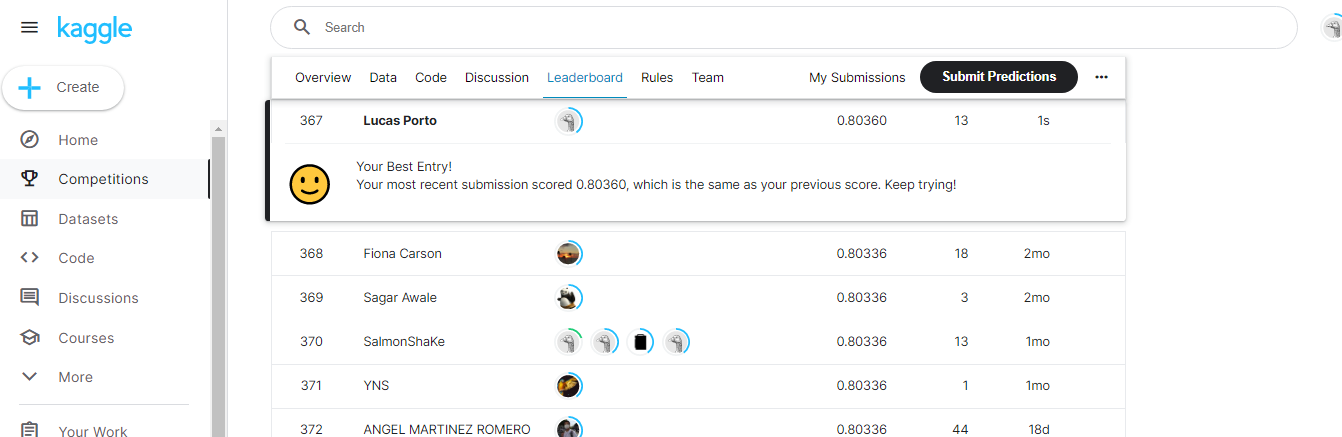

In [87]:
Image('kaggle.png')

Como podemos observar na imagem conseguimos obter uma melhora no nosso score obtendo 0.80360